##MEPS calibration checking the station points##

Here we find the topographical variable in the meps area

## Ensemble Calibration with NN + DEM + Terrain data from Jan-Nov11, 2019 - codes adapted from RASP paper
In this notebook we calibrate T2m, the temperature at 2m level using the ensemble mean and standard deviation of the 51-member ECMWF ensembles. We also use the station topographic variables such as elevation, slope and roughness and terrain type from the digital elevation maps with different resolutions ranging from 100 m to 100 km. We have developed the following  calibration models (1) a fully connected (fc/lr) network with linear activation function (2) neural network (nn) with relu activation function (3) fc/lr with station id embedded (4) fc/lr with terrain type embedded (6) fc/lr with both station_id and terrain type embedded (7) nn with station id embedded (8) nn  with terrain type embedded (9) nn with both station_id and terrain type embedded. The loss function used is CRPS (Continuous Rank Probability Score)

In [0]:
%load_ext autoreload
%autoreload 2


In [0]:
%matplotlib inline
from matplotlib import pyplot
import pandas as pd
import numpy as np
import json
import io

In [0]:
# Imports
import sys

import keras
from keras.layers import Input, Dense, merge, Embedding, Flatten, Dropout, \
    SimpleRNN, LSTM, TimeDistributed, GRU, Dropout, Masking
from keras.layers.merge import Concatenate
from keras.models import Model, Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam

## **Station list from jb**

In [0]:
#The data is in ~/calibration/metcoop_calibration/data/meps_sites_jb.txt
from google.colab import files
uploaded = files.upload()

Saving meps_sites_jb.txt to meps_sites_jb.txt


In [0]:
#IF NEEDED
!rm meps_sites_jb.txt

In [0]:
import pandas as pd
stationlist= pd.read_csv(io.StringIO(uploaded['meps_sites_jb.txt'].decode('utf-8')), sep=";")

In [0]:
stationlist.shape


(1668, 7)

In [0]:
stationlist.head(5)

,SID,loc,lat,lon,elev,x,y
0,1001,70.939N -8.669E,70.939,-8.669,9,-848491.030139,1.010519e+06
1,1010,69.307N 16.131E,69.307,16.131,13,44702.591599,6.696428e+05
2,1015,69.601N 17.837E,69.601,17.837,14,110646.473221,7.045933e+05
3,1015,69.601N 17.830E,69.601,17.830,14,110373.642087,7.045813e+05
4,1018,69.241N 16.003E,69.241,16.003,436,39759.297815,6.621773e+05


In [0]:
stationlist.SID.nunique()

1097

In [0]:
stns= stationlist['loc'].astype('str')

In [0]:
stns.head(2)

0    70.939N -8.669E
1    69.307N 16.131E
Name: loc, dtype: object

In [0]:
stns.nunique()

1668

In [0]:
stationlist.loc.nunique()

AttributeError: ignored

In [0]:
stationlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 7 columns):
SID     1668 non-null int64
loc     1668 non-null object
lat     1668 non-null float64
lon     1668 non-null float64
elev    1668 non-null int64
x       1668 non-null float64
y       1668 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 91.3+ KB


## As SID is Int64 has to be converted to string type to join with the name. So a duplicate column SID is created for keeping the int type


In [0]:
stationlist['SIDoriginal'] = stationlist['SID']

In [0]:
stationlist.head(2)

,SID,loc,lat,lon,elev,x,y,SIDoriginal
0,1001,70.939N -8.669E,70.939,-8.669,9,-848491.030139,1.010519e+06,1001
1,1010,69.307N 16.131E,69.307,16.131,13,44702.591599,6.696428e+05,1010


In [0]:
stationlist['SID'] = stationlist['SID'].astype('str')

In [0]:
stationlist.head(5)

,SID,loc,lat,lon,elev,x,y,SIDoriginal
0,1001,70.939N -8.669E,70.939,-8.669,9,-848491.030139,1.010519e+06,1001
1,1010,69.307N 16.131E,69.307,16.131,13,44702.591599,6.696428e+05,1010
2,1015,69.601N 17.837E,69.601,17.837,14,110646.473221,7.045933e+05,1015
3,1015,69.601N 17.830E,69.601,17.830,14,110373.642087,7.045813e+05,1015
4,1018,69.241N 16.003E,69.241,16.003,436,39759.297815,6.621773e+05,1018


In [0]:
stationlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 8 columns):
SID            1668 non-null object
loc            1668 non-null object
lat            1668 non-null float64
lon            1668 non-null float64
elev           1668 non-null int64
x              1668 non-null float64
y              1668 non-null float64
SIDoriginal    1668 non-null int64
dtypes: float64(4), int64(2), object(2)
memory usage: 104.4+ KB


In [0]:
#The data is in ~/calibration/metcoop_calibration/data/synop_stns_sid_name.csv
from google.colab import files
uploadednames = files.upload()

Saving synop_stns_sid_name.csv to synop_stns_sid_name.csv


In [0]:
import pandas as pd
synop_stations= pd.read_csv(io.StringIO(uploadednames['synop_stns_sid_name.csv'].decode('utf-8')))


In [0]:
#Merge the station list with the names
stationlist = pd.merge(stationlist, synop_stations, on='SID', sort=False)

In [0]:
stationlist.head(2)

,SID,loc,lat,lon,elev,x,y,SIDoriginal,name
0,1001,70.939N -8.669E,70.939,-8.669,9,-848491.030139,1.010519e+06,1001,JANMAYEN
1,1010,69.307N 16.131E,69.307,16.131,13,44702.591599,6.696428e+05,1010,ANDOYA


In [0]:
stationlist = stationlist[['SIDoriginal', 'loc','lat','lon','x','y','name','elev']]

In [0]:
stationlist = stationlist.rename(columns={'SIDoriginal':'SID'})
stationlist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1668 entries, 0 to 1667
Data columns (total 8 columns):
SID     1668 non-null int64
loc     1668 non-null object
lat     1668 non-null float64
lon     1668 non-null float64
x       1668 non-null float64
y       1668 non-null float64
name    1668 non-null object
elev    1668 non-null int64
dtypes: float64(4), int64(2), object(2)
memory usage: 117.3+ KB


##Creating the WGS84 dataset with stationlist, terraintype, DEM and distance_to_coast

## Distance to coast

In [0]:
#upload ~/calibration/derived_terrain_variables/data/distance_to_coast.csv
from google.colab import files
uploaded_dist = files.upload()


Saving distance_to_coast.csv to distance_to_coast.csv


In [0]:
# Reading csv file  ~/calibration/derived_terrain_variables/matti/distance_to_sea.csv
distance_to_coast_df = pd.read_csv(io.StringIO(uploaded_dist['distance_to_coast.csv'].decode('utf-8')))

In [0]:
stationlist_dist = pd.merge(stationlist, distance_to_coast_df, on='SID', sort=False)
stationlist_dist.head(2)


,SID,loc,lat,lon,x,y,name,elev,FMISID,dist_to_coast
0,1001,70.939N -8.669E,70.939,-8.669,-848491.030139,1.010519e+06,JANMAYEN,9,113899,0
1,1010,69.307N 16.131E,69.307,16.131,44702.591599,6.696428e+05,ANDOYA,13,113907,197


## Dataset for stations latlon,x,y, names and WGS84

In [0]:
#IF NEEDED
!rm meps_stations_wgs84_jb_extract_average.csvstationsDEM_wgs.to_csv('stationsDEM_wgs.csv')
!cp stationsDEM_wgs.csv "drive/My Drive/"

In [0]:
#The data is in ~/metcoop_calibration/derived_terrain_variables/metcoop_station_list_wgs84/meps_stations_wgs84_jb_extract_average.csv
from google.colab import files
uploadedDEM = files.upload()

In [0]:
stationDEM= pd.read_csv(io.StringIO(uploadedDEM['meps_stations_wgs84_jb_extract_average.csv'].decode('utf-8')),sep=";")

In [0]:
stationDEM.head(5)

,FID,ZABS500m,rough1km,NSABS1km,HARP_dem_new,rough500m,WEABS5km,rough5km,NSABS5km,WEABS2.5km,elev5km,ZABS1km,ZABS5km,ZABS2.5km,rough2.5km,NSABS500m,elev500m,elev2.5km,WEABS1km,NSABS2.5km,HARP_globcover_new,WEABS500m,elev1km
0,0.0,19.646883,204.0,-46.0,12.0,77.0,-114.0,250.0,-10.0,-102.0,127.0,47.183155,114.437759,106.180275,278.0,-19.0,16.0,171.0,-10.5,-29.5,210.0,-5.0,12.0
1,1.0,2.236068,10.0,3.5,1.0,5.0,-3.5,27.0,6.0,-5.5,1.0,4.949748,6.946222,8.514693,19.0,1.0,2.0,3.0,-3.5,6.5,240.0,-2.0,4.0
2,2.0,9.656604,24.0,9.0,0.0,35.0,1.0,194.0,97.0,-3.5,1.0,9.124144,97.005157,11.067972,86.0,9.0,0.0,4.0,-1.5,10.5,240.0,-3.5,0.0
3,3.0,17.677670,24.0,12.0,40.0,36.0,0.5,194.0,65.5,2.0,2.0,12.000000,65.501907,40.049969,80.0,17.5,7.0,7.0,0.0,40.0,240.0,-2.5,3.0
4,4.0,30.761177,179.0,12.0,420.0,148.0,-94.5,224.0,-46.0,-78.0,133.0,90.300888,105.101143,79.525154,219.0,4.0,352.0,187.0,-89.5,15.5,180.0,-30.5,285.0


In [0]:
stationDEM = stationDEM.rename(columns = {'HARP_dem_new': 'elev100m', 'HARP_globcover_new': 'terrain_type'})

In [0]:
stationDEM.head(2)

,FID,ZABS500m,rough1km,NSABS1km,elev100m,rough500m,WEABS5km,rough5km,NSABS5km,WEABS2.5km,elev5km,ZABS1km,ZABS5km,ZABS2.5km,rough2.5km,NSABS500m,elev500m,elev2.5km,WEABS1km,NSABS2.5km,terrain_type,WEABS500m,elev1km
0,0.0,19.646883,204.0,-46.0,12.0,77.0,-114.0,250.0,-10.0,-102.0,127.0,47.183155,114.437759,106.180275,278.0,-19.0,16.0,171.0,-10.5,-29.5,210.0,-5.0,12.0
1,1.0,2.236068,10.0,3.5,1.0,5.0,-3.5,27.0,6.0,-5.5,1.0,4.949748,6.946222,8.514693,19.0,1.0,2.0,3.0,-3.5,6.5,240.0,-2.0,4.0


In [0]:
stationDEM.shape

(1668, 23)

In [0]:
#Merging stationlist_dist and stationDEM
stationlist_dist_DEM = pd.concat([stationlist_dist,stationDEM],axis = 1)

In [0]:
stationlist_dist_DEM.shape

(1668, 33)

In [0]:
stationlist_dist_DEM.head(2)

,SID,loc,lat,lon,x,y,name,elev,FMISID,dist_to_coast,FID,ZABS500m,rough1km,NSABS1km,elev100m,rough500m,WEABS5km,rough5km,NSABS5km,WEABS2.5km,elev5km,ZABS1km,ZABS5km,ZABS2.5km,rough2.5km,NSABS500m,elev500m,elev2.5km,WEABS1km,NSABS2.5km,terrain_type,WEABS500m,elev1km
0,1001,70.939N -8.669E,70.939,-8.669,-848491.030139,1.010519e+06,JANMAYEN,9,113899,0,0.0,19.646883,204.0,-46.0,12.0,77.0,-114.0,250.0,-10.0,-102.0,127.0,47.183155,114.437759,106.180275,278.0,-19.0,16.0,171.0,-10.5,-29.5,210.0,-5.0,12.0
1,1010,69.307N 16.131E,69.307,16.131,44702.591599,6.696428e+05,ANDOYA,13,113907,197,1.0,2.236068,10.0,3.5,1.0,5.0,-3.5,27.0,6.0,-5.5,1.0,4.949748,6.946222,8.514693,19.0,1.0,2.0,3.0,-3.5,6.5,240.0,-2.0,4.0


In [0]:
stationlist_dist_DEM.columns


Index(['SID', 'loc', 'lat', 'lon', 'x', 'y', 'name', 'elev', 'FMISID',
       'dist_to_coast', 'FID', 'ZABS500m', 'rough1km', 'NSABS1km', 'elev100m',
       'rough500m', 'WEABS5km', 'rough5km', 'NSABS5km', 'WEABS2.5km',
       'elev5km', 'ZABS1km', 'ZABS5km', 'ZABS2.5km', 'rough2.5km', 'NSABS500m',
       'elev500m', 'elev2.5km', 'WEABS1km', 'NSABS2.5km', 'terrain_type',
       'WEABS500m', 'elev1km'],
      dtype='object')

In [0]:
stationsDEM_wgs = stationlist_dist_DEM[['SID', 'loc', 'lat', 'lon', 'x', 'y', 'name', 'elev', 'elev100m','elev500m', 'elev1km','elev2.5km','elev5km', 'rough500m','rough1km','rough2.5km','rough5km', 'NSABS500m', 'NSABS1km','NSABS2.5km','NSABS5km','WEABS500m','WEABS1km','WEABS2.5km','WEABS5km', 'ZABS500m', 'ZABS1km', 'ZABS2.5km', 'ZABS5km','dist_to_coast','terrain_type' ]]

In [0]:
stationsDEM_wgs.shape

(1668, 31)

In [0]:
stationsDEM_wgs.head(2)

,SID,loc,lat,lon,x,y,name,elev,elev100m,elev500m,elev1km,elev2.5km,elev5km,rough500m,rough1km,rough2.5km,rough5km,NSABS500m,NSABS1km,NSABS2.5km,NSABS5km,WEABS500m,WEABS1km,WEABS2.5km,WEABS5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,dist_to_coast,terrain_type
0,1001,70.939N -8.669E,70.939,-8.669,-848491.030139,1.010519e+06,JANMAYEN,9,12.0,16.0,12.0,171.0,127.0,77.0,204.0,278.0,250.0,-19.0,-46.0,-29.5,-10.0,-5.0,-10.5,-102.0,-114.0,19.646883,47.183155,106.180275,114.437759,0,210.0
1,1010,69.307N 16.131E,69.307,16.131,44702.591599,6.696428e+05,ANDOYA,13,1.0,2.0,4.0,3.0,1.0,5.0,10.0,19.0,27.0,1.0,3.5,6.5,6.0,-2.0,-3.5,-5.5,-3.5,2.236068,4.949748,8.514693,6.946222,197,240.0


In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
stationsDEM_wgs.to_csv('stationsDEM_wgs.csv',index=False)
!cp stationsDEM_wgs.csv "drive/My Drive/"

## Combining the training data  ftp://ftp.met.no/projects/jbb/metcoop_cal/trdata_00+036.RData and the DEM data  in WGS84

In [0]:
#The data is in ~/metcoop_calibration/data/trdata_00+036.RData
from google.colab import files
uploaded = files.upload()

Saving trdata_00+036.RData to trdata_00+036.RData


In [0]:
!rm trdata_00+036.RData

In [0]:
# Reading .RData
!pip install pyreadr
import pyreadr

     |████████████████████████████████| 225kB 4.8MB/s 


In [0]:
result = pyreadr.read_r('trdata_00+036.RData')
type(result)


collections.OrderedDict

In [0]:
#the ensemble means and sds data
data=result["x"]
data_saved = data
data.shape


(1561383, 121)

In [0]:
data.head(10)


,LOC,TIME,TIME.REF,LT,SG.0,T2.0,T2.1,T2.2,T2.3,T2.4,T2.5,T2.6,T2.7,T2.8,T2.9,T0.0,T0.1,T0.2,T0.3,T0.4,T0.5,T0.6,T0.7,T0.8,T0.9,H2.0,H2.1,H2.2,H2.3,H2.4,H2.5,H2.6,H2.7,H2.8,H2.9,T.L850.0,T.L850.1,T.L850.2,T.L850.3,T.L850.4,...,TCC.6,TCC.7,TCC.8,TCC.9,LCC.0,LCC.1,LCC.2,LCC.3,LCC.4,LCC.5,LCC.6,LCC.7,LCC.8,LCC.9,MCC.0,MCC.1,MCC.2,MCC.3,MCC.4,MCC.5,MCC.6,MCC.7,MCC.8,MCC.9,MSLP.0,MSLP.1,MSLP.2,MSLP.3,MSLP.4,MSLP.5,MSLP.6,MSLP.7,MSLP.8,MSLP.9,SID,LAT,LON,AMSL,TA,RR_6
0,51.800N 30.250E,1.504872e+09,1.504742e+09,36.0,1114.544312,17.044397,16.628595,16.837946,16.974847,17.102686,17.684412,16.138879,17.330255,16.959161,17.523859,19.408685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.520012,0.627704,0.451124,0.519454,0.516697,0.539641,0.514709,0.520381,0.513829,0.557433,3.551,3.446,3.690,3.610,3.377,...,0.028402,0.953458,0.975418,0.898747,0.869961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101263.625000,101177.601562,101343.835938,101121.507812,101432.500000,101262.304688,101293.781250,101340.523438,101196.070312,101210.031250,NaN,51.8,30.25,NaN,NaN,NaN
1,51.800N 30.250E,1.504958e+09,1.504829e+09,36.0,1114.544312,22.414880,22.958459,21.841669,22.291254,22.213190,21.955652,21.542596,22.999017,21.349359,21.407953,26.322351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.448643,0.378334,0.525253,0.477166,0.439878,0.495448,0.490581,0.416223,0.522221,0.530758,8.412,8.635,8.197,9.102,7.823,...,0.052937,0.000640,0.000813,0.000305,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101514.765625,101495.546875,101537.468750,101455.585938,101608.726562,101460.992188,101571.312500,101580.984375,101460.054688,101557.312500,NaN,51.8,30.25,NaN,NaN,NaN
2,51.800N 30.250E,1.505045e+09,1.504915e+09,36.0,1114.544312,25.406732,25.269952,25.747888,25.985406,25.101892,25.543604,24.834833,25.553674,25.163507,24.561609,28.594904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.463856,0.509920,0.407581,0.469430,0.440604,0.471566,0.483646,0.407892,0.532340,0.525495,13.331,13.342,13.319,13.634,13.062,...,0.037780,0.027055,0.007242,0.005881,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101243.953125,101266.312500,101221.750000,101358.703125,101144.507812,101278.195312,101207.296875,101266.382812,101222.468750,101230.507812,NaN,51.8,30.25,NaN,NaN,NaN
3,51.800N 30.250E,1.505131e+09,1.505002e+09,36.0,1114.544312,25.838861,25.530939,25.429529,26.841333,24.615656,24.144312,26.670587,25.765192,25.697198,24.229761,29.895746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.470741,0.532853,0.449150,0.502433,0.446479,0.556682,0.436137,0.412282,0.541257,0.524551,13.515,13.922,13.100,12.211,14.826,...,0.032185,0.009959,0.062568,0.120013,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101245.773438,101254.070312,101235.953125,101249.382812,101230.031250,101274.148438,101217.281250,101379.445312,101098.750000,101228.515625,NaN,51.8,30.25,NaN,NaN,NaN
4,51.800N 30.250E,1.505218e+09,1.505088e+09,36.0,1114.544312,27.343347,27.323938,26.794855,26.356561,26.939935,26.879633,26.656091,27.131128,26.687280,27.215173,30.767908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.454217,0.449823,0.479130,0.483834,0.497386,0.522726,0.447557,0.453123,0.500944,0.462480,15.134,15.278,15.223,15.115,15.081,...,0.002162,0.000000,0.010266,0.002581,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100591.734375,100472.179688,100516.726562,100464.289062,100732.148438,100790.242188,100398.218750,100399.648438,100803.343750,100538.984375,NaN,51.8,30.25,NaN,NaN,NaN
5,51.800N 30.250E,1.505304e+09,1.505174e+09,36.0,1114.544312,18.893365,21.037286,16.343469,19.414545,17.940912,16.025140,21.104791,19.903162,17.040308,17.782343,21.990198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.724291,0.494056,0.952915,0.629138,0.847620,0.966276,0.502170,0.616315,0.906530,0.793076,8.189,6.475,9.865,7.914,8.511,...,0.626245,0.130615,0.999885,0.996507,0.510096,NaN,NaN,NaN,NaN,NaN,NaN,

In [0]:
data.isnull().sum(axis = 0)

LOC               0
TIME              0
TIME.REF          0
LT                0
SG.0           2706
             ...   
LAT               0
LON               0
AMSL         735758
TA           739401
RR_6        1311902
Length: 121, dtype: int64

In [0]:
data.SID.nunique()

925

In [0]:
data.LOC.nunique()

1422

In [0]:
sum(pd.isnull(data['SID']))

735751

In [0]:
data.shape


(1561383, 121)

In [0]:
data.isna().sum()

In [0]:
#The data is in ~/metcoop_calibration/derived_terrain_variables/metcoop_station_list_wgs84/meps_stations_wgs84_jb_extract_average.csv
from google.colab import files
uploadedDEM = files.upload()

Saving stationsDEM_wgs.csv to stationsDEM_wgs.csv


In [0]:
stationDEM_wgs= pd.read_csv(io.StringIO(uploadedDEM['stationsDEM_wgs.csv'].decode('utf-8')))


In [0]:
stationDEM_wgs.shape

(1668, 31)

In [0]:
cols= stationDEM_wgs.columns

In [0]:
cols

Index(['SID', 'loc', 'lat', 'lon', 'x', 'y', 'name', 'elev', 'elev100m',
       'elev500m', 'elev1km', 'elev2.5km', 'elev5km', 'rough500m', 'rough1km',
       'rough2.5km', 'rough5km', 'NSABS500m', 'NSABS1km', 'NSABS2.5km',
       'NSABS5km', 'WEABS500m', 'WEABS1km', 'WEABS2.5km', 'WEABS5km',
       'ZABS500m', 'ZABS1km', 'ZABS2.5km', 'ZABS5km', 'dist_to_coast',
       'terrain_type'],
      dtype='object')

In [0]:
type(stationDEM_wgs.loc)

pandas.core.indexing._LocIndexer

In [0]:
type(data.LOC)

pandas.core.series.Series

In [0]:
stationDEM = stationDEM_wgs

In [0]:
stationDEM = stationDEM.rename(columns = {'loc': 'LOC'})

In [0]:
stationDEM.head(2)

,SID,LOC,lat,lon,x,y,name,elev,elev100m,elev500m,elev1km,elev2.5km,elev5km,rough500m,rough1km,rough2.5km,rough5km,NSABS500m,NSABS1km,NSABS2.5km,NSABS5km,WEABS500m,WEABS1km,WEABS2.5km,WEABS5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,dist_to_coast,terrain_type
0,1001,70.939N -8.669E,70.939,-8.669,-848491.030139,1.010519e+06,JANMAYEN,9,12.0,16.0,12.0,171.0,127.0,77.0,204.0,278.0,250.0,-19.0,-46.0,-29.5,-10.0,-5.0,-10.5,-102.0,-114.0,19.646883,47.183155,106.180275,114.437759,0,210.0
1,1010,69.307N 16.131E,69.307,16.131,44702.591599,6.696428e+05,ANDOYA,13,1.0,2.0,4.0,3.0,1.0,5.0,10.0,19.0,27.0,1.0,3.5,6.5,6.0,-2.0,-3.5,-5.5,-3.5,2.236068,4.949748,8.514693,6.946222,197,240.0


In [0]:
stationDEM['LOC']= stationDEM['LOC'].astype('str')

In [0]:
type(stationDEM.LOC)

pandas.core.series.Series

In [0]:
stationDEM.head(2)

,SID,LOC,lat,lon,x,y,name,elev,elev100m,elev500m,elev1km,elev2.5km,elev5km,rough500m,rough1km,rough2.5km,rough5km,NSABS500m,NSABS1km,NSABS2.5km,NSABS5km,WEABS500m,WEABS1km,WEABS2.5km,WEABS5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,dist_to_coast,terrain_type
0,1001,70.939N -8.669E,70.939,-8.669,-848491.030139,1.010519e+06,JANMAYEN,9,12.0,16.0,12.0,171.0,127.0,77.0,204.0,278.0,250.0,-19.0,-46.0,-29.5,-10.0,-5.0,-10.5,-102.0,-114.0,19.646883,47.183155,106.180275,114.437759,0,210.0
1,1010,69.307N 16.131E,69.307,16.131,44702.591599,6.696428e+05,ANDOYA,13,1.0,2.0,4.0,3.0,1.0,5.0,10.0,19.0,27.0,1.0,3.5,6.5,6.0,-2.0,-3.5,-5.5,-3.5,2.236068,4.949748,8.514693,6.946222,197,240.0


In [0]:
data.shape

(1561383, 121)

In [0]:
stationDEM=stationDEM.drop(['SID','lat','lon'],axis=1)

In [0]:
#check datanew is datanew with SID dropped
datanew.shape

(1561383, 120)

In [0]:
df_dem_wgs = pd.merge(datanew, stationDEM, on='LOC', how = 'inner')

In [0]:
df_dem_wgs.shape

(1561383, 147)

In [0]:
cols_data_dem = df_dem.columns

In [0]:
df_dem_wgs.head(2)


,LOC,TIME,TIME.REF,LT,SG.0,T2.0,T2.1,T2.2,T2.3,T2.4,T2.5,T2.6,T2.7,T2.8,T2.9,T0.0,T0.1,T0.2,T0.3,T0.4,T0.5,T0.6,T0.7,T0.8,T0.9,H2.0,H2.1,H2.2,H2.3,H2.4,H2.5,H2.6,H2.7,H2.8,H2.9,T.L850.0,T.L850.1,T.L850.2,T.L850.3,T.L850.4,...,MSLP.2,MSLP.3,MSLP.4,MSLP.5,MSLP.6,MSLP.7,MSLP.8,MSLP.9,LAT,LON,AMSL,TA,RR_6,x,y,name,elev,elev100m,elev500m,elev1km,elev2.5km,elev5km,rough500m,rough1km,rough2.5km,rough5km,NSABS500m,NSABS1km,NSABS2.5km,NSABS5km,WEABS500m,WEABS1km,WEABS2.5km,WEABS5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,dist_to_coast,terrain_type
0,51.800N 30.250E,1.504872e+09,1.504742e+09,36.0,1114.544312,17.044397,16.628595,16.837946,16.974847,17.102686,17.684412,16.138879,17.330255,16.959161,17.523859,19.408685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.520012,0.627704,0.451124,0.519454,0.516697,0.539641,0.514709,0.520381,0.513829,0.557433,3.551,3.446,3.690,3.610,3.377,...,101343.835938,101121.507812,101432.500000,101262.304688,101293.78125,101340.523438,101196.070312,101210.03125,51.8,30.25,NaN,NaN,NaN,1.057841e+06,-1.160339e+06,BRAGIN,116,112.0,113.0,113.0,113.0,115.0,3.0,2.0,8.0,14.0,-1.0,-1.0,-2.0,-6.5,1.0,0.5,0.0,0.0,1.414214,1.118034,2.0,6.5,556684,50.0
1,51.800N 30.250E,1.504958e+09,1.504829e+09,36.0,1114.544312,22.414880,22.958459,21.841669,22.291254,22.213190,21.955652,21.542596,22.999017,21.349359,21.407953,26.322351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.448643,0.378334,0.525253,0.477166,0.439878,0.495448,0.490581,0.416223,0.522221,0.530758,8.412,8.635,8.197,9.102,7.823,...,101537.468750,101455.585938,101608.726562,101460.992188,101571.31250,101580.984375,101460.054688,101557.31250,51.8,30.25,NaN,NaN,NaN,1.057841e+06,-1.160339e+06,BRAGIN,116,112.0,113.0,113.0,113.0,115.0,3.0,2.0,8.0,14.0,-1.0,-1.0,-2.0,-6.5,1.0,0.5,0.0,0.0,1.414214,1.118034,2.0,6.5,556684,50.0


In [0]:
from google.colab import drive
drive.mount('drive',force_remount=True)

Mounted at drive


In [0]:
df_dem_wgs.to_csv('meps_ens_dem_wgs84.csv',index=False)
!cp meps_ens_dem_wgs84.csv "drive/My Drive/"

## MEPS dem and the trdata

In [0]:
#The data is in ~/metcoop_calibration/data/stationsDEM_meps.csv
from google.colab import files
uploadedDEMmeps = files.upload()

Saving stationsDEM_meps.csv to stationsDEM_meps.csv


In [0]:
stationDEM_meps= pd.read_csv(io.StringIO(uploadedDEMmeps['stationsDEM_meps.csv'].decode('utf-8')))

In [0]:
stationDEM = stationDEM_meps
stationDEM = stationDEM.rename(columns = {'loc': 'LOC'})
stationDEM['LOC']= stationDEM['LOC'].astype('str')

In [0]:
data.head(2)

,LOC,TIME,TIME.REF,LT,SG.0,T2.0,T2.1,T2.2,T2.3,T2.4,T2.5,T2.6,T2.7,T2.8,T2.9,T0.0,T0.1,T0.2,T0.3,T0.4,T0.5,T0.6,T0.7,T0.8,T0.9,H2.0,H2.1,H2.2,H2.3,H2.4,H2.5,H2.6,H2.7,H2.8,H2.9,T.L850.0,T.L850.1,T.L850.2,T.L850.3,T.L850.4,...,TCC.6,TCC.7,TCC.8,TCC.9,LCC.0,LCC.1,LCC.2,LCC.3,LCC.4,LCC.5,LCC.6,LCC.7,LCC.8,LCC.9,MCC.0,MCC.1,MCC.2,MCC.3,MCC.4,MCC.5,MCC.6,MCC.7,MCC.8,MCC.9,MSLP.0,MSLP.1,MSLP.2,MSLP.3,MSLP.4,MSLP.5,MSLP.6,MSLP.7,MSLP.8,MSLP.9,SID,LAT,LON,AMSL,TA,RR_6
0,51.800N 30.250E,1.504872e+09,1.504742e+09,36.0,1114.544312,17.044397,16.628595,16.837946,16.974847,17.102686,17.684412,16.138879,17.330255,16.959161,17.523859,19.408685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.520012,0.627704,0.451124,0.519454,0.516697,0.539641,0.514709,0.520381,0.513829,0.557433,3.551,3.446,3.690,3.610,3.377,...,0.028402,0.953458,0.975418,0.898747,0.869961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101263.625000,101177.601562,101343.835938,101121.507812,101432.500000,101262.304688,101293.78125,101340.523438,101196.070312,101210.03125,NaN,51.8,30.25,NaN,NaN,NaN
1,51.800N 30.250E,1.504958e+09,1.504829e+09,36.0,1114.544312,22.414880,22.958459,21.841669,22.291254,22.213190,21.955652,21.542596,22.999017,21.349359,21.407953,26.322351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.448643,0.378334,0.525253,0.477166,0.439878,0.495448,0.490581,0.416223,0.522221,0.530758,8.412,8.635,8.197,9.102,7.823,...,0.052937,0.000640,0.000813,0.000305,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101514.765625,101495.546875,101537.468750,101455.585938,101608.726562,101460.992188,101571.31250,101580.984375,101460.054688,101557.31250,NaN,51.8,30.25,NaN,NaN,NaN


In [0]:
datanew=data.drop(['SID'], axis=1)

In [0]:
datanew.shape

(1561383, 120)

In [0]:
stationDEMnew = stationDEM.drop(['SID','lat','lon'],axis=1)

In [0]:
df_dem_meps = pd.merge(datanew, stationDEMnew, on='LOC', how = 'inner')

In [0]:
df_dem_meps.shape

(1561383, 147)

In [0]:
df_dem_meps.to_csv('meps_ens_dem_lcc.csv',index=False)
!cp meps_ens_dem_lcc.csv "drive/My Drive/"

In [0]:
data.SID.nunique()

925

In [0]:
df['SID']

10         33124
11         33124
12         33124
13         33124
14         33124
           ...  
1561378     1055
1561379     1055
1561380     1055
1561381     1055
1561382     1055
Name: SID, Length: 825632, dtype: object

In [0]:

df_dem.shape

(1264559, 151)

In [0]:
df_dem.head(2)

,LOC,TIME,TIME.REF,LT,SG.0,T2.0,T2.1,T2.2,T2.3,T2.4,T2.5,T2.6,T2.7,T2.8,T2.9,T0.0,T0.1,T0.2,T0.3,T0.4,T0.5,T0.6,T0.7,T0.8,T0.9,H2.0,H2.1,H2.2,H2.3,H2.4,H2.5,H2.6,H2.7,H2.8,H2.9,T.L850.0,T.L850.1,T.L850.2,T.L850.3,T.L850.4,...,MSLP.6,MSLP.7,MSLP.8,MSLP.9,SID,LAT,LON,AMSL,TA,RR_6,loc,lat,lon,x,y,name,elev,elev100m,elev500m,elev1km,elev2.5km,elev5km,rough500m,rough1km,rough2.5km,rough5km,NSABS500m,NSABS1km,NSABS2.5km,NSABS5km,WEABS500m,WEABS1km,WEABS2.5km,WEABS5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,dist_to_coast,terrain_type
0,51.800N 30.250E,1.505736e+09,1.505606e+09,36.0,1114.544312,20.913507,21.457605,20.071222,20.90072,20.355707,20.909875,19.42309,20.809961,20.976587,19.810571,23.424097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465806,0.512444,0.429231,0.427661,0.541769,0.445994,0.591741,0.428955,0.503066,0.527428,6.741,6.48,7.037,7.048,6.33,...,101023.882812,101135.875,100965.804688,101121.015625,33124,51.8,30.25,116,20.2,NaN,51.800N 30.250E,51.8,30.25,1.057841e+06,-1.160339e+06,BRAGIN,116,112.0,113.0,113.0,113.0,115.0,3.0,2.0,8.0,14.0,-1.0,-1.0,-2.0,-6.5,1.0,0.5,0.0,0.0,1.414214,1.118034,2.0,6.5,556684,50.0
1,51.800N 30.250E,1.505736e+09,1.505606e+09,36.0,1114.544312,20.913507,21.457605,20.071222,20.90072,20.355707,20.909875,19.42309,20.809961,20.976587,19.810571,23.424097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465806,0.512444,0.429231,0.427661,0.541769,0.445994,0.591741,0.428955,0.503066,0.527428,6.741,6.48,7.037,7.048,6.33,...,101023.882812,101135.875,100965.804688,101121.015625,33124,51.8,30.25,116,20.2,NaN,51.800N 30.250E,51.8,30.25,1.057841e+06,-1.160339e+06,BRAGIN,116,112.0,113.0,113.0,113.0,115.0,3.0,2.0,8.0,14.0,-1.0,-1.0,-2.0,-6.5,1.0,0.5,0.0,0.0,1.414214,1.118034,2.0,6.5,556684,50.0


In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
df_dem.to_csv('meps_DEM_wgs.csv')
!cp meps_DEM_wgs.csv "drive/My Drive/"

In [0]:
df_dem.head(2)

,LOC,TIME,TIME.REF,LT,SG.0,T2.0,T2.1,T2.2,T2.3,T2.4,T2.5,T2.6,T2.7,T2.8,T2.9,T0.0,T0.1,T0.2,T0.3,T0.4,T0.5,T0.6,T0.7,T0.8,T0.9,H2.0,H2.1,H2.2,H2.3,H2.4,H2.5,H2.6,H2.7,H2.8,H2.9,T.L850.0,T.L850.1,T.L850.2,T.L850.3,T.L850.4,...,MSLP.7,MSLP.8,MSLP.9,SID,LAT,LON,AMSL,TA,RR_6,SID,loc,lat,lon,x,y,name,elev,elev100m,elev500m,elev1km,elev2.5km,elev5km,rough500m,rough1km,rough2.5km,rough5km,NSABS500m,NSABS1km,NSABS2.5km,NSABS5km,WEABS500m,WEABS1km,WEABS2.5km,WEABS5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,dist_to_coast,terrain_type
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1001.0,70.939N -8.669E,70.939,-8.669,-848491.030139,1.010519e+06,JANMAYEN,9.0,12.0,16.0,12.0,171.0,127.0,77.0,204.0,278.0,250.0,-19.0,-46.0,-29.5,-10.0,-5.0,-10.5,-102.0,-114.0,19.646883,47.183155,106.180275,114.437759,0.0,210.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1010.0,69.307N 16.131E,69.307,16.131,44702.591599,6.696428e+05,ANDOYA,13.0,1.0,2.0,4.0,3.0,1.0,5.0,10.0,19.0,27.0,1.0,3.5,6.5,6.0,-2.0,-3.5,-5.5,-3.5,2.236068,4.949748,8.514693,6.946222,197.0,240.0


In [0]:
C

## Dataset for stations latlon,x,y, names and LCC

In [0]:
from google.colab import files
uploadedDEM_meps = files.upload()

Saving meps_stations_mepsCRS_jb_extract_average.csv to meps_stations_mepsCRS_jb_extract_average.csv


In [0]:
stationDEM= pd.read_csv(io.StringIO(uploastationsDEM_wgs.csvdedDEM_meps['meps_stations_mepsCRS_jb_extract_average.csv'].decode('utf-8')),sep=";")
stationDEM.head(2)


,FID,rough2.5km_meps,NSABS500m_meps,WEABS2.5km_meps,rough5km_meps,ZABS5km_meps,elev1km_meps,NSABS2.5km_meps,WEABS5km_meps,elev2.5km_meps,HARP_dem_new_meps,ZABS2.5km_meps,elev500m_meps,WEABS1km_meps,WEABS500m_meps,NSABS1km_meps,rough1km_meps,ZABS1km_meps,NSABS5km_meps,ZABS500m_meps,elev5km_meps,HARP_globcover_new_meps,rough500m_meps
0,0.0,74.0,-35.5,-27.0,36.0,18.200275,6.0,-29.5,-63.0,2.0,12.0,37.054016,16.0,-10.5,-7.0,-46.0,92.0,26.476404,-15.5,19.646883,1.0,220.0,77.0
1,1.0,14.0,1.0,-0.5,37.0,13.829317,1.0,6.5,-3.0,1.0,1.0,7.017834,0.0,-2.5,-1.0,2.5,8.0,3.201562,13.5,1.414214,7.0,150.0,3.0


In [0]:
stationDEM.shape

(1668, 23)

In [0]:
stationDEM = stationDEM.rename(columns = {'HARP_dem_new_meps': 'elev100m_meps', 'HARP_globcover_new_meps': 'terrain_type_meps'})

In [0]:
#Merging stationlist_dist and stationDEM
stationlist_dist_DEM = pd.concat([stationlist_dist,stationDEM],axis = 1)

In [0]:
stationlist_dist_DEM.shape

(1668, 33)

In [0]:
#select and order the columns
stationlist_dist_DEM.columns

Index(['SID', 'loc', 'lat', 'lon', 'x', 'y', 'name', 'elev', 'FMISID',
       'dist_to_coast', 'FID', 'rough2.5km_meps', 'NSABS500m_meps',
       'WEABS2.5km_meps', 'rough5km_meps', 'ZABS5km_meps', 'elev1km_meps',
       'NSABS2.5km_meps', 'WEABS5km_meps', 'elev2.5km_meps', 'elev100m_meps',
       'ZABS2.5km_meps', 'elev500m_meps', 'WEABS1km_meps', 'WEABS500m_meps',
       'NSABS1km_meps', 'rough1km_meps', 'ZABS1km_meps', 'NSABS5km_meps',
       'ZABS500m_meps', 'elev5km_meps', 'terrain_type_meps', 'rough500m_meps'],
      dtype='object')

In [0]:
stationsDEM_meps = stationlist_dist_DEM[['SID', 'loc', 'lat', 'lon', 'x', 'y', 'name', 'elev', 'elev100m_meps','elev500m_meps', 'elev1km_meps','elev2.5km_meps','elev5km_meps', 'rough500m_meps','rough1km_meps','rough2.5km_meps','rough5km_meps', 'NSABS500m_meps', 'NSABS1km_meps','NSABS2.5km_meps','NSABS5km_meps','WEABS500m_meps','WEABS1km_meps','WEABS2.5km_meps','WEABS5km_meps', 'ZABS500m_meps', 'ZABS1km_meps', 'ZABS2.5km_meps', 'ZABS5km_meps','dist_to_coast','terrain_type_meps' ]]


In [0]:
stationsDEM_meps.shape

(1668, 31)

In [0]:
tt = stationsDEM_meps['terrain_type_meps']

In [0]:
tt.

0      220.0
1      150.0
2      240.0
3      240.0
4      180.0
       ...  
995    240.0
996    140.0
997     50.0
998    240.0
999    100.0
Name: terrain_type_meps, Length: 1000, dtype: float64

In [0]:
stationsDEM_meps.loc[stationsDEM_meps['terrain_type_meps'] == 0.0]



,SID,loc,lat,lon,x,y,name,elev,elev100m_meps,elev500m_meps,elev1km_meps,elev2.5km_meps,elev5km_meps,rough500m_meps,rough1km_meps,rough2.5km_meps,rough5km_meps,NSABS500m_meps,NSABS1km_meps,NSABS2.5km_meps,NSABS5km_meps,WEABS500m_meps,WEABS1km_meps,WEABS2.5km_meps,WEABS5km_meps,ZABS500m_meps,ZABS1km_meps,ZABS2.5km_meps,ZABS5km_meps,dist_to_coast,terrain_type_meps
10,1028,74.517N 19.005E,74.517,19.005,1.215620e+05,1.260169e+06,BJORNOYA,16,0.0,0.0,0.0,0.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-1119,0.0
1273,22165,68.655N 43.288E,68.655,43.288,1.113348e+06,8.459576e+05,KANINNOS,48,0.0,0.0,0.0,0.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,551,0.0
1274,22165,68.653N 43.286E,68.653,43.286,1.113370e+06,8.457208e+05,KANINNOS,48,0.0,0.0,0.0,0.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,551,0.0
1275,22165,68.650N 43.280E,68.650,43.280,1.113292e+06,8.453136e+05,KANINNOS,48,0.0,0.0,0.0,0.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,551,0.0
1290,22271,67.877N 44.174E,67.877,44.174,1.183983e+06,7.835373e+05,SHOJNA,5,0.0,0.0,0.0,0.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,280,0.0
1291,22271,67.880N 44.170E,67.880,44.170,1.183685e+06,7.837641e+05,SHOJNA,8,0.0,0.0,0.0,0.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,280,0.0
1292,22271,67.873N 44.171E,67.873,44.171,1.184066e+06,7.830810e+05,SHOJNA,5,0.0,0.0,0.0,0.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,280,0.0
1307,22365,66.409N 43.267E,66.409,43.267,1.219436e+06,6.190474e+05,ABRAMOVSKIJMAJAK,19,0.0,0.0,0.0,0.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,86,0.0
1308,22365,66.420N 43.270E,66.420,43.270,1.219034e+06,6.202124e+05,ABRAMOVSKIJMAJAK,20,0.0,0.0,0.0,0.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,86,0.0
1309,22365,66.405N 43.267E,66.405,43.267,1.219626e+06,6.186445e+05,ABRAMOVSKIJMAJAK,19,0.0,0.0,0.0,0.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,86,0.0


In [0]:
stationsDEM_meps.to_csv('stationsDEM_meps.csv',index=False)
!cp stationsDEM_meps.csv "drive/My Drive/"

## Observations from OBS_2019.sqlite

In [0]:
#The data is in ~/calibration/metcoop_calibration/data/meps_sites_jb.txt
from google.colab import files
uploaded = files.upload()

Saving OBS_2019.sqlite to OBS_2019.sqlite


KeyboardInterrupt: ignored

## Training data from the sample MEPS SQLite tables 

In [0]:
#The data is in ~/calibration/metcoop_calibration/data/meps_sites_jb.txt
from google.colab import files
uploaded = files.upload()

Saving distance_to_sea.csv to distance_to_sea (1).csv


In [0]:
# Reading csv file
df = pd.read_csv(io.StringIO(uploaded['fcnew_2019_00+036.csv'].decode('utf-8')),delim_whitespace=True)

In [0]:
#using the SQLite Table to read data.
import sqlite3
con = sqlite3.connect('FCTABLE_T2m_201908_00+036.sqlite')

In [0]:
name = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'",con)
name

,name
0,FC


In [0]:
data =  pd.read_sql_query("SELECT * FROM FC",con)
data.head(10)#the ensemble means and sds data
data=result["x"]
data_saved = data
data.shape


,SID,fcdate,leadtime,validdate,MEPS_prod_mbr000,MEPS_prod_mbr001,MEPS_prod_mbr002,MEPS_prod_mbr003,MEPS_prod_mbr004,MEPS_prod_mbr005,MEPS_prod_mbr006,MEPS_prod_mbr007,MEPS_prod_mbr008,MEPS_prod_mbr009
0,1021,NaN,NaN,NaN,285.127879,285.059275,285.686870,289.828925,284.090990,284.846968,284.694988,283.389456,284.740580,284.270130
1,1022,NaN,NaN,NaN,285.148556,285.341298,286.623852,287.375192,284.090513,284.934700,284.726647,284.489729,284.738697,284.132169
2,1029,NaN,NaN,NaN,286.300876,286.200786,285.413663,284.091669,284.373418,286.434290,285.280543,286.019461,284.830332,285.846544
3,1038,NaN,NaN,NaN,283.335520,282.822994,283.247826,285.619340,283.851558,282.727725,283.168470,283.100177,283.027337,283.014753
4,1085,NaN,NaN,NaN,280.092695,277.420066,281.581752,280.869355,281.675678,280.228543,280.128796,280.978413,279.638276,280.359199
5,1200,NaN,NaN,NaN,284.635498,284.855447,285.973748,284.574052,284.670230,284.451834,284.733689,284.633108,284.180659,284.542699
6,1201,NaN,NaN,NaN,284.546388,287.408033,284.899633,284.767924,285.700401,284.038859,284.630975,284.390391,284.022380,284.338202
7,1226,NaN,NaN,NaN,291.936947,292.122885,291.810365,291.269870,291.937596,290.596182,291.896370,292.521422,290.840544,292.295739
8,1302,NaN,NaN,NaN,287.231852,287.257255,287.421978,286.103043,287.096196,286.915913,285.981676,285.937499,286.514891,286.478168
9,1309,NaN,NaN,NaN,291.364457,290.579429,290.407397,289.861438,288.545213,289.600910,289.779515,289.909232,289.027031,290.068589


In [0]:
data.count()

SID                 38967
fcdate              35619
leadtime            35619
validdate           35619
MEPS_prod_mbr000    38967
MEPS_prod_mbr001    37710
MEPS_prod_mbr002    36453
MEPS_prod_mbr003    38967
MEPS_prod_mbr004    38967
MEPS_prod_mbr005    37710
MEPS_prod_mbr006    37710
MEPS_prod_mbr007    37710
MEPS_prod_mbr008    37710
MEPS_prod_mbr009    37710
dtype: int64

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38967 entries, 0 to 38966
Data columns (total 14 columns):
SID                 38967 non-null int64
fcdate              35619 non-null float64
leadtime            35619 non-null float64
validdate           35619 non-null float64
MEPS_prod_mbr000    38967 non-null float64
MEPS_prod_mbr001    37710 non-null float64
MEPS_prod_mbr002    36453 non-null float64
MEPS_prod_mbr003    38967 non-null float64
MEPS_prod_mbr004    38967 non-null float64
MEPS_prod_mbr005    37710 non-null float64
MEPS_prod_mbr006    37710 non-null float64
MEPS_prod_mbr007    37710 non-null float64
MEPS_prod_mbr008    37710 non-null float64
MEPS_prod_mbr009    37710 non-null float64
dtypes: float64(13), int64(1)
memory usage: 4.2 MB


In [0]:
!rm training_data_T2m_00+036.RData to training_data_T2m_00+036*

rm: cannot remove 'training_data_T2m_00+036.RData': No such file or directory
rm: cannot remove 'to': No such file or directory
rm: cannot remove 'training_data_T2m_00+036*': No such file or directory


In [0]:
# if needed to remove a loaded file
#!rm training_data_T2m_12+048.RData
!rm stationlist_jan_sep19_00_036globecover_extract.csv


rm: cannot remove 'stationlist_jan_sep19_00_036globecover_extract.csv': No such file or directory


In [0]:
# Reading .RData
!pip install pyreadr
import pyreadr

result = pyreadr.read_r('training_data_T2m_00+036.RData')
type(result)

     |████████████████████████████████| 225kB 10.2MB/s 


collections.OrderedDict

In [0]:
#the ensemble means and sds data
data=result["x"]
data_saved = data
data.shape

(570657, 22)

In [0]:
data.head(2)

,SID,validdate,fcdate,leadtime,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,obs,lat,lon,elev,name,Mlsm,Melev,ELEV
0,1001,1554638400,1554508800,36,272.887625,0.338977,11.261277,0.669280,0.000000,0.000000,6.019736,0.331503,268.977972,0.74219,273.7,70.9331,-8.6667,9.4,JAN MAYEN,0.386374,39.696462,30.296462
1,1001,1554724800,1554595200,36,272.504397,0.238677,7.370655,0.728858,0.000016,0.000015,3.943128,0.422621,269.359161,0.31186,273.1,70.9331,-8.6667,9.4,JAN MAYEN,0.386374,39.696462,30.296462


In [0]:
 Data Jan-November 2019data.loc[data['SID'] == 2965].head(2)

SyntaxError: ignored

In [0]:
data.loc[data['SID'] == 4063].head(2)

,SID,validdate,fcdate,leadtime,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,obs,lat,lon,elev,name,Mlsm,Melev,ELEV
143784,4063,1555416000,1555286400,36,278.500958,0.831619,13.040117,2.103612,0.001139,0.000442,1.596776,0.510542,273.485027,0.236833,283.1,65.6833,-18.0833,27.0,AKUREYRI,0.99935,588.609674,561.609674
143785,4063,1555761600,1555632000,36,279.144016,0.383223,14.559026,2.008752,0.000870,0.000443,3.210736,0.572925,271.375215,0.683647,282.7,65.6833,-18.0833,27.0,AKUREYRI,0.99935,588.609674,561.609674


In [0]:
ata.loc[data['SID'] == 4137].head(2)

In [0]:
data.loc[data['SID'] == 4145].head(2) Data Jan-November 2019

,SID,validdate,fcdate,leadtime,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,obs,lat,lon,elev,name,Mlsm,Melev,ELEV
145899,4145,1557921600,1557792000,36,285.009523,0.600963,10.232882,0.955872,0.000433,0.000424,3.561180,0.594557,277.655281,0.590778,288.1,65.658,-20.2925,8.0,BLONDUOS,0.98699,306.454223,298.454223
145900,4145,1558267200,1558137600,36,283.055083,0.690345,5.449280,0.684732,0.000532,0.000308,2.164242,0.375900,278.023601,0.230898,282.1,65.658,-20.2925,8.0,BLONDUOS,0.98699,306.454223,298.454223


In [0]:
data.loc[data['SID'] == 4123].head(2)

,SID,validdate,fcdate,leadtime,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,obs,lat,lon,elev,name,Mlsm,Melev,ELEV
145253,4123,1554292800,1554163200,36,274.116739,0.756695,9.711632,1.136372,0.000599,0.000445,5.773644,0.675368,267.726806,0.953302,277.5,66.4107,-22.3789,22.0,HORNBJARGSVITI,0.123373,36.637313,14.637313
145254,4123,1554465600,1554336000,36,275.554832,0.335136,6.822373,2.245195,0.001451,0.000797,4.539396,1.482347,272.833495,0.654430,276.8,66.4107,-22.3789,22.0,HORNBJARGSVITI,0.123373,36.637313,14.637313


In [0]:
data.loc[data['SID'] == 4176].head(2)

,SID,validdate,fcdate,leadtime,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,obs,lat,lon,elev,name,Mlsm,Melev,ELEV
146549,4176,1554465600,1554336000,36,268.527737,0.540042,3.014441,0.313850,0.000029,0.000017,0.969712,0.335392,265.680162,1.205948,269.3,64.9284,-15.7771,639.0,KARAHNJUKAR,0.999991,596.257546,-42.742454
146550,4176,1554552000,1554422400,36,270.195370,0.400146,6.553437,0.733289,0.000234,0.000076,3.655146,0.496313,268.583409,0.610403,271.6,64.9284,-15.7771,639.0,KARAHNJUKAR,0.999991,596.257546,-42.742454


In [0]:
data.loc[data['name'] == ''].head(2)

,SID,validdate,fcdate,leadtime,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,obs,lat,lon,elev,name,Mlsm,Melev,ELEV
107187,2965,1556193600,1556064000,36,292.716395,0.532117,7.407074,0.646398,0.000012,0.000026,2.336747,0.501243,274.696193,0.820198,294.5,60.9667,25.6333,79.0,LAHTI,0.927725,104.550413,25.550413
107188,2965,1554206400,1554076800,36,279.395237,0.483607,9.645741,0.665978,0.000022,0.000041,3.942189,0.338143,268.705466,1.042408,281.3,60.9667,25.6333,79.0,LAHTI,0.927725,104.550413,25.550413


In [0]:
4176, 4145, 2965, 4123, 4156

In [0]:
data['validdate'] = pd.to_datetime(data['validdate'],unit='s')
data.tail(4)

,SID,validdate,fcdate,leadtime,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,obs,lat,lon,elev,name,Mlsm,Melev,ELEV
570653,62012,2019-11-08 12:00:00,1573084800,36,296.796117,0.539015,8.226629,0.695273,0.001999,0.001040,3.680447,0.525692,276.710161,1.272287,296.7,32.6333,14.3,22.0,EL KHOMS,0.900015,149.927784,127.927784
570654,62012,2019-11-09 12:00:00,1573171200,36,296.307220,1.076234,9.938267,2.457939,0.000263,0.000396,5.441116,1.904880,283.149218,2.153847,297.6,32.6333,14.3,22.0,EL KHOMS,0.900015,149.927784,127.927784
570655,62012,2019-11-10 12:00:00,1573257600,36,294.725742,0.670530,7.375163,0.886262,0.000353,0.000329,2.830299,0.651931,275.607522,3.220052,297.6,32.6333,14.3,22.0,EL KHOMS,0.900015,149.927784,127.927784
570656,62012,2019-11-11 12:00:00,1573344000,36,297.088647,1.058418,14.859265,1.940301,0.000850,0.002079,7.497013,1.508996,284.489342,1.105772,297.0,32.6333,14.3,22.0,EL KHOMS,0.900015,149.927784,127.927784


In [0]:
!rm wmo_fmisid_distance_modified.csv


rm: cannot remove 'wmo_fmisid_distance_modified.csv': No such file or directory


In [0]:
#The data is in ~/calibration/data/wmo_fmisid_distance_modified.csv
from google.colab import files
uploaded = files.upload()

Saving wmo_fmisid_distance_modified.csv to wmo_fmisid_distance_modified.csv


In [0]:
#The data is in ~/calibration/data/wmo_fmisid_distance_modified.csv
from google.colab import files
uploaded = files.upload()

Saving meps_sites_jb.txt to meps_sites_jb (1).txt


In [0]:
import pandas as pd
stationlist= pd.read_csv(io.StringIO(uploaded['meps_sites_jb.txt'].decode('utf-8')), sep=";")

In [0]:
stationlist.head(5
                 )

,SID,loc,lat,lon,elev,x,y
0,1001,70.939N -8.669E,70.939,-8.669,9,-848491.030139,1.010519e+06
1,1010,69.307N 16.131E,69.307,16.131,13,44702.591599,6.696428e+05
2,1015,69.601N 17.837E,69.601,17.837,14,110646.473221,7.045933e+05
3,1015,69.601N 17.830E,69.601,17.830,14,110373.642087,7.045813e+05
4,1018,69.241N 16.003E,69.241,16.003,436,39759.297815,6.621773e+05


In [0]:
station_sid_lat_lon = stationlist[["SID", "lat", "lon"]]

In [0]:
station_sid_lat_lon.head(5)

,SID,lat,lon
0,1001,70.939,-8.669
1,1010,69.307,16.131
2,1015,69.601,17.837
3,1015,69.601,17.830
4,1018,69.241,16.003


In [0]:
station_sid_lat_lon.to_csv("meps_stations_sid_lat_lon.csv", header=True, sep=",")

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
with open('/content/gdrive/My Drive/meps_stations_sid_lat_lon.csv', 'w') as f:
  f.write('content')

In [0]:
station_sid_x_y = stationlist[["SID", "x", "y"]]

In [0]:
with open('/content/gdrive/My Drive/meps_stations_sid_x_y.csv', 'w') as f:
  f.write('content')

In [0]:
station_sid_x_y.to_csv("meps_stations_sid_x_y.csv", header=True, sep=",")

In [0]:
station_sid_x_y.head(5)

,SID,x,y
0,1001,-848491.030139,1.010519e+06
1,1010,44702.591599,6.696428e+05
2,1015,110646.473221,7.045933e+05
3,1015,110373.642087,7.045813e+05
4,1018,39759.297815,6.621773e+05


In [0]:
# Reading csv file
distance_to_sea_df = pd.read_csv(io.StringIO(uploaded['wmo_fmisid_distance_modified.csv'].decode('utf-8')),delim_whitespace=True)


In [0]:
distance_to_sea_df.head(2)

,SID,DISTANCE_TO_COAST
0,1001,0
1,1002,217


In [0]:
set1 = data.SID.unique()
set2 = distance_to_sea_df.SID.unique()
stations_differ = (list(set(set1) - set(set2))) 
stations_differ

[]

**Merge ensemble data and the distance_to_sea**

In [0]:
data_distance = data.merge(distance_to_sea_df, on= 'SID' )

In [0]:
data_saved = data
data = data_distance

In [0]:
data.shape

(570657, 23)

In [0]:
stations_differ = (list(set(set2) - set(set1))) 
stations_differ

In [0]:
len(stations_differ)

11321

In [0]:
data.shape

(570657, 22)

In [0]:
data['name'].unique().tolist()

In [0]:
data[data['SID'] == 2978]

In [0]:
data[data['name'] == 'HELSINKI KAISANIEMI']

## Raw ensemble calibration

In [0]:
mu = np.mean(data['T2mensmean'])
sigma = np.std(data['T2menssd'])
(np.mean(data['T2mensmean']), np.std(data['T2menssd']))

(290.6448339435354, 0.3829860014139762)

In [0]:
from scipy.stats import norm
crps_raw = np.mean(crps_normal(data['T2mensmean'], data['T2menssd'], data['obs']))
crps_raw

1.1758711381820977

In [0]:
mu = np.mean(data['T2mensmean'])
sigma = np.std(data['T2menssd'])
(np.mean(data['T2mensmean']), np.std(data['T2menssd']))

(290.6448339435354, 0.3829860014139762)

In [0]:
# crps_raw without distance to sea feature
from scipy.stats import norm
crps_raw = np.mean(crps_normal(data['T2mensmean'], data['T2menssd'], data['obs']))
crps_raw

1.1758711381820977

In [0]:
# crps_raw with distance to sea feature
from scipy.stats import norm
crps_raw = np.mean(crps_normal(data['T2mensmean'], data['T2menssd'], data['obs']))
crps_raw

1.1758711381820977

## Calibration of T2m with ensemble mean and standardard deviation of ECMWF ensemble of T2m 

We also use the ensemble mean and standard deviation of  Td2, S10m, Pcp, and Gmax3/6 and station variables lat', 'lon', 'elev','name', 'Mlsm', 'Melev', 'ELEV'. 

In [0]:
data.columns

Index(['SID', 'validdate', 'fcdate', 'leadtime', 'T2mensmean', 'T2menssd',
       'Gmax3ensmean', 'Gmax3enssd', 'Pcpensmean', 'Pcpenssd', 'S10mensmean',
       'S10menssd', 'Td2mensmean', 'Td2menssd', 'obs', 'lat', 'lon', 'elev',
       'name', 'Mlsm', 'Melev', 'ELEV', 'DISTANCE_TO_COAST'],
      dtype='object')

In [0]:
drop_cols = ['SID',	'validdate',	'fcdate',	'leadtime', 'name']

ens_data = data.drop(drop_cols,1)
ens_data.shape

(570657, 18)

In [0]:
ens_data.columns

Index(['T2mensmean', 'T2menssd', 'Gmax3ensmean', 'Gmax3enssd', 'Pcpensmean',
       'Pcpenssd', 'S10mensmean', 'S10menssd', 'Td2mensmean', 'Td2menssd',
       'obs', 'lat', 'lon', 'elev', 'Mlsm', 'Melev', 'ELEV',
       'DISTANCE_TO_COAST'],
      dtype='object')

In [0]:
#Splitting, Scaling and standardindization

from sklearn.model_selection import train_test_split

train, test = train_test_split(ens_data, test_size=0.3)
print(train.shape, test.shape)
train_X = train.drop('obs',1)
train_y = train[['obs']]
train_X.head(2)
train_y.head(2)

test_X = test.drop('obs',1)
test_y = test[['obs']]
test_X.head(2)
test_y.head(2)

from sklearn.preprocessing import StandardScaler
# create scaler
scaler = StandardScaler()
# fit scaler on train data
scaler.fit(train_X)
# apply transform
train_standardized_X  = scaler.transform(train_X)
# fit scaler on test data
scaler.fit(test_X)
# apply transform
test_standardized_X  = scaler.transform(test_X)


(399459, 18) (171198, 18)


In [0]:
#Standardized dataframes

train_std_df_X = pd.DataFrame(train_standardized_X)
test_std_df_X = pd.DataFrame(test_standardized_X)
train_std_df_X.head(2)



train_std_df_X.columns = ['T2mensmean', 'T2menssd', 'Gmax3ensmean', 'Gmax3enssd', 'Pcpensmean',
       'Pcpenssd', 'S10mensmean', 'S10menssd', 'Td2mensmean', 'Td2menssd',
       'lat', 'lon', 'elev', 'Mlsm', 'Melev', 'ELEV', 'DISTANCE_TO_COAST' ]


test_std_df_X.columns = ['T2mensmean', 'T2menssd', 'Gmax3ensmean', 'Gmax3enssd', 'Pcpensmean',
       'Pcpenssd', 'S10mensmean', 'S10menssd', 'Td2mensmean', 'Td2menssd',
       'lat', 'lon', 'elev', 'Mlsm', 'Melev', 'ELEV', 'DISTANCE_TO_COAST']

test_std_df_X.head(2)

,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,lat,lon,elev,Mlsm,Melev,ELEV,DISTANCE_TO_COAST
0,0.049144,-0.657647,1.164283,0.382827,1.804115,2.145107,1.180917,0.931927,0.969007,-0.953935,0.149178,-0.890381,-0.696125,0.320724,-0.808825,-0.173974,-0.797554
1,1.578833,-0.334956,0.540295,-0.458477,-0.606694,-0.770243,1.013886,-0.634459,1.644979,-0.506258,-1.675368,-1.147985,-0.646881,-2.073999,-0.517770,0.227850,-0.897543


In [0]:
train_std_df_X.shape

(399459, 17)

## Calibration

In [0]:
# Imports
import sys

import keras
from keras.layers import Input, Dense, merge, Embedding, Flatten, Dropout, \
    SimpleRNN, LSTM, TimeDistributed, GRU, Dropout, Masking
from keras.layers.merge import Concatenate
from keras.models import Model, Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam

## Calculating CRPS code from RASP paper

In [0]:
"""
Definition of CRPS loss function.
"""
import keras
import keras.backend as K
import numpy as np
# Import erf depending on whether we use the theano or tensorflow backend
if keras.backend.backend() == 'tensorflow':
    from tensorflow import erf
else:vo
    from theano.tensor import erf


def crps_cost_function(y_true, y_pred, theano=False):trdata_00+036
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.
    Code inspired by Kai Polsterer (HITS).
    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]
        theano: Set to true if using this with pure theano.
    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """trdata_00+036

    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]
    # Ugly workaround for different tensor allocation in keras and theano
    if not theano:
        y_true = y_true[:, 0]   # Need to also get rid of axis 1 to match!

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square
    # root again. 
    var = K.square(sigma)
    # The following three variables are just for convenience
    loc = (y_true - mu) / K.sqrt(var)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * K.exp(-K.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pairtrdata_00+036
    crps =  K.sqrt(var) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))trdata_00+036
    # Then we take the mean. The cost is now a scalartrdata_00+036
    return K.mean(crps)


def crps_cost_function_seq(y_true, y_pred):
    """Version of CRPS const function for sequence predictions.
    Here the input tensors have dimensions [sample, time_step].
    The output has the same dimensions so that keras can apply weights
    afterwards for missing data.vo
    Args:  
        y_true: True values with dimensions [sample, time_step, 1]
        y_pred: Predictions with dimensions [sample, time_step, [mean, std]]
    Returns:
        crps: CRPS with dimensions [sample, time_step]
    """
    # Split input
    mu = y_pred[:, :, 0]
    sigma = y_pred[:, :, 1]
    
    tar = y_true[:, :, 0]
    # [sample, time_step]

    # To stop sigma from becoming negative we first have to 
    # convert it the the variance and then take the square9.4 	
    # root again. 
    var = K.square(sigma)
    # The following three variables are just for convenience
    loc = (tar - mu) / K.sqrt(var)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * K.exp(-K.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps = K.sqrt(v ar) * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))

    # Here we do not take the mean because we want keras to be able to apply
    # weights afterwards!
    return crps


def approx_crps_cat(bin_width): 	
    """Wrapper to pass bin_width as an argument to the loss function.
    Args:
        bin_width: width of categorical bins
    Returns:
        loss_function: approximate crps_loss function with bin_width specified
    """ 
    
    def loss(y_true, y_pred):
        """Approximate CRPS function for categorical output.
        Args:
            y_true: One-hot-encoded output
            y_pred: Probability for each bin
        Returns:
            approx_crps: Approximate mean CRPS value for batch
        """
        # [sample, cat]
        cum_obs = K.cumsum(y_true, axis=1)
        cum_preds = K.cumsum(y_pred, axis=1)
        approx_crps = K.sum(K.square(cum_obs - cum_preds), axis=1) * bin_width
        return K.mean(approx_crps)
    return loss

In [0]:
def crps_normal(mu, sigma, y):
    """
    Compute CRPS for a Gaussian distribution. 
    """
    loc = (y - mu) / sigma
    crps = sigma * (loc * (2 * norm.cdf(loc) - 1) + 
                    2 * norm.pdf(loc) - 1. / np.sqrt(np.pi))
    return crps


def maybe_correct_cat_crps(preds, targets, bin_edges):
    """CRPS for categorical predictions. I think this is correct now.
    """
    # pdb.set_trace()
    # Convert input arrays
    preds = np.array(np.atleast_2d(preds), dtype='float')
    targets = np.array(np.atleast_1d(targets), dtype='float')

    # preds [sample, bins]
    # Find insert index
    mat_bins = np.repeat(np.atleast_2d(bin_edges), targets.shape[0], axis=0)
    b = mat_bins.T - targets
    b[b < 0] = 999
    insert_idxs = np.argmin(b, axis=0)

    # Insert
    ins_bin_edges = np.array([np.insert(np.array(bin_edges, dtype=float),
                                        insert_idxs[i], targets[i])
                              for i in range(targets.shape[0])])
    ins_preds = np.array(
        [np.insert(preds[i], insert_idxs[i], preds[i, insert_idxs[i] - 1])
         for i in range(targets.shape[0])])

    # Get obs
    bin_obs = np.array([(ins_bin_edges[i, :-1] <= targets[i]) &
                        (ins_bin_edges[i, 1:] > targets[i])
                        for i in range(targets.shape[0])], dtype=int)

    # Cumsum with weights
    ins_preds *= np.diff(ins_bin_edges, axis=1)
    cum_bin_obs = np.cumsum(bin_obs, axis=1)
    cum_probs = np.cumsum(ins_preds, axis=1)
    cum_probs = (cum_probs.T / cum_probs[:, -1]).T

    # Get adjusted preds
    adj_cum_probs = np.concatenate((np.zeros((cum_probs.shape[0], 1)),
                                    cum_probs), axis=1)
    # Compute squared area for each bin
    sq_list = []
    for i in range(cum_bin_obs.shape[1]):
        x_l = np.abs(cum_bin_obs[:, i] - adj_cum_probs[:, i])
        x_r = np.abs(cum_bin_obs[:, i] - adj_cum_probs[:, i + 1])
        sq = 1./3. * (x_l ** 2 + x_l * x_r + x_r ** 2)
        sq_list.append(sq)

    # Compute CRPS
    crps = np.sum(np.array(sq_list).T * np.diff(ins_bin_edges, axis=1), axis=1)
    return np.mean(crps)


## Fully-Connected FC/LR model 

In [0]:
#from ppnn paper
def build_fc_model(n_features, n_outputs, compile=False, optimizer='adam',
                   lr=0.1, loss=crps_cost_function):
    """Build (and compile) fully connected linear network.

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        compile: If true, compile model
        optimizer:  Name of optimizer
        lr: learning rate
        loss: loss function

    Returns:
        model: Keras model
    """

    inp = Input(shape=(n_features,))
    x = Dense(n_outputs, activation='linear')(inp)
    model = Model(inputs=inp, outputs=x)

    if compile:
        #opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer='adam', loss=loss)
    return model

In [0]:
input_features =  len(train_standardized_X[0])
print(input_features)
fc_model =build_fc_model(input_features, 2, compile=True)
fc_model.summary()

17




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 17)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 36        
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = fc_model.fit(train_standardized_X, train_y, epochs=500, batch_size=50, validation_split=0.2, verbose=2, shuffle=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 319567 samples, validate on 79892 samples
Epoch 1/500





 - 9s - loss: 279.0703 - val_loss: 267.7980
Epoch 2/500
 - 8s - loss: 256.7431 - val_loss: 245.9500
Epoch 3/500
 - 8s - loss: 236.1064 - val_loss: 226.7195
Epoch 4/500
 - 8s - loss: 218.5247 - val_loss: 210.7729
Epoch 5/500
 - 8s - loss: 204.1321 - val_loss: 197.8631
Epoch 6/500
 - 8s - loss: 192.5219 - val_loss: 187.4815
Epoch 7/500
 - 8s - loss: 183.1664 - val_loss: 179.0853
Epoch 8/500
 - 8s - loss: 175.5330 - val_loss: 172.1526
Epoch 9/500
 - 8s - loss: 169.1245 - val_loss: 166.2101
Epoch 10/500
 - 8s - loss: 163.5105 - val_loss: 160.8749
Epoch 11/500
 - 8s - loss: 158.3651 - val_loss: 155.8793
Epoch 12/500
 - 8s - loss: 153.4769 - val_loss: 151.0611
Epoch 13/500
 - 8s - loss: 148.7215 - val_loss: 146.3329
Epoch 14/500
 - 8s - loss: 144.0315 - val_loss: 141.6502
Epoch 15/500
 - 8s - loss: 139.3730 - val_loss: 136.9868
E

In [0]:

#CRPS of train and test data with distance_to_sea 500 epochs
(fc_model.evaluate(train_std_df_X, train_y, batch_size = 50, verbose=0), fc_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0))

(0.9674871761620716, 0.9657362135632391)

In [0]:
#CRPS of train and test data with distance_to_sea
(fc_model.evaluate(train_std_df_X, train_y, batch_size = 50, verbose=0), fc_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0))

(0.9679326689325175, 0.9667154323411454)

In [0]:
#CRPS of train and test data without distance_to_sea
(fc_model.evaluate(train_std_df_X, train_y, batch_size = 50, verbose=0), fc_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0))

(0.9661540346223293, 0.9681226439402982)

In [0]:
history = fc_model.fit(train_standardized_X, train_y, epochs=200, batch_size=50, validation_split=0.2, verbose=2, shuffle=False)

Train on 249820 samples, validate on 62455 samples
Epoch 1/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 2/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 3/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 4/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 5/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 6/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 7/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 8/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 9/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 10/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 11/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 12/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 13/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 14/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 15/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 16/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 17/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoch 18/200
 - 6s - loss: 0.9621 - val_loss: 0.9617
Epoc

## Feature importance 

In [0]:
#Feature importance


#Feature importance for standardized scaled
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# slice error add iloc
def eval_shuf(m, idx, emb=False):
    x_shuf = test_std_df_X.copy()
    x_shuf.iloc[:, idx] = np.random.permutation(x_shuf.iloc[:, idx])
    x = x_shuf
    return m.evaluate(x, test_y, 4096, 0)
def perm_imp(m):
    scores = [eval_shuf(m, i) for i in range(len(test_X.columns))]
    fimp = np.array(scores) - ref_score
    df = pd.DataFrame(columns=['Feature', 'Importance'])
    df['Feature'] = test_std_df_X.columns; df['Importance'] = fimp
    return df
def perm_imp(m):
    scores = [eval_shuf(m, i) for i in range(len(test_X.columns))]
    fimp = np.array(scores) - ref_score
    df = pd.DataFrame(columns=['Feature', 'Importance'])
    df['Feature'] = test_std_df_X.columns; df['Importance'] = fimp
    return df


In [0]:
#fimp for fc
ref_score = fc_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0)

fimp_fc_standardized_model = perm_imp(fc_model)

In [0]:
#fimp for nn

ref_score = hidden_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0)
fimp_nn_standardized_model = perm_imp(hidden_model)

In [0]:
ref_score

0.9363464758706533

In [0]:
hidden_model.fit(train_standardized_X, train_y, epochs=300, batch_size=50,
                 validation_split=0.2, verbose=2, shuffle=False)

Train on 249820 samples, validate on 62455 samples
Epoch 1/300
 - 6s - loss: 0.9672 - val_loss: 0.9815
Epoch 2/300
 - 6s - loss: 0.9671 - val_loss: 0.9812
Epoch 3/300
 - 6s - loss: 0.9670 - val_loss: 0.9805
Epoch 4/300
 - 6s - loss: 0.9669 - val_loss: 0.9796
Epoch 5/300
 - 6s - loss: 0.9669 - val_loss: 0.9787
Epoch 6/300
 - 6s - loss: 0.9668 - val_loss: 0.9786
Epoch 7/300
 - 6s - loss: 0.9668 - val_loss: 0.9786
Epoch 8/300
 - 6s - loss: 0.9667 - val_loss: 0.9787
Epoch 9/300
 - 6s - loss: 0.9666 - val_loss: 0.9787
Epoch 10/300
 - 6s - loss: 0.9666 - val_loss: 0.9787
Epoch 11/300
 - 6s - loss: 0.9665 - val_loss: 0.9787
Epoch 12/300
 - 6s - loss: 0.9664 - val_loss: 0.9789
Epoch 13/300
 - 6s - loss: 0.9664 - val_loss: 0.9788
Epoch 14/300
 - 6s - loss: 0.9664 - val_loss: 0.9786
Epoch 15/300
 - 7s - loss: 0.9663 - val_loss: 0.9787
Epoch 16/300
 - 6s - loss: 0.9663 - val_loss: 0.9787
Epoch 17/300
 - 6s - loss: 0.9662 - val_loss: 0.9786
Epoch 18/300
 - 6s - loss: 0.9661 - val_loss: 0.9787
Epoc

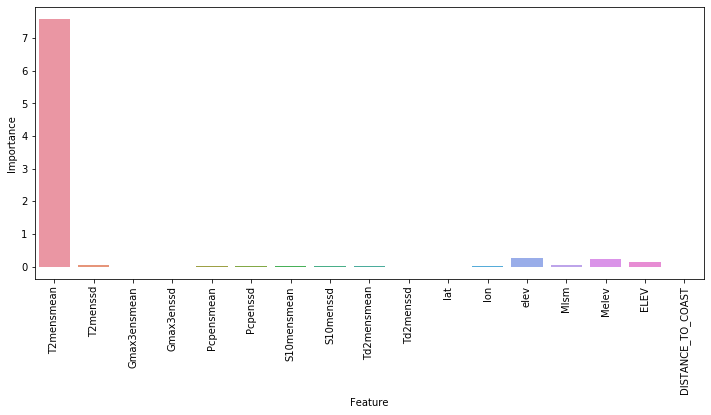

In [0]:
#fimp for fc
ref_score = fc_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0)

fimp_fc_standardized_model = perm_imp(fc_model)
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_fc_standardized_model, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);


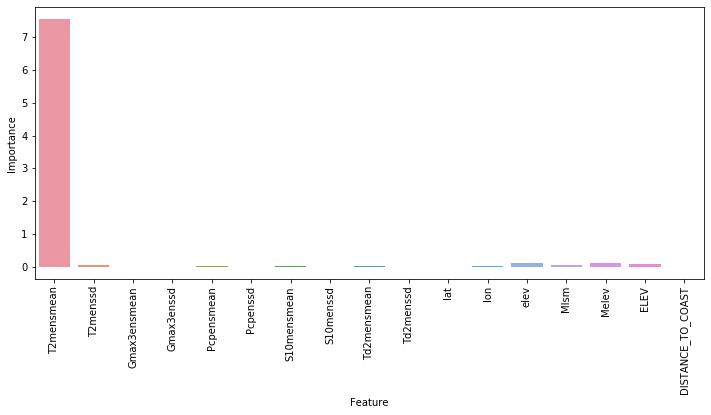

In [0]:
fimp_fc_standardized_model = perm_imp(fc_model)
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_fc_standardized_model, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

## Neural network (NN) model

In [0]:
#NN withour dem
def build_hidden_model(n_features, n_outputs, hidden_nodes, compile=False,
                       optimizer='adam', lr=0.01, loss=crps_cost_function,
                       activation='relu'):
    """Build (and compile) a neural net with hidden layers
    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
    Returns:
        model: Keras model
    """
    if type(hidden_nodes) is not list:
        hidden_nodes = [hidden_nodes]
    inp = Input(shape=(n_features,))
    x = Dense(hidden_nodes[0], activation=activation)(inp)
    if len(hidden_nodes) > 1:
        for h in hidden_nodes[1:]:
            x = Dense(h, activation=activation)(x)
    x = Dense(n_outputs, activation='linear')(x)
    model = Model(inputs=inp, outputs=x)

    if compile:
        opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer=opt, loss=loss)
    return model



In [0]:
input_features =  len(train_standardized_X[0])
print(input_features)
hidden_model = build_hidden_model(input_features, 2, hidden_nodes=[50], compile=True)
hidden_model.summary()

17
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 17)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                900       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 1,002
Trainable params: 1,002
Non-trainable params: 0
_________________________________________________________________


In [0]:

hidden_model.compile(keras.optimizers.Adam(0.001), loss=crps_cost_function)

In [0]:
#Hidden model with distance to coast second run
hidden_model.fit(train_standardized_X, train_y, epochs=500, batch_size = 50,
                 validation_split=0.2, verbose=2, shuffle=False)

Train on 319567 samples, validate on 79892 samples
Epoch 1/500
 - 9s - loss: 46.1752 - val_loss: 2.1597
Epoch 2/500
 - 9s - loss: 1.2560 - val_loss: 1.0176
Epoch 3/500
 - 9s - loss: 1.0204 - val_loss: 1.0026
Epoch 4/500
 - 9s - loss: 1.0130 - val_loss: 0.9985
Epoch 5/500
 - 9s - loss: 1.0102 - val_loss: 0.9971
Epoch 6/500
 - 9s - loss: 1.0084 - val_loss: 0.9956
Epoch 7/500
 - 9s - loss: 1.0071 - val_loss: 0.9944
Epoch 8/500
 - 9s - loss: 1.0057 - val_loss: 0.9943
Epoch 9/500
 - 9s - loss: 1.0041 - val_loss: 0.9939
Epoch 10/500
 - 9s - loss: 1.0026 - val_loss: 0.9928
Epoch 11/500
 - 9s - loss: 1.0014 - val_loss: 0.9924
Epoch 12/500
 - 9s - loss: 1.0005 - val_loss: 0.9906
Epoch 13/500
 - 9s - loss: 0.9998 - val_loss: 0.9898
Epoch 14/500
 - 9s - loss: 0.9991 - val_loss: 0.9899
Epoch 15/500
 - 11s - loss: 0.9985 - val_loss: 0.9893
Epoch 16/500
 - 10s - loss: 0.9980 - val_loss: 0.9889
Epoch 17/500
 - 9s - loss: 0.9975 - val_loss: 0.9882
Epoch 18/500
 - 9s - loss: 0.9971 - val_loss: 0.9877
E

In [0]:
#Hidden model with distance to coast second run
hidden_model.fit(train_standardized_X, train_y, epochs=1000, batch_size = 50,
                 validation_split=0.2, verbose=2, shuffle=False)
                 

Train on 319567 samples, validate on 79892 samples
Epoch 1/1000
 - 8s - loss: 249.6822 - val_loss: 178.9546
Epoch 2/1000
 - 8s - loss: 109.7818 - val_loss: 64.2870
Epoch 3/1000
 - 9s - loss: 43.2719 - val_loss: 30.3723
Epoch 4/1000
 - 9s - loss: 24.5972 - val_loss: 20.3523
Epoch 5/1000
 - 9s - loss: 17.1432 - val_loss: 14.5733
Epoch 6/1000
 - 8s - loss: 12.2083 - val_loss: 10.1955
Epoch 7/1000
 - 8s - loss: 8.2023 - val_loss: 6.4952
Epoch 8/1000
 - 9s - loss: 4.9966 - val_loss: 3.8247
Epoch 9/1000
 - 8s - loss: 2.9900 - val_loss: 2.3961
Epoch 10/1000
 - 8s - loss: 1.9997 - val_loss: 1.7303
Epoch 11/1000
 - 9s - loss: 1.5327 - val_loss: 1.4058
Epoch 12/1000
 - 8s - loss: 1.2946 - val_loss: 1.2327
Epoch 13/1000
 - 8s - loss: 1.1653 - val_loss: 1.1365
Epoch 14/1000
 - 8s - loss: 1.0929 - val_loss: 1.0802
Epoch 15/1000
 - 9s - loss: 1.0485 - val_loss: 1.0439
Epoch 16/1000
 - 8s - loss: 1.0206 - val_loss: 1.0217
Epoch 17/1000
 - 8s - loss: 1.0033 - val_loss: 1.0075
Epoch 18/1000
 - 8s - los

In [0]:
#Hidden model with distance to coast first run
hidden_model.fit(train_standardized_X, train_y, epochs=500, batch_size=50,
                 validation_split=0.2, verbose=2, shuffle=False)

Train on 319567 samples, validate on 79892 samples
Epoch 1/500
 - 10s - loss: 45.8794 - val_loss: 3.3386
Epoch 2/500
 - 9s - loss: 1.5484 - val_loss: 1.0622
Epoch 3/500
 - 9s - loss: 1.0326 - val_loss: 0.9992
Epoch 4/500
 - 10s - loss: 0.9947 - val_loss: 0.9800
Epoch 5/500
 - 9s - loss: 0.9813 - val_loss: 0.9689
Epoch 6/500
 - 9s - loss: 0.9748 - val_loss: 0.9619
Epoch 7/500
 - 9s - loss: 0.9706 - val_loss: 0.9570
Epoch 8/500
 - 9s - loss: 0.9672 - val_loss: 0.9530
Epoch 9/500
 - 9s - loss: 0.9645 - val_loss: 0.9492
Epoch 10/500
 - 9s - loss: 0.9621 - val_loss: 0.9459
Epoch 11/500
 - 10s - loss: 0.9599 - val_loss: 0.9434
Epoch 12/500
 - 9s - loss: 0.9580 - val_loss: 0.9412
Epoch 13/500
 - 9s - loss: 0.9563 - val_loss: 0.9399
Epoch 14/500
 - 10s - loss: 0.9545 - val_loss: 0.9385
Epoch 15/500
 - 10s - loss: 0.9532 - val_loss: 0.9382
Epoch 16/500
 - 9s - loss: 0.9522 - val_loss: 0.9372
Epoch 17/500
 - 10s - loss: 0.9513 - val_loss: 0.9362
Epoch 18/500
 - 9s - loss: 0.9506 - val_loss: 0.93

In [0]:
#CRPS of train and test data 500 epochs
(hidden_model.evaluate(train_std_df_X, train_y, batch_size = 50, verbose=0), hidden_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0))

(0.9368772413040665, 0.9359336617660057)

In [0]:
#CRPS of train and test data
(hidden_model.evaluate(train_std_df_X, train_y, batch_size = 50, verbose=0), hidden_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0))

(0.9007043370346846, 0.901690503082637)

In [0]:
#CRPS of train and test data
(hidden_model.evaluate(train_std_df_X, train_y, batch_size = 50, verbose=0), hidden_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0))

(0.9135409698941751, 0.9149033083964621)

## Feature importance for NN model

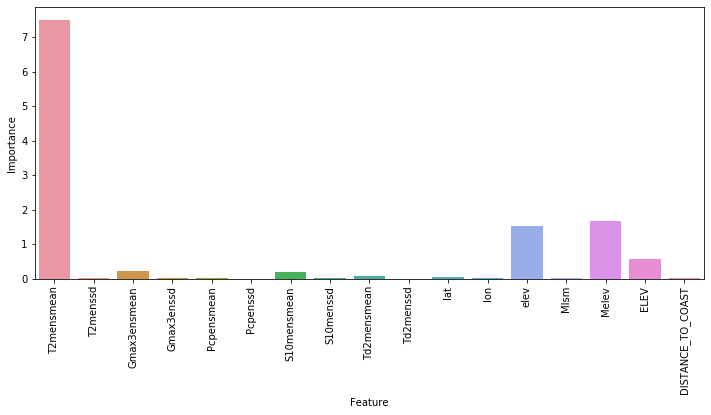

In [0]:
#fimp for nn with distance to coast 500 eposchs

ref_score = hidden_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0)
fimp_nn_standardized_model = perm_imp(hidden_model)
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_nn_standardized_model, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

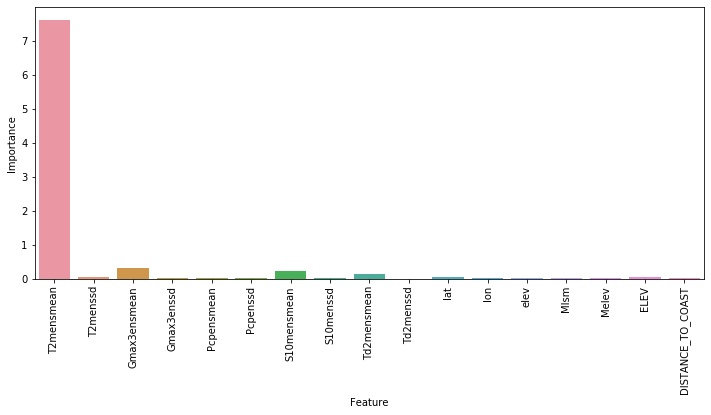

In [0]:
#fimp for nn

ref_score = hidden_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0)
fimp_nn_standardized_model = perm_imp(hidden_model)
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_nn_standardized_model, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

## Feature importance tabular form for FC/LR and NN models

In [0]:
# Feature importance with distance to sea another run
comb_nn_df = pd.DataFrame(data=fimp_nn_standardized_model['Feature']); 
comb_nn_df['nn_std_importance'] = fimp_nn_standardized_model['Importance']
comb_nn_df.sort_values('nn_std_importance', ascending=False, inplace=True)
comb_nn_df['FC/LR_std_importance'] = fimp_fc_standardized_model['Importance']
comb_nn_df.head(30)

,Feature,nn_std_importance,FC/LR_std_importance
0,T2mensmean,7.491544,7.575123
14,Melev,1.669920,0.244884
12,elev,1.540845,0.249420
15,ELEV,0.577780,0.148286
2,Gmax3ensmean,0.216400,0.000452
6,S10mensmean,0.195224,0.003392
8,Td2mensmean,0.088972,0.015786
10,lat,0.041409,0.000755
4,Pcpensmean,0.037772,0.002803
1,T2menssd,0.032478,0.033980


In [0]:
# Feature importance with distance to sea
comb_nn_df = pd.DataFrame(data=fimp_nn_standardized_model['Feature']); 
comb_nn_df['nn_std_importance'] = fimp_nn_standardized_model['Importance']
comb_nn_df.sort_values('nn_std_importance', ascending=False, inplace=True)
comb_nn_df['FC/LR_std_importance'] = fimp_fc_standardized_model['Importance']
comb_nn_df.head(30)

,Feature,nn_std_importance,FC/LR_std_importance
0,T2mensmean,7.615138,7.542875
2,Gmax3ensmean,0.312236,0.000353
6,S10mensmean,0.242472,0.003093
8,Td2mensmean,0.154337,0.013932
15,ELEV,0.071271,0.075314
1,T2menssd,0.060148,0.034437
10,lat,0.043161,0.001148
13,Mlsm,0.041095,0.044669
4,Pcpensmean,0.029478,0.002526
11,lon,0.026473,0.007961


In [0]:
# Feature importance without distance to sea
comb_nn_df = pd.DataFrame(data=fimp_nn_standardized_model['Feature']); 
comb_nn_df['nn_std_importance'] = fimp_nn_standardized_model['Importance']
comb_nn_df.sort_values('nn_std_importance', ascending=False, inplace=True)
comb_nn_df['FC/LR_std_importance'] = fimp_fc_standardized_model['Importance']
comb_nn_df.head(30)

,Feature,nn_std_importance,FC/LR_std_importance
0,T2mensmean,7.647491,7.566781
12,elev,0.597430,0.077926
14,Melev,0.580785,0.110063
15,ELEV,0.207041,0.064466
6,S10mensmean,0.143199,0.004178
2,Gmax3ensmean,0.129359,0.000205
8,Td2mensmean,0.103116,0.014773
1,T2menssd,0.051633,0.032672
10,lat,0.045702,0.000654
11,lon,0.024398,0.007203


In [0]:
comb_nn_df = pd.DataFrame(data=fimp_nn_standardized_model['Feature']); 
comb_nn_df['ens_nn_importance'] = fimp_nn_standardized_model['Importance']
comb_nn_df.sort_values('ens_nn_importance', ascending=False, inplace=True)
comb_nn_df['ens_fc_importance'] = fimp_fc_standardized_model['Importance']
comb_nn_df.head(30)

,Feature,ens_nn_importance,ens_fc_importance
0,T2mensmean,7.647491,7.566781
12,elev,0.597430,0.077926
14,Melev,0.580785,0.110063
15,ELEV,0.207041,0.064466
6,S10mensmean,0.143199,0.004178
2,Gmax3ensmean,0.129359,0.000205
8,Td2mensmean,0.103116,0.014773
1,T2menssd,0.051633,0.032672
10,lat,0.045702,0.000654
11,lon,0.024398,0.007203


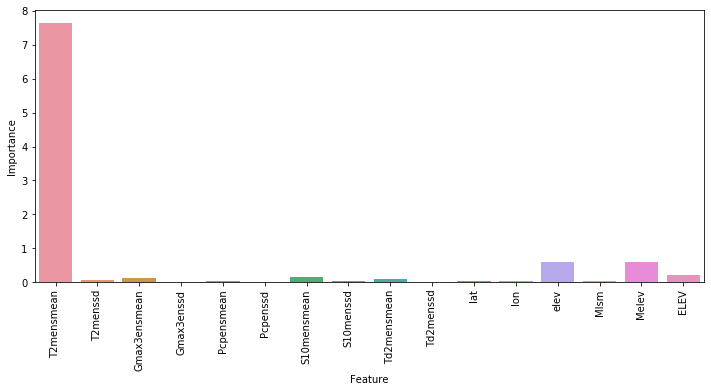

In [0]:

ref_score = hidden_model.evaluate(test_std_df_X, test_y, batch_size = 50, verbose=0)
fimp_nn_standardized_model = perm_imp(hidden_model)
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_nn_standardized_model, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

# Ensemble data with Station data

## This part is needed when new station list is made using the SQLite files. This station file is used a text layer in qgis

In [0]:
# THIS IS NEEDED FOR MAKING THE STATIONS FILE 
data_lat_lon= data[['SID','lat', 'lon']]
data_lat_lon.count()

SID    570657
lat    570657
lon    570657
dtype: int64

In [0]:
# THIS IS NEEDED FOR MAKING THE STATIONS FILE THIS WAS FOR JAN_SEP DATA

data_lat_lon= data[['SID','lat', 'lon']]
data_lat_lon.count()

SID    446108
lat    446108
lon    446108
dtype: int64

In [0]:
data_lat_lon.head(2)

,SID,lat,lon
0,1001,70.9331,-8.6667
1,1001,70.9331,-8.6667


In [0]:
from google.colab import files
data_lat_lon.to_csv('stations_jan_nov19_sid_latlon_utc00+036.csv',header=True,index=False) 
files.download('stations_jan_nov19_sid_latlon_utc00+036.csv')

In [0]:
#just to show how to drop duplicates
data_lat_lon_unique = data_lat_lon.drop_duplicates()
data_lat_lon_unique.count()

## Loading the Staionlist extract which contains the data from DEM files


In [0]:
!rm stationlist_jan_nov19_00+036globecover_extract.csv

In [0]:
# Reading HARPstationlist_extract.csv file
from matplotlib import pyplot
import pandas as pd
import json
import io
#The station data in /home/daniel/calibration/derived_terrain_variables/HARP_station_list/HARPstationlist_extract.csv'
from google.colab import files
uploadedDEM = files.upload()

Saving stationlist_jan_nov19_00+036globecover_extract.csv to stationlist_jan_nov19_00+036globecover_extract.csv


In [0]:
for fn in uploadedDEM.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploadedDEM[fn])))

In [0]:
#Reading the csv file
stations_df = pd.read_csv(io.StringIO(uploadedDEM['stationlist_jan_nov19_00+036globecover_extract.csv'].decode('utf-8')),sep=';')
stations_df.shape

(570657, 111)

In [0]:
null_value_stations= stations_df[pd.isnull(stations_df).any(axis=1)]
null_value_stations.head(10)

In [0]:
stations_df_gc = stations_df[['HARP_globcover_new']]
stations_df_gc.head(2)

,HARP_globcover_new
0,240.0
1,240.0


## Combining ensemble data with station data.


In [0]:
data_derived_vars = pd.concat([data,stations_df],axis = 1)
data_derived_vars.shape

(570657, 134)

## Using the data within the specified coordinates for learning

In [0]:
df =  data_derived_vars[(data_derived_vars['lat'] >= 23.0) & (data_derived_vars['lat'] <= 90.0) & (data_derived_vars['lon'] >= -25.0) & (data_derived_vars['lon'] <=40.0)]
df.shape

(558655, 134)

In [0]:
df_hki = df[df['name'] == 'HELSINKI KAISANIEMI']

In [0]:
df_hki

In [0]:
df['HARP_globcover_new'].values

array([240., 240., 240., ..., 190., 190., 190.])

## The globecover terrain data. Resolution 330 m

In [0]:
df.HARP_globcover_new.value_counts()

20.0     64104
14.0     60274
190.0    44414
150.0    38273
50.0     28864
240.0    26838
30.0     26644
120.0    15039
110.0    12637
90.0     10801
140.0    10069
100.0     8189
70.0      8123
210.0     4898
180.0     4205
200.0     3601
130.0     1757
220.0      684
11.0       457
Name: HARP_globcover_new, dtype: int64

In [0]:
df['HARP_globcover_new'].unique()

array([240., 150., 110.,  70.,  90., 190., 210.,  50., 180., 120., 100.,
       200.,  14.,  20.,  30., 140., 130., 220.,  11.])

In [0]:

#This dataframe contains ensemble mean and sd, SID, HARP_dem_new and HARP_globcover_new. 
#slopes Z, WE, NS, roughness
fc_nn_emb_df = df[['SID', 'HARP_globcover_new','T2mensmean', 'T2menssd',
       'Gmax3ensmean', 'Gmax3enssd', 'Pcpensmean', 'Pcpenssd', 'S10mensmean',
       'S10menssd', 'Td2mensmean', 'Td2menssd', 'obs', 'lat', 'lon', 'elev',
       'Mlsm', 'Melev', 'ELEV', 'DISTANCE_TO_COAST','rough50km',
       'NSABS50km', 'HARP_dem_new_20km', 'NSABS2.5km', 'rough20km', 
       'rough15km', 'rough1km', 
       'WEABS50km', 'HARP_dem_new_500m', 'NSABS20km', 'WEABS7.5km',
       'WEABS12km', 'WEABS15km', 'NSABS7.5km', 'HARP_dem_new_100km',
        'rough2.5km', 'rough500m',  'HARP_dem_new_30km',
       'HARP_dem_new_10km', 'rough10km', 'HARP_dem_new_12km', 
        'NSABS30km', 'WEABS20km', 'rough100km', 
        'rough30km', 'rough5km', 'WEABS5km', 
        'WEABS2.5km', 'WEABS100km', 
       'HARP_dem_new_50km', 'NSABS5km', 'NSABS100km',  'rough12km',
       'HARP_dem_new', 'NSABS1km', 'NSABS12km', 
       'HARP_dem_new_1km', 'HARP_dem_new_7.5km', 'WEABS1km',
       'HARP_dem_new_2.5km', 'HARP_dem_new_5km',  'NSABS15km',
       'WEABS30km', 'WEABS500m', 'NSABS10km', 'WEABS10km',
        'NSABS500m', 'HARP_dem_new_15km',  'rough7.5km', 'ZABS500m','ZABS1km', 'ZABS2.5km','ZABS5km','ZABS7.5km',
        'ZABS10km', 'ZABS12km', 'ZABS20km', 'ZABS30km','ZABS50km','ZABS100km']]
fc_nn_emb_df.shape


(558655, 80)

In [0]:
#NOT USED NOW 
#This dataframe contains ensemble mean and sd, SID, HARP_dem_new. All sds except T2msd are removed 
#slopes Z, WE, NS, roughness
fc_nn_emb_df = df[['SID', 'HARP_globcover_new','T2mensmean', 'T2menssd',
       'Gmax3ensmean', 'Pcpensmean', 'S10mensmean',
       'Td2mensmean', 'obs', 'lat', 'lon', 'elev',
       'Mlsm', 'Melev', 'ELEV', 'rough50km',
       'NSABS50km', 'HARP_dem_new_20km', 'NSABS2.5km', 
        'rough1km', 
        'HARP_dem_new_500m', 
        'rough2.5km', 'rough500m',  
         'rough5km',
        'WEABS2.5km',  'NSABS5km', 
       'HARP_dem_new', 'NSABS1km',
        'NSABS500m', 
       'HARP_dem_new_1km', 'WEABS1km',
       'HARP_dem_new_2.5km', 'HARP_dem_new_5km',
        'WEABS500m', 'ZABS500m','ZABS1km', 'ZABS2.5km','ZABS5km']]
fc_nn_emb_df.shape

(369871, 38)

In [0]:
# For fc and nn data 
drop_cols = ['SID']
fc_nn_df = fc_nn_emb_df.drop(drop_cols,1)
fc_nn_df.shape

(558655, 79)

In [0]:
fc_nn_df.columns

Index(['HARP_globcover_new', 'T2mensmean', 'T2menssd', 'Gmax3ensmean',
       'Gmax3enssd', 'Pcpensmean', 'Pcpenssd', 'S10mensmean', 'S10menssd',
       'Td2mensmean', 'Td2menssd', 'obs', 'lat', 'lon', 'elev', 'Mlsm',
       'Melev', 'ELEV', 'DISTANCE_TO_COAST', 'rough50km', 'NSABS50km',
       'HARP_dem_new_20km', 'NSABS2.5km', 'rough20km', 'rough15km', 'rough1km',
       'WEABS50km', 'HARP_dem_new_500m', 'NSABS20km', 'WEABS7.5km',
       'WEABS12km', 'WEABS15km', 'NSABS7.5km', 'HARP_dem_new_100km',
       'rough2.5km', 'rough500m', 'HARP_dem_new_30km', 'HARP_dem_new_10km',
       'rough10km', 'HARP_dem_new_12km', 'NSABS30km', 'WEABS20km',
       'rough100km', 'rough30km', 'rough5km', 'WEABS5km', 'WEABS2.5km',
       'WEABS100km', 'HARP_dem_new_50km', 'NSABS5km', 'NSABS100km',
       'rough12km', 'HARP_dem_new', 'NSABS1km', 'NSABS12km',
       'HARP_dem_new_1km', 'HARP_dem_new_7.5km', 'WEABS1km',
       'HARP_dem_new_2.5km', 'HARP_dem_new_5km', 'NSABS15km', 'WEABS30km',
       'WEABS5

## Splitting train and test data. Terrain data is used as ensemble data along with SID

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(fc_nn_df, test_size=0.3)
print(train.shape, test.shape)

(391058, 79) (167597, 79)


In [0]:
drop_cols = ['obs','HARP_globcover_new']
train_X = train.drop(drop_cols,1)
train_y = train[['obs']]
train_X.head(2)
train_y.head(2)

,obs
496198,290.7
401759,273.8


In [0]:
type(train_X)

pandas.core.frame.DataFrame

In [0]:
train_X.columns

Index(['T2mensmean', 'T2menssd', 'Gmax3ensmean', 'Gmax3enssd', 'Pcpensmean',
       'Pcpenssd', 'S10mensmean', 'S10menssd', 'Td2mensmean', 'Td2menssd',
       'lat', 'lon', 'elev', 'Mlsm', 'Melev', 'ELEV', 'DISTANCE_TO_COAST',
       'rough50km', 'NSABS50km', 'HARP_dem_new_20km', 'NSABS2.5km',
       'rough20km', 'rough15km', 'rough1km', 'WEABS50km', 'HARP_dem_new_500m',
       'NSABS20km', 'WEABS7.5km', 'WEABS12km', 'WEABS15km', 'NSABS7.5km',
       'HARP_dem_new_100km', 'rough2.5km', 'rough500m', 'HARP_dem_new_30km',
       'HARP_dem_new_10km', 'rough10km', 'HARP_dem_new_12km', 'NSABS30km',
       'WEABS20km', 'rough100km', 'rough30km', 'rough5km', 'WEABS5km',
       'WEABS2.5km', 'WEABS100km', 'HARP_dem_new_50km', 'NSABS5km',
       'NSABS100km', 'rough12km', 'HARP_dem_new', 'NSABS1km', 'NSABS12km',
       'HARP_dem_new_1km', 'HARP_dem_new_7.5km', 'WEABS1km',
       'HARP_dem_new_2.5km', 'HARP_dem_new_5km', 'NSABS15km', 'WEABS30km',
       'WEABS500m', 'NSABS10km', 'WEABS10km', 'NSA

In [0]:
train_X.shape

(391058, 77)

In [0]:
drop_cols = ['obs','HARP_globcover_new']
test_X = test.drop(drop_cols,1)
test_y = test[['obs']]
test_X.head(2)
test_y.head(2)

,obs
546804,283.4
451652,301.6


In [0]:
(train_X.shape, test_X.shape)

((391058, 77), (167597, 77))

## Scaling and standardizing

In [0]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler = StandardScaler()
# fit scaler on train data
scaler.fit(train_X)
# apply transform
train_standardized_X  = scaler.transform(train_X)
# fit scaler on test data
scaler.fit(test_X)
# apply transform
test_standardized_X  = scaler.transform(test_X)


## Standardized data as a dataframe with column names


In [0]:
train_std_df_X = pd.DataFrame(train_standardized_X)
test_std_df_X = pd.DataFrame(test_standardized_X)
train_std_df_X.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76
0,-0.102912,-0.134835,0.000477,-0.086820,-0.555629,-0.660000,0.016293,-0.037377,-0.298455,-0.319825,0.911409,0.842482,-0.658243,0.069803,-0.771223,-0.166989,-0.891883,-0.869853,-0.161220,-0.694557,0.004645,-0.830716,0.0,-0.539798,0.040728,-0.659961,-0.119372,0.035453,-0.018962,0.0,-0.082527,-0.708953,-0.612018,-0.521247,-0.715877,-0.674487,-0.739678,-0.666778,-0.118762,-0.027946,-0.938885,-0.835628,-0.665437,0.002794,-0.004912,-0.006396,-0.699536,-0.069081,-0.140794,-0.765231,-0.655499,-0.053397,-0.094724,-0.658216,-0.684260,-0.063916,-0.659665,-0.677357,0.0,-0.100354,0.072182,-0.114851,0.004051,-0.028446,0.0,-0.713689,-0.473408,-0.494477,-0.539025,-0.581362,-0.596511,-0.623856,-0.643012,-0.725488,-0.702860,-0.725563,-0.842355
1,-1.637840,0.842364,-0.578232,0.592907,1.273227,2.178898,-0.724464,0.350430,-0.317857,0.095358,-0.602653,1.009833,2.898513,0.591679,1.513965,-2.369043,0.449898,0.940972,-1.354967,2.119204,-1.224179,1.273280,0.0,1.514482,-1.025754,2.928784,-1.732628,1.028736,-0.822370,0.0,-3.055616,0.339364,1.209332,2.326266,1.695173,1.941548,0.417535,1.865195,-1.589037,0.407294,0.166469,0.753729,1.015740,1.285460,0.650885,-1.513506,1.894148,-2.322255,-0.688221,0.544584,2.922720,1.741977,-1.296403,3.041702,2.498253,2.578015,2.588937,2.335637,0.0,1.834395,3.255005,-1.036859,0.346145,-1.141744,0.0,1.524748,1.766909,1.810786,0.655090,1.688263,2.189867,0.293080,0.632747,0.935103,1.309083,0.722617,0.480570


In [0]:
train_std_df_X.columns = ['T2mensmean', 'T2menssd', 'Gmax3ensmean', 'Gmax3enssd', 'Pcpensmean',
       'Pcpenssd', 'S10mensmean', 'S10menssd', 'Td2mensmean', 'Td2menssd',
       'lat', 'lon', 'elev', 'Mlsm', 'Melev', 'ELEV', 'DISTANCE_TO_COAST','rough50km', 'NSABS50km',
       'HARP_dem_new_20km', 'NSABS2.5km', 'rough20km', 'rough15km', 'rough1km',
       'WEABS50km', 'HARP_dem_new_500m', 'NSABS20km', 'WEABS7.5km',
       'WEABS12km', 'WEABS15km', 'NSABS7.5km', 'HARP_dem_new_100km',
       'rough2.5km', 'rough500m', 'HARP_dem_new_30km', 'HARP_dem_new_10km',
       'rough10km', 'HARP_dem_new_12km', 'NSABS30km', 'WEABS20km',
       'rough100km', 'rough30km', 'rough5km', 'WEABS5km', 'WEABS2.5km',
       'WEABS100km', 'HARP_dem_new_50km', 'NSABS5km', 'NSABS100km',
       'rough12km', 'HARP_dem_new', 'NSABS1km', 'NSABS12km',
       'HARP_dem_new_1km', 'HARP_dem_new_7.5km', 'WEABS1km',
       'HARP_dem_new_2.5km', 'HARP_dem_new_5km', 'NSABS15km', 'WEABS30km',
       'WEABS500m', 'NSABS10km', 'WEABS10km', 'NSABS500m', 'HARP_dem_new_15km',
       'rough7.5km', 'ZABS500m', 'ZABS1km', 'ZABS2.5km', 'ZABS5km',
       'ZABS7.5km', 'ZABS10km', 'ZABS12km', 'ZABS20km', 'ZABS30km', 'ZABS50km','ZABS100km']





train_std_df_X.head(2)

,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,lat,lon,elev,Mlsm,Melev,ELEV,DISTANCE_TO_COAST,rough50km,NSABS50km,HARP_dem_new_20km,NSABS2.5km,rough20km,rough15km,rough1km,WEABS50km,HARP_dem_new_500m,NSABS20km,WEABS7.5km,WEABS12km,WEABS15km,NSABS7.5km,HARP_dem_new_100km,rough2.5km,rough500m,HARP_dem_new_30km,HARP_dem_new_10km,rough10km,HARP_dem_new_12km,NSABS30km,WEABS20km,rough100km,rough30km,rough5km,WEABS5km,WEABS2.5km,WEABS100km,HARP_dem_new_50km,NSABS5km,NSABS100km,rough12km,HARP_dem_new,NSABS1km,NSABS12km,HARP_dem_new_1km,HARP_dem_new_7.5km,WEABS1km,HARP_dem_new_2.5km,HARP_dem_new_5km,NSABS15km,WEABS30km,WEABS500m,NSABS10km,WEABS10km,NSABS500m,HARP_dem_new_15km,rough7.5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,ZABS7.5km,ZABS10km,ZABS12km,ZABS20km,ZABS30km,ZABS50km,ZABS100km
0,-0.102912,-0.134835,0.000477,-0.086820,-0.555629,-0.660000,0.016293,-0.037377,-0.298455,-0.319825,0.911409,0.842482,-0.658243,0.069803,-0.771223,-0.166989,-0.891883,-0.869853,-0.161220,-0.694557,0.004645,-0.830716,0.0,-0.539798,0.040728,-0.659961,-0.119372,0.035453,-0.018962,0.0,-0.082527,-0.708953,-0.612018,-0.521247,-0.715877,-0.674487,-0.739678,-0.666778,-0.118762,-0.027946,-0.938885,-0.835628,-0.665437,0.002794,-0.004912,-0.006396,-0.699536,-0.069081,-0.140794,-0.765231,-0.655499,-0.053397,-0.094724,-0.658216,-0.684260,-0.063916,-0.659665,-0.677357,0.0,-0.100354,0.072182,-0.114851,0.004051,-0.028446,0.0,-0.713689,-0.473408,-0.494477,-0.539025,-0.581362,-0.596511,-0.623856,-0.643012,-0.725488,-0.702860,-0.725563,-0.842355
1,-1.637840,0.842364,-0.578232,0.592907,1.273227,2.178898,-0.724464,0.350430,-0.317857,0.095358,-0.602653,1.009833,2.898513,0.591679,1.513965,-2.369043,0.449898,0.940972,-1.354967,2.119204,-1.224179,1.273280,0.0,1.514482,-1.025754,2.928784,-1.732628,1.028736,-0.822370,0.0,-3.055616,0.339364,1.209332,2.326266,1.695173,1.941548,0.417535,1.865195,-1.589037,0.407294,0.166469,0.753729,1.015740,1.285460,0.650885,-1.513506,1.894148,-2.322255,-0.688221,0.544584,2.922720,1.741977,-1.296403,3.041702,2.498253,2.578015,2.588937,2.335637,0.0,1.834395,3.255005,-1.036859,0.346145,-1.141744,0.0,1.524748,1.766909,1.810786,0.655090,1.688263,2.189867,0.293080,0.632747,0.935103,1.309083,0.722617,0.480570


In [0]:
test_std_df_X.columns = ['T2mensmean', 'T2menssd', 'Gmax3ensmean', 'Gmax3enssd', 'Pcpensmean',
       'Pcpenssd', 'S10mensmean', 'S10menssd', 'Td2mensmean', 'Td2menssd',
       'lat', 'lon', 'elev', 'Mlsm', 'Melev','DISTANCE_TO_COAST', 'ELEV', 'rough50km', 'NSABS50km',
       'HARP_dem_new_20km', 'NSABS2.5km', 'rough20km', 'rough15km', 'rough1km',
       'WEABS50km', 'HARP_dem_new_500m', 'NSABS20km', 'WEABS7.5km',
       'WEABS12km', 'WEABS15km', 'NSABS7.5km', 'HARP_dem_new_100km',
       'rough2.5km', 'rough500m', 'HARP_dem_new_30km', 'HARP_dem_new_10km',
       'rough10km', 'HARP_dem_new_12km', 'NSABS30km', 'WEABS20km',
       'rough100km', 'rough30km', 'rough5km', 'WEABS5km', 'WEABS2.5km',
       'WEABS100km', 'HARP_dem_new_50km', 'NSABS5km', 'NSABS100km',
       'rough12km', 'HARP_dem_new', 'NSABS1km', 'NSABS12km',
       'HARP_dem_new_1km', 'HARP_dem_new_7.5km', 'WEABS1km',
       'HARP_dem_new_2.5km', 'HARP_dem_new_5km', 'NSABS15km', 'WEABS30km',
       'WEABS500m', 'NSABS10km', 'WEABS10km', 'NSABS500m', 'HARP_dem_new_15km',
       'rough7.5km', 'ZABS500m', 'ZABS1km', 'ZABS2.5km', 'ZABS5km',
       'ZABS7.5km', 'ZABS10km', 'ZABS12km', 'ZABS20km', 'ZABS30km', 'ZABS50km','ZABS100km']





test_std_df_X.head(2)

,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,lat,lon,elev,Mlsm,Melev,DISTANCE_TO_COAST,ELEV,rough50km,NSABS50km,HARP_dem_new_20km,NSABS2.5km,rough20km,rough15km,rough1km,WEABS50km,HARP_dem_new_500m,NSABS20km,WEABS7.5km,WEABS12km,WEABS15km,NSABS7.5km,HARP_dem_new_100km,rough2.5km,rough500m,HARP_dem_new_30km,HARP_dem_new_10km,rough10km,HARP_dem_new_12km,NSABS30km,WEABS20km,rough100km,rough30km,rough5km,WEABS5km,WEABS2.5km,WEABS100km,HARP_dem_new_50km,NSABS5km,NSABS100km,rough12km,HARP_dem_new,NSABS1km,NSABS12km,HARP_dem_new_1km,HARP_dem_new_7.5km,WEABS1km,HARP_dem_new_2.5km,HARP_dem_new_5km,NSABS15km,WEABS30km,WEABS500m,NSABS10km,WEABS10km,NSABS500m,HARP_dem_new_15km,rough7.5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,ZABS7.5km,ZABS10km,ZABS12km,ZABS20km,ZABS30km,ZABS50km,ZABS100km
0,-1.244347,0.053340,0.182290,1.222631,-0.424615,-0.445967,1.154078,1.526916,-1.372226,4.016719,-0.437009,1.972602,-0.533854,-0.980158,-0.762692,-0.359420,-0.919992,-0.577481,-0.344390,-0.693827,0.033936,-0.628834,0.0,-0.618770,-0.246873,-0.684586,-0.343962,-0.268630,-0.273034,0.0,-0.259373,-0.750038,-0.416218,-0.608191,-0.665788,-0.71003,-0.592195,-0.694238,-0.359157,-0.241845,-0.717862,-0.663636,-0.592568,-0.029903,-0.002451,-0.056050,-0.687587,-0.020782,-0.508892,-0.618391,-0.681771,0.022514,-0.067620,-0.684799,-0.697246,-0.003552,-0.690733,-0.703625,0.0,-0.001140,0.045093,-0.053328,-0.248781,0.058194,0.0,-0.571161,-0.559181,-0.577710,-0.564647,-0.634223,-0.372990,-0.510468,-0.508185,-0.451540,-0.490461,-0.502988,-0.481716
1,1.335908,-1.121035,-0.182825,-0.319310,-0.601989,-0.770180,-0.784336,-0.511216,1.513082,0.310246,-1.841884,0.919335,0.049595,0.561141,0.133573,0.136956,-0.817879,0.231075,-0.063733,-0.078710,0.200355,0.856843,0.0,-0.383928,-1.239857,0.099799,0.593007,5.284804,2.114369,0.0,0.649764,0.382634,-0.141555,-0.418675,1.360758,-0.01292,1.423923,0.417359,-0.066542,0.284045,-0.054861,1.005774,0.742594,0.482133,0.813343,1.421622,-0.297556,-0.765019,-0.101058,1.069769,0.085562,0.294152,0.783897,0.104888,0.310570,0.300098,0.113981,0.091406,0.0,1.615588,0.345387,0.628154,1.441763,0.147145,0.0,2.594949,-0.353151,-0.250369,0.039705,0.146753,3.648328,0.565379,1.165475,-0.106538,0.459475,0.108076,0.358350


In [0]:
input_features =  len(train_standardized_X[0])
print(input_features)
fc_model =build_fc_model(input_features, 2, compile=True)
fc_model.summary()

77
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 77)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 156       
Total params: 156
Trainable params: 156
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = fc_model.fit(train_standardized_X, train_y, epochs=500, batch_size=50, validation_split=0.2, verbose=2, shuffle=False)

Train on 312846 samples, validate on 78212 samples
Epoch 1/500
 - 8s - loss: 251.6715 - val_loss: 219.6719
Epoch 2/500
 - 8s - loss: 202.6159 - val_loss: 191.9910
Epoch 3/500
 - 8s - loss: 187.1829 - val_loss: 183.9046
Epoch 4/500
 - 8s - loss: 180.8814 - val_loss: 178.3106
Epoch 5/500
 - 8s - loss: 175.5981 - val_loss: 173.2228
Epoch 6/500
 - 8s - loss: 170.7002 - val_loss: 168.4416
Epoch 7/500
 - 8s - loss: 166.0273 - val_loss: 163.8371
Epoch 8/500
 - 8s - loss: 161.4831 - val_loss: 159.3341
Epoch 9/500
 - 8s - loss: 157.0166 - val_loss: 154.8883
Epoch 10/500
 - 8s - loss: 152.5895 - val_loss: 150.4706
Epoch 11/500
 - 8s - loss: 148.1753 - val_loss: 146.0416
Epoch 12/500
 - 8s - loss: 143.7577 - val_loss: 141.6243
Epoch 13/500
 - 9s - loss: 139.3773 - val_loss: 137.2607
Epoch 14/500
 - 8s - loss: 135.0340 - val_loss: 132.9207
Epoch 15/500
 - 8s - loss: 130.7159 - val_loss: 128.6159
Epoch 16/500
 - 8s - loss: 126.4244 - val_loss: 124.3301
Epoch 17/500
 - 9s - loss: 122.1435 - val_loss

In [0]:
# Returns the loss value & metrics values for the model in test mode with distance to coast and station variables.
(fc_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
fc_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.9616966848378803, 0.9623634539023966)

In [0]:
# Returns the loss value & metrics values for the model in test mode with distance to coast and station variables.
(fc_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
fc_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.9601953895317261, 0.9591512852960065)

In [0]:
# Returns the loss value & metrics values for the model in test mode.
(fc_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
fc_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.9603228501634156, 0.959699371769692)

In [0]:
# Returns the loss value & metrics values for the model in test mode.
(fc_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
fc_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.9843495347281863, 0.9851493164095265)

## FC/LR calibration fc_model with variables except laplacian, variance

In [0]:
#from ppnn paper
def build_fc_model(n_features, n_outputs, compile=False, optimizer='adam',
                   lr=0.1, loss=crps_cost_function):
    """Build (and compile) fully connected linear network.

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function

    Returns:
        model: Keras model
    """

    inp = Input(shape=(n_features,))
    x = Dense(n_outputs, activation='linear')(inp)
    model = Model(inputs=inp, outputs=x)

    if compile:
        #opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer='adam', loss=loss)
    return model

In [0]:
#cols = train_standardized_X.columns

len(train_standardized_X[0])

76

In [0]:
input_features =  len(train_standardized_X[0])
print(input_features)
fc_model =build_fc_model(input_features, 2, compile=True)
fc_model.summary()

76
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 76)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 154       
Total params: 154
Trainable params: 154
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = fc_model.fit(train_standardized_X, train_y, epochs=200, batch_size=50, validation_split=0.2, verbose=2, shuffle=False)

Train on 207127 samples, validate on 51782 samples
Epoch 1/200
 - 5s - loss: 264.5504 - val_loss: 240.5492
Epoch 2/200
 - 5s - loss: 221.9466 - val_loss: 207.4192
Epoch 3/200
 - 5s - loss: 198.9147 - val_loss: 193.0223
Epoch 4/200
 - 5s - loss: 189.4523 - val_loss: 187.0158
Epoch 5/200
 - 5s - loss: 184.8063 - val_loss: 183.1119
Epoch 6/200
 - 5s - loss: 181.0912 - val_loss: 179.5617
Epoch 7/200
 - 5s - loss: 177.6302 - val_loss: 176.2168
Epoch 8/200
 - 5s - loss: 174.3496 - val_loss: 173.0228
Epoch 9/200
 - 5s - loss: 171.2050 - val_loss: 169.9396
Epoch 10/200
 - 5s - loss: 168.1570 - val_loss: 166.9330
Epoch 11/200
 - 5s - loss: 165.1723 - val_loss: 163.9718
Epoch 12/200
 - 5s - loss: 162.2272 - val_loss: 161.0389
Epoch 13/200
 - 5s - loss: 159.3113 - val_loss: 158.1297
Epoch 14/200
 - 5s - loss: 156.4195 - val_loss: 155.2408
Epoch 15/200
 - 5s - loss: 153.5455 - val_loss: 152.3653
Epoch 16/200
 - 5s - loss: 150.6839 - val_loss: 149.4991
Epoch 17/200
 - 5s - loss: 147.8299 - val_loss

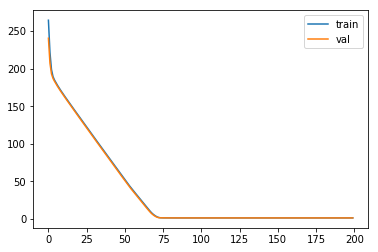

In [0]:
#plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()


In [0]:
pred = fc_model.predict(test_standardized_X)


In [0]:
pred_df_fc = pd.DataFrame(pred, columns = ['cal_mean' , 'cal_sd'])

pred_df_fc.head(2)

,cal_mean,cal_sd
0,280.787018,2.368985
1,288.803741,0.653882


In [0]:
# Returns the loss value & metrics values for the model in test mode.
(fc_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
fc_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(1.0317199961673515, 1.0335742286912482)

In [0]:
test_ens = test_X[['T2mensmean', 'T2menssd']]
len(test_ens)
test_ens.index = range(len(test_ens)) 
test_ens.head(2)

,T2mensmean,T2menssd
0,280.455280,1.044909
1,287.849408,0.327882


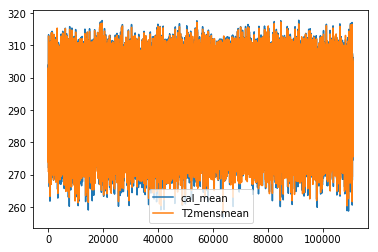

In [0]:
#plot history
pyplot.plot(pred_df_fc['cal_mean'], label='cal_mean')
pyplot.plot(test_ens['T2mensmean'], label='T2mensmean')
pyplot.legend()
pyplot.show()


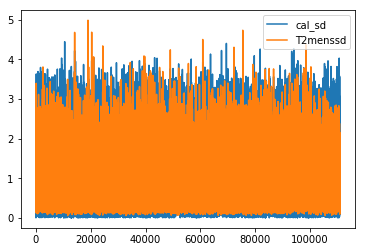

In [0]:
#plot history
pyplot.plot(abs(pred_df_fc['cal_sd']), label='cal_sd')
pyplot.plot(test_ens['T2menssd'], label='T2menssd')
pyplot.legend()
pyplot.show()

In [0]:
(np.mean(pred_df_fc['cal_mean']), np.mean(test_ens['T2mensmean']))

NameError: ignored

In [0]:
(np.mean(pred_df_fc['cal_sd']), np.mean(test_ens['T2menssd']))


(1.098748803138733, 0.9043621455806696)

## Feature importance code from RASP paper for FC/LR and NN

In [0]:
ref_score = fc_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0)
ref_score

0.959699371769692

In [0]:
#Feature importance for standardized scaled
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# slice error add iloc
def eval_shuf(m, idx, emb=False):
    x_shuf = test_std_df_X.copy()
    x_shuf.iloc[:, idx] = np.random.permutation(x_shuf.iloc[:, idx])
    x = x_shuf
    return m.evaluate(x, test_y, 4096, 0)
def perm_imp(m):
    scores = [eval_shuf(m, i) for i in range(len(test_X.columns))]
    fimp = np.array(scores) - ref_score
    df = pd.DataFrame(columns=['Feature', 'Importance'])
    df['Feature'] = test_std_df_X.columns; df['Importance'] = fimp
    return df
def perm_imp(m):
    scores = [eval_shuf(m, i) for i in range(len(test_X.columns))]
    fimp = np.array(scores) - ref_score
    df = pd.DataFrame(columns=['Feature', 'Importance'])
    df['Feature'] = test_std_df_X.columns; df['Importance'] = fimp
    return df


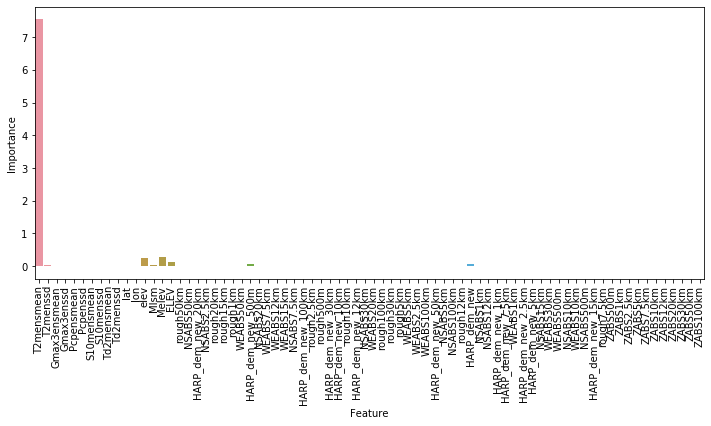

In [0]:
fimp_fc_standardized_model = perm_imp(fc_model)
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_fc_standardized_model, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

## Neural net calibration almost all variables eexcept laplacian and variance

In [0]:
def build_hidden_model(n_features, n_outputs, hidden_nodes, compile=False,
                       optimizer='adam', lr=0.01, loss=crps_cost_function,
                       activation='relu'):
    """Build (and compile) a neural net with hidden layers
    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
    Returns:
        model: Keras model
    """
    if type(hidden_nodes) is not list:
        hidden_nodes = [hidden_nodes]
    inp = Input(shape=(n_features,))
    x = Dense(hidden_nodes[0], activation=activation)(inp)
    if len(hidden_nodes) > 1:
        for h in hidden_nodes[1:]:
            x = Dense(h, activation=activation)(x)
    x = Dense(n_outputs, activation='linear')(x)
    model = Model(inputs=inp, outputs=x)

    if compile:
        opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer=opt, loss=loss)
    return model

In [0]:
input_features =  len(train_X.columns)
print(input_features)
hidden_model = build_hidden_model(input_features, 2, hidden_nodes=[80,70,50], compile=True)
hidden_model.summary()


77
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 77)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 80)                6240      
_________________________________________________________________
dense_6 (Dense)              (None, 70)                5670      
_________________________________________________________________
dense_7 (Dense)              (None, 50)                3550      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 102       
Total params: 15,562
Trainable params: 15,562
Non-trainable params: 0
_________________________________________________________________


In [0]:
hidden_model.compile(keras.optimizers.Adam(0.001), loss=crps_cost_function)

In [0]:
hidden_model.fit(train_standardized_X, train_y, epochs=500, batch_size=50,
                 validation_split=0.2, verbose=2, shuffle=False)

Train on 312846 samples, validate on 78212 samples
Epoch 1/500
 - 11s - loss: 7.3604 - val_loss: 1.5279
Epoch 2/500
 - 10s - loss: 1.4724 - val_loss: 1.3799
Epoch 3/500
 - 11s - loss: 1.3631 - val_loss: 1.2477
Epoch 4/500
 - 11s - loss: 1.3041 - val_loss: 1.3224
Epoch 5/500
 - 10s - loss: 1.2640 - val_loss: 1.2759
Epoch 6/500
 - 10s - loss: 1.2338 - val_loss: 1.2292
Epoch 7/500
 - 10s - loss: 1.2113 - val_loss: 1.0909
Epoch 8/500
 - 10s - loss: 1.1899 - val_loss: 1.0660
Epoch 9/500
 - 10s - loss: 1.1684 - val_loss: 1.1332
Epoch 10/500
 - 11s - loss: 1.1496 - val_loss: 1.2010
Epoch 11/500
 - 11s - loss: 1.1280 - val_loss: 1.1727
Epoch 12/500
 - 10s - loss: 1.1060 - val_loss: 1.1380
Epoch 13/500
 - 10s - loss: 1.0869 - val_loss: 1.0578
Epoch 14/500
 - 10s - loss: 1.0625 - val_loss: 1.0150
Epoch 15/500
 - 10s - loss: 1.0355 - val_loss: 0.9713
Epoch 16/500
 - 10s - loss: 1.0106 - val_loss: 0.9672
Epoch 17/500
 - 10s - loss: 0.9900 - val_loss: 0.9474
Epoch 18/500
 - 10s - loss: 0.9720 - val

In [0]:
# Returns the loss value & metrics values for the model in test mode. 10.5 months data 80, 70,50 NN with distance to coast
(hidden_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0)
#The output is 0.878 0.876. More layers not helping low CRPS)

In [0]:
# Returns the loss value & metrics values for the model in test mode. 10.5 months data 80, 70 NN with distance to coast
(hidden_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.8356111080437677, 0.8598942351984818)

In [0]:
# Returns the loss value & metrics values for the model in test mode. 10.5 months data 80, 50 NN with distance to coast
(hidden_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.8587909750173419, 0.8839153265775527)

In [0]:
# Returns the loss value & metrics values for the model in test mode. 10.5 months data 80, 70 NN
(hidden_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.8857979069162563, 0.8961141107428721)

In [0]:
# Returns the loss value & metrics values for the model in test mode. 10.5 months data 70,50 30 NN
(hidden_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.8943652104138651, 0.903908864319034)

In [0]:
# Returns the loss value & metrics values for the model in test mode. 10.5 months data 70,50 NN
(hidden_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.8881670517520013, 0.8963960469691254)

In [0]:
# Returns the loss value & metrics values for the model in test mode. 10.5 months data 50 NN
(hidden_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.9386344108610735, 0.9447154365144975)

In [0]:
# Returns the loss value & metrics values for the model in test mode. 10.5 months data 100 NN
(hidden_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.8936068476633746, 0.9018028810610261)

In [0]:
# Returns the loss value & metrics values for the model in test mode. 9 months data
(hidden_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.8824750248895475, 0.8920524704632635)

In [0]:
# Returns the loss value & metrics values for the model in test mode.
(hidden_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.8823914956182098, 0.9003548862253806)

In [0]:
# Returns the loss value & metrics values for the model in test mode.
(hidden_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.9185022465076546, 0.9355584858152737)

In [0]:
pred_nn = hidden_model.predict(test_standardized_X)
pred_df_nn = pd.DataFrame(pred_nn, columns = ['cal_mean' , 'cal_sd'])
pred_df_nn.head(2)

,cal_mean,cal_sd
0,281.171997,1.648149
1,287.515076,1.268083


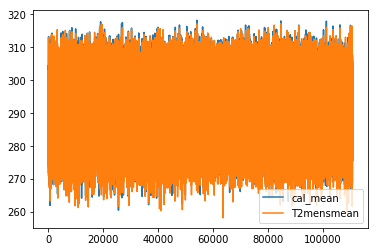

In [0]:
#plot history
pyplot.plot(pred_df_nn['cal_mean'], label='cal_mean')
pyplot.plot(test_ens['T2mensmean'], label='T2mensmean')
pyplot.legend()
pyplot.show()

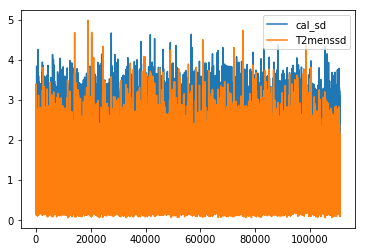

In [0]:

#plot history
pyplot.plot(abs(pred_df_nn['cal_sd']), label='cal_sd')
pyplot.plot(test_ens['T2menssd'], label='T2menssd')
pyplot.legend()
pyplot.show()

In [0]:
(np.mean(pred_df_nn['cal_mean']), np.mean(test_ens['T2mensmean']))

(292.2786865234375, 291.73732163117165)

In [0]:
(np.mean(pred_df_nn['cal_sd']), np.mean(test_ens['T2menssd']))

(1.6209402084350586, 0.9043621455806696)

In [0]:
# Get the reference score from the last model we trained Jan-Sep 19

# Returns the loss value & metrics values for the model in test mode.
(hidden_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))
ref_score = hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0)
ref_score

0.8598942351984818

In [0]:
#Feature importance jan-nov 19 distance to coast 80,70 NN

fimp_nn_standardized_model = perm_imp(hidden_model) 
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_nn_standardized_model, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

ValueError: ignored

In [0]:
# Get the reference score from the last model we trained

# Returns the loss value & metrics values for the model in test mode.
(hidden_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))
ref_score = hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0)
ref_score

ValueError: ignored

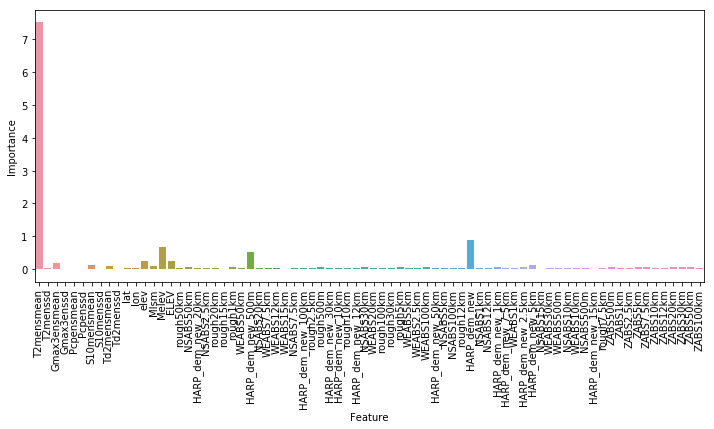

In [0]:
fimp_nn_standardized_model = perm_imp(hidden_model)
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_fc_nn_standardized_model, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

In [0]:
#Feature importance with distance to coast 80,70 NN
comb_nn_df = pd.DataFrame(data=fimp_nn_standardized_model['Feature']); 
comb_nn_df['ens_nnd_importance'] = fimp_nn_standardized_model['Importance']
comb_nn_df.sort_values('ens_nnd_importance', ascending=False, inplace=True)
comb_nn_df.head(30)

,Feature,ens_nnd_importance
0,T2mensmean,7.874766
57,HARP_dem_new_5km,0.474731
14,Melev,0.356883
54,HARP_dem_new_7.5km,0.293213
2,Gmax3ensmean,0.272761
12,elev,0.261574
15,DISTANCE_TO_COAST,0.254563
33,rough500m,0.239003
8,Td2mensmean,0.218133
37,HARP_dem_new_12km,0.216195


In [0]:
comb_nn_df['ens_fcd_importance'] = fimp_fc_standardized_model['Importance']
comb_nn_df.head(30)

,Feature,ens_nnd_importance,ens_fcd_importance
0,T2mensmean,7.636709,7.554488
12,elev,0.252584,0.259735
24,HARP_dem_new_500m,0.193320,0.078953
49,HARP_dem_new,0.068705,0.056561
2,Gmax3ensmean,0.067362,0.000497
71,ZABS12km,0.060687,0.000176
56,HARP_dem_new_5km,0.059548,0.001598
15,ELEV,0.053738,0.119819
13,Mlsm,0.052261,0.044647
74,ZABS50km,0.046864,0.000247


In [0]:
comb_nn_df['ens_fcd_importance'] = fimp_fc_standardized_model['Importance']
comb_nn_df.head(30)

,Feature,ens_nnd_importance,ens_fcd_importance
0,T2mensmean,7.220600,7.130738
49,HARP_dem_new,1.062568,0.104819
24,HARP_dem_new_500m,0.448623,0.136746
12,elev,0.325091,0.371868
13,Mlsm,0.271459,0.127521
74,ZABS50km,0.205424,0.093176
70,ZABS10km,0.163063,0.092956
72,ZABS20km,0.159881,0.092819
71,ZABS12km,0.151378,0.092664
65,ZABS500m,0.144456,0.094202


## NN model with reduced variables

In [0]:

def build_hidden_model(n_features, n_outputs, hidden_nodes, compile=False,
                       optimizer='adam', lr=0.01, loss=crps_cost_function,
                       activation='relu'):
    """Build (and compile) a neural net with hidden layers
    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
    Returns:
        model: Keras model
    """
    if type(hidden_nodes) is not list:
        hidden_nodes = [hidden_nodes]
    inp = Input(shape=(n_features,))
    x = Dense(hidden_nodes[0], activation=activation)(inp)
    if len(hidden_nodes) > 1:
        for h in hidden_nodes[1:]:
            x = Dense(h, activation=activation)(x)
    x = Dense(n_outputs, activation='linear')(x)
    model = Model(inputs=inp, outputs=x)

    if compile:
        opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer=opt, loss=loss)
    return model



In [0]:
input_features =  len(train_X.columns)
print(input_features)
hidden_model = build_hidden_model(input_features, 2, hidden_nodes=[50], compile=True)
hidden_model.summary()

35
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 35)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 50)                1800      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 102       
Total params: 1,902
Trainable params: 1,902
Non-trainable params: 0
_________________________________________________________________


In [0]:
hidden_model.compile(keras.optimizers.Adam(0.001), loss=crps_cost_function)

In [0]:
hidden_model.fit(train_standardized_X, train_y, epochs=500, batch_size=50,
                 validation_split=0.2, verbose=2, shuffle=False)

Train on 207127 samples, validate on 51782 samples
Epoch 1/500
 - 6s - loss: 65.7056 - val_loss: 8.8807
Epoch 2/500
 - 5s - loss: 3.7965 - val_loss: 1.7754
Epoch 3/500
 - 5s - loss: 1.4254 - val_loss: 1.2705
Epoch 4/500
 - 5s - loss: 1.1930 - val_loss: 1.1444
Epoch 5/500
 - 6s - loss: 1.1098 - val_loss: 1.0895
Epoch 6/500
 - 6s - loss: 1.0799 - val_loss: 1.0666
Epoch 7/500
 - 6s - loss: 1.0673 - val_loss: 1.0533
Epoch 8/500
 - 6s - loss: 1.0604 - val_loss: 1.0468
Epoch 9/500
 - 6s - loss: 1.0556 - val_loss: 1.0407
Epoch 10/500
 - 6s - loss: 1.0519 - val_loss: 1.0366
Epoch 11/500
 - 6s - loss: 1.0493 - val_loss: 1.0345
Epoch 12/500
 - 6s - loss: 1.0472 - val_loss: 1.0330
Epoch 13/500
 - 6s - loss: 1.0454 - val_loss: 1.0318
Epoch 14/500
 - 6s - loss: 1.0437 - val_loss: 1.0307
Epoch 15/500
 - 6s - loss: 1.0423 - val_loss: 1.0301
Epoch 16/500
 - 6s - loss: 1.0410 - val_loss: 1.0294
Epoch 17/500
 - 6s - loss: 1.0399 - val_loss: 1.0288
Epoch 18/500
 - 6s - loss: 1.0389 - val_loss: 1.0275
Epo

In [0]:
# Returns the loss value & metrics values for the model in test mode.
(hidden_model.evaluate(train_standardized_X, train_y, batch_size = 50, verbose=0),
hidden_model.evaluate(test_standardized_X, test_y, batch_size = 50, verbose=0))

(0.9842062312666688, 0.9946602000099273)

## Embedded FC/LR model

In [0]:
fc_nn_emb_df.shape

(558655, 79)

In [0]:
data =fc_nn_emb_df
data.shape

(558655, 79)

In [0]:
# THIS CELL IS USED FOR SID embedding
data["ID"] = data["SID"]
map_dict = {}
for token, value in enumerate(data['SID'].unique()): 
  #print(token,value)
  map_dict[value] = token
data["ID"] = data["SID"].apply(lambda x: map_dict.get(x))
data.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SID,HARP_globcover_new,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,obs,lat,lon,elev,Mlsm,Melev,ELEV,rough50km,NSABS50km,HARP_dem_new_20km,NSABS2.5km,rough20km,rough15km,rough1km,WEABS50km,HARP_dem_new_500m,NSABS20km,WEABS7.5km,WEABS12km,WEABS15km,NSABS7.5km,HARP_dem_new_100km,rough2.5km,rough500m,HARP_dem_new_30km,HARP_dem_new_10km,rough10km,HARP_dem_new_12km,NSABS30km,WEABS20km,rough100km,rough30km,rough5km,WEABS5km,WEABS2.5km,WEABS100km,HARP_dem_new_50km,NSABS5km,NSABS100km,rough12km,HARP_dem_new,NSABS1km,NSABS12km,HARP_dem_new_1km,HARP_dem_new_7.5km,WEABS1km,HARP_dem_new_2.5km,HARP_dem_new_5km,NSABS15km,WEABS30km,WEABS500m,NSABS10km,WEABS10km,NSABS500m,HARP_dem_new_15km,rough7.5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,ZABS7.5km,ZABS10km,ZABS12km,ZABS20km,ZABS30km,ZABS50km,ZABS100km,ID
0,1001,240.0,272.887625,0.338977,11.261277,0.669280,0.000000,0.000000,6.019736,0.331503,268.977972,0.74219,273.7,70.9331,-8.6667,9.4,0.386374,39.696462,30.296462,0.0,0.0,312.0,-115.0,312.0,0.0,16.0,0.0,0.0,0.0,0.0,-2.0,0.0,-25.0,0.0,358.0,6.0,0.0,0.0,16.0,116.0,0.0,-11.0,0.0,520.0,524.0,-262.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,-5.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,-260.0,0.0,0.0,8.0,0.0,0.0,120.0,0.0,5.0,115.0,262.0,25.0,8.0,2.0,11.0,260.0,0.0,0.0,0
1,1001,240.0,272.504397,0.238677,7.370655,0.728858,0.000016,0.000015,3.943128,0.422621,269.359161,0.31186,273.1,70.9331,-8.6667,9.4,0.386374,39.696462,30.296462,0.0,0.0,312.0,-115.0,312.0,0.0,16.0,0.0,0.0,0.0,0.0,-2.0,0.0,-25.0,0.0,358.0,6.0,0.0,0.0,16.0,116.0,0.0,-11.0,0.0,520.0,524.0,-262.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,-5.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,-260.0,0.0,0.0,8.0,0.0,0.0,120.0,0.0,5.0,115.0,262.0,25.0,8.0,2.0,11.0,260.0,0.0,0.0,0


In [0]:
# THIS CELL IS USED FOR TerrainType embedding
data["TerrainType"] = data["HARP_globcover_new"]
map_dict = {}
for token, value in enumerate(data['HARP_globcover_new'].unique()): 
  #print(token,value)
  map_dict[value] = token
data["TerrainType"] = data["HARP_globcover_new"].apply(lambda x: map_dict.get(x))
data.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,SID,HARP_globcover_new,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,obs,lat,lon,elev,Mlsm,Melev,ELEV,rough50km,NSABS50km,HARP_dem_new_20km,NSABS2.5km,rough20km,rough15km,rough1km,WEABS50km,HARP_dem_new_500m,NSABS20km,WEABS7.5km,WEABS12km,WEABS15km,NSABS7.5km,HARP_dem_new_100km,rough2.5km,rough500m,HARP_dem_new_30km,HARP_dem_new_10km,rough10km,HARP_dem_new_12km,...,WEABS20km,rough100km,rough30km,rough5km,WEABS5km,WEABS2.5km,WEABS100km,HARP_dem_new_50km,NSABS5km,NSABS100km,rough12km,HARP_dem_new,NSABS1km,NSABS12km,HARP_dem_new_1km,HARP_dem_new_7.5km,WEABS1km,HARP_dem_new_2.5km,HARP_dem_new_5km,NSABS15km,WEABS30km,WEABS500m,NSABS10km,WEABS10km,NSABS500m,HARP_dem_new_15km,rough7.5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,ZABS7.5km,ZABS10km,ZABS12km,ZABS20km,ZABS30km,ZABS50km,ZABS100km,ID,TerrainType
0,1001,240.0,272.887625,0.338977,11.261277,0.669280,0.000000,0.000000,6.019736,0.331503,268.977972,0.74219,273.7,70.9331,-8.6667,9.4,0.386374,39.696462,30.296462,0.0,0.0,312.0,-115.0,312.0,0.0,16.0,0.0,0.0,0.0,0.0,-2.0,0.0,-25.0,0.0,358.0,6.0,0.0,0.0,16.0,116.0,...,-11.0,0.0,520.0,524.0,-262.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,-5.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,-260.0,0.0,0.0,8.0,0.0,0.0,120.0,0.0,5.0,115.0,262.0,25.0,8.0,2.0,11.0,260.0,0.0,0.0,0,0
1,1001,240.0,272.504397,0.238677,7.370655,0.728858,0.000016,0.000015,3.943128,0.422621,269.359161,0.31186,273.1,70.9331,-8.6667,9.4,0.386374,39.696462,30.296462,0.0,0.0,312.0,-115.0,312.0,0.0,16.0,0.0,0.0,0.0,0.0,-2.0,0.0,-25.0,0.0,358.0,6.0,0.0,0.0,16.0,116.0,...,-11.0,0.0,520.0,524.0,-262.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,-5.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,-260.0,0.0,0.0,8.0,0.0,0.0,120.0,0.0,5.0,115.0,262.0,25.0,8.0,2.0,11.0,260.0,0.0,0.0,0,0


In [0]:
# drop these columns but use column ID for embedding
columns = ['SID', 'HARP_globcover_new']
emb_df = data.drop(columns,1)
emb_df.head(2)

,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,obs,lat,lon,elev,Mlsm,Melev,ELEV,rough50km,NSABS50km,HARP_dem_new_20km,NSABS2.5km,rough20km,rough15km,rough1km,WEABS50km,HARP_dem_new_500m,NSABS20km,WEABS7.5km,WEABS12km,WEABS15km,NSABS7.5km,HARP_dem_new_100km,rough2.5km,rough500m,HARP_dem_new_30km,HARP_dem_new_10km,rough10km,HARP_dem_new_12km,NSABS30km,WEABS20km,rough100km,rough30km,rough5km,WEABS5km,WEABS2.5km,WEABS100km,HARP_dem_new_50km,NSABS5km,NSABS100km,rough12km,HARP_dem_new,NSABS1km,NSABS12km,HARP_dem_new_1km,HARP_dem_new_7.5km,WEABS1km,HARP_dem_new_2.5km,HARP_dem_new_5km,NSABS15km,WEABS30km,WEABS500m,NSABS10km,WEABS10km,NSABS500m,HARP_dem_new_15km,rough7.5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,ZABS7.5km,ZABS10km,ZABS12km,ZABS20km,ZABS30km,ZABS50km,ZABS100km,ID,TerrainType
0,272.887625,0.338977,11.261277,0.669280,0.000000,0.000000,6.019736,0.331503,268.977972,0.74219,273.7,70.9331,-8.6667,9.4,0.386374,39.696462,30.296462,0.0,0.0,312.0,-115.0,312.0,0.0,16.0,0.0,0.0,0.0,0.0,-2.0,0.0,-25.0,0.0,358.0,6.0,0.0,0.0,16.0,116.0,0.0,-11.0,0.0,520.0,524.0,-262.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,-5.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,-260.0,0.0,0.0,8.0,0.0,0.0,120.0,0.0,5.0,115.0,262.0,25.0,8.0,2.0,11.0,260.0,0.0,0.0,0,0
1,272.504397,0.238677,7.370655,0.728858,0.000016,0.000015,3.943128,0.422621,269.359161,0.31186,273.1,70.9331,-8.6667,9.4,0.386374,39.696462,30.296462,0.0,0.0,312.0,-115.0,312.0,0.0,16.0,0.0,0.0,0.0,0.0,-2.0,0.0,-25.0,0.0,358.0,6.0,0.0,0.0,16.0,116.0,0.0,-11.0,0.0,520.0,524.0,-262.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,-5.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,-260.0,0.0,0.0,8.0,0.0,0.0,120.0,0.0,5.0,115.0,262.0,25.0,8.0,2.0,11.0,260.0,0.0,0.0,0,0


In [0]:
emb_df['ID'].max()

2689

In [0]:
emb_df.shape

(558655, 79)

In [0]:
#NOT USED NOW
from sklearn.utils import shuffle
shuffled_emb_df = shuffle(emb_df)
emb_df = shuffled_emb_df
emb_df.head(2)

,validdate,fcdate,leadtime,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,obs,lat,lon,elev,name,Mlsm,Melev,ELEV,ID
210239,2019-04-27 12:00:00,1556193600,48,284.017533,1.060289,8.263276,1.300962,0.013608,0.003476,1.215631,0.313203,269.448482,1.501055,287.2,47.1667,11.8500,633.0,MAYRHOFEN,0.999716,1667.163513,1034.163513,1519
14590,2019-04-08 12:00:00,1554552000,48,276.529399,0.619787,11.597315,1.703714,0.000104,0.000093,7.175632,0.988582,268.583165,1.573062,277.1,64.8350,11.1408,4.0,RORVIK AP,0.570028,101.287321,97.287321,107


In [0]:
# Not USED NOW
#Split to train and validation data . To increase the training data i put val and test data the same
nrows = 210000
train = emb_df.values[0:nrows,:]
val = emb_df.values[nrows:280000,:]
test = emb_df.values[280000:,:]
# split into input and outputs
train_X, train_embedd, train_y = train[:, :-2], train[:,-1],train[:, -2]
val_X, val_embedd, val_y = val[:, :-2], val[:,-1],val[:, -2]
test_X, test_embedd, test_y = test[:, :-2], test[:,-1],test[:, -2]

# save the train, validation and test data
train_X_saved = train_X
train_embedd_saved = train_embedd
train_y_saved = train_y


val_X_saved = val_X
val_embedd_saved = val_embedd
val_y_saved = val_y

test_X_saved = test_X
test_embedd_saved = test_embedd
test_y_saved = test_y

print(train_X.shape, train_embedd.shape, train_y.shape, val_X.shape, val_embedd.shape, val_y.shape, test_X.shape,test_embedd.shape,test_y.shape)

(210000, 76) (210000,) (210000,) (70000, 76) (70000,) (70000,) (89871, 76) (89871,) (89871,)


In [0]:
type(train_embedd)

numpy.ndarray

In [0]:
train_embedd


array([   0.,    0.,    0., ..., 1517., 1517., 1517.])

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(emb_df, test_size=0.25)
print(train.shape, test.shape)

#train, val = train_test_split(train_val, test_size=0.25)
#print(train.shape, val.shape, test.shape)

(418991, 79) (139664, 79)


In [0]:
drop_cols = ['obs', 'ID', 'TerrainType']
train_X = train.drop(drop_cols,1)
train_y = train[['obs']]
train_embID = train[['ID']]
train_embTT = train[['TerrainType']]

(train_X.shape, train_y.shape, train_embID.shape, train_embTT.shape)


((418991, 76), (418991, 1), (418991, 1), (418991, 1))

In [0]:
train_embID.head(2)

,ID
568515,2679
417827,2004


In [0]:
train_y.head(2)

,obs
134576,291.9
199759,295.7


In [0]:
drop_cols = ['obs', 'ID','TerrainType']
test_X = test.drop(drop_cols,1)
test_y = test[['obs']]
test_embID = test[['ID']]
test_embTT = test[['TerrainType']]

(test_X.shape, test_y.shape, test_embID.shape, test_embTT.shape)


((139664, 76), (139664, 1), (139664, 1), (139664, 1))

In [0]:
test_embID.head(2)

,ID
432961,2082
557607,2624


In [0]:
test_y.head(2)

,obs
432961,295.2
557607,303.6


In [0]:
#NOT USED
drop_cols = ['obs', 'ID']
val_X = val.drop(drop_cols,1)
val_y = val[['obs']]
val_embedd = val[['ID']]
val_X.head(2)

,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,lat,lon,elev,Mlsm,Melev,ELEV,rough50km,NSABS50km,HARP_dem_new_20km,NSABS2.5km,rough20km,rough15km,rough1km,WEABS50km,HARP_dem_new_500m,NSABS20km,WEABS7.5km,WEABS12km,WEABS15km,NSABS7.5km,HARP_dem_new_100km,rough2.5km,rough500m,HARP_dem_new_30km,HARP_dem_new_10km,rough10km,HARP_dem_new_12km,NSABS30km,WEABS20km,rough100km,rough30km,rough5km,WEABS5km,WEABS2.5km,WEABS100km,HARP_dem_new_50km,NSABS5km,NSABS100km,rough12km,HARP_dem_new,NSABS1km,NSABS12km,HARP_dem_new_1km,HARP_dem_new_7.5km,WEABS1km,HARP_dem_new_2.5km,HARP_dem_new_5km,NSABS15km,WEABS30km,WEABS500m,NSABS10km,WEABS10km,NSABS500m,HARP_dem_new_15km,rough7.5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,ZABS7.5km,ZABS10km,ZABS12km,ZABS20km,ZABS30km,ZABS50km,ZABS100km
198112,292.501795,1.362312,8.216402,1.214502,0.016592,0.006364,2.632940,0.677862,289.650065,0.876289,48.0281,15.5875,695.6,0.999991,735.856695,40.256695,638.0,243.0,468.0,-38.0,664.0,0.0,356.0,76.5,656.0,108.5,102.5,-13.0,0.0,210.5,182.0,449.0,262.0,305.0,454.0,701.0,613.0,276.5,123.5,1374.0,742.0,713.0,-101.5,-124.0,-320.5,346.0,356.5,481.5,804.0,684.0,-5.0,119.0,673.0,494.0,-109.5,494.0,445.0,0.0,49.0,-49.5,330.5,-117.0,-68.5,0.0,588.0,84.513313,109.614098,129.691940,370.667633,234.129242,350.598419,119.707977,164.391296,280.808197,254.757233,578.413757
374805,296.335205,0.360660,9.240269,1.004337,0.000001,0.000002,6.171131,0.723745,291.389507,0.657843,36.8500,11.0833,30.0,0.288687,16.141017,-13.858983,157.0,0.0,54.0,-21.5,68.0,0.0,25.0,0.0,11.0,0.0,-4.5,-22.0,0.0,-19.0,27.0,59.0,18.0,-2.0,64.0,66.0,32.0,0.0,-34.0,68.0,109.0,91.0,3.0,-9.5,-34.0,0.0,-45.5,0.0,44.0,18.0,-7.5,-15.0,16.0,8.0,-7.0,17.0,37.0,0.0,-53.5,-1.5,-11.5,-25.0,-5.0,0.0,92.0,5.220153,10.259142,23.505318,45.598793,19.525623,27.518175,26.627054,34.000000,53.500000,0.000000,34.000000


In [0]:
(train_X.shape, train_embID.shape, train_y.shape, test_X.shape, test_embID.shape, test_y.shape)

((418991, 76),
 (418991, 1),
 (418991, 1),
 (139664, 76),
 (139664, 1),
 (139664, 1))

In [0]:
# scaling the train and test
from sklearn.preprocessing import StandardScaler
# create scaler
scaler = StandardScaler()
# fit scaler on train data
scaler.fit(train_X)
# apply transform
train_standardized_X  = scaler.transform(train_X)
# fit scaler on test data
scaler.fit(test_X)
# apply transform
test_standardized_X  = scaler.transform(test_X)
# fit scaler on val data
#scaler.fit(val_X)
# apply transform
#val_standardized_X  = scaler.transform(val_X)
(train_standardized_X.shape, test_standardized_X.shape)


((418991, 76), (139664, 76))

In [0]:
test_standardized_X

array([[ 1.24746305, -0.87065183, -1.01742494, ..., -0.63923209,
        -0.32363574, -0.47966415],
       [-2.01808576,  0.82988279, -0.78265465, ...,  2.32301879,
         3.88699589,  3.02323475],
       [-1.01169686, -0.79772926, -0.48448132, ..., -0.73657999,
        -0.61643021, -0.66012538],
       ...,
       [ 0.03079422, -0.68563686,  0.60955611, ..., -0.36749235,
         0.29200541,  0.16213059],
       [-1.25450055, -1.31233215, -1.52106201, ..., -0.16665417,
        -0.51366222, -0.81726541],
       [ 1.82890916,  0.03661861, -1.03168919, ..., -0.70783802,
        -0.8251545 , -0.85134702]])

In [0]:
type(train_standardized_X)

numpy.ndarray

In [0]:
type(train_embedd.values)

numpy.ndarray

In [0]:
train_embedd.values[0]

array([2353])

In [0]:
max_id = emb_df['ID'].nunique()
max_id

2690

In [0]:
emb_size = 2

In [0]:
def build_emb_model(n_features, n_outputs, hidden_nodes, emb_size, max_id,
                    compile=False, optimizer='adam', lr=0.01,
                    loss=crps_cost_function,
                    activation='relu', reg=None):
    """

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        emb_size: Embedding size
        max_id: Max embedding ID
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
        activation: Activation function for hidden layer

    Returns:
        model: Keras model
    """
    if type(hidden_nodes) is not list:
        hidden_nodes = [hidden_nodes]

    features_in = Input(shape=(n_features,))
    id_in = Input(shape=(1,))
    emb = Embedding(max_id + 1, emb_size)(id_in)
    emb = Flatten()(emb)
    x = Concatenate()([features_in, emb])
    for h in hidden_nodes:
        x = Dense(h, activation=activation, kernel_regularizer=reg)(x)
    x = Dense(n_outputs, activation='linear', kernel_regularizer=reg)(x)
    model = Model(inputs=[features_in, id_in], outputs=x)

    if compile:
        opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer=opt, loss=loss)
    return model


In [0]:
cols = len(train_X.columns)
cols

76

## NN embedding SID

In [0]:
from keras.regularizers import l1,l2
emb_model_fc = build_emb_model(len(train_X.columns), 2,[], emb_size, max_id, compile=True,
                            lr=0.01,reg=l2(0.01))
emb_model_fc.summary()

NameError: ignored

In [0]:
type(train_standardized_X)

numpy.ndarray

In [0]:
train_embedd.values

NameError: ignored

In [0]:
train_embID.shape

(418991, 1)

In [0]:
train_X.head(2)

,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,lat,lon,elev,Mlsm,Melev,ELEV,rough50km,NSABS50km,HARP_dem_new_20km,NSABS2.5km,rough20km,rough15km,rough1km,WEABS50km,HARP_dem_new_500m,NSABS20km,WEABS7.5km,WEABS12km,WEABS15km,NSABS7.5km,HARP_dem_new_100km,rough2.5km,rough500m,HARP_dem_new_30km,HARP_dem_new_10km,rough10km,HARP_dem_new_12km,NSABS30km,WEABS20km,rough100km,rough30km,rough5km,WEABS5km,WEABS2.5km,WEABS100km,HARP_dem_new_50km,NSABS5km,NSABS100km,rough12km,HARP_dem_new,NSABS1km,NSABS12km,HARP_dem_new_1km,HARP_dem_new_7.5km,WEABS1km,HARP_dem_new_2.5km,HARP_dem_new_5km,NSABS15km,WEABS30km,WEABS500m,NSABS10km,WEABS10km,NSABS500m,HARP_dem_new_15km,rough7.5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,ZABS7.5km,ZABS10km,ZABS12km,ZABS20km,ZABS30km,ZABS50km,ZABS100km
568515,297.077145,0.323783,6.719892,1.155036,0.000007,0.000013,4.111334,0.894432,286.808081,0.618874,35.5000,11.0667,12.0,0.340475,-2.825704,-14.825704,111.0,0.0,0.0,0.0,42.0,0.0,10.0,-55.5,4.0,7.0,-1.5,-5.5,0.0,0.0,40.0,4.0,4.0,0.0,2.0,53.0,0.0,0.0,-17.5,197.0,72.0,20.0,1.0,1.0,-98.5,0.0,0.0,0.0,44.0,0.0,-2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-31.5,-0.5,0.0,-4.5,-1.0,0.0,15.0,1.118034,2.500000,1.000000,1.0,1.50000,4.5,5.500000,18.848078,31.500000,55.500000,98.500000
417827,293.779464,1.229388,8.201137,1.221920,0.000528,0.000720,2.472495,0.786828,274.768968,2.715457,43.7897,23.9442,37.0,0.964224,54.482347,17.482347,335.0,75.0,26.0,-8.0,130.0,0.0,15.0,46.0,38.0,48.0,1.5,-2.0,0.0,49.5,65.0,18.0,7.0,33.0,39.0,133.0,29.0,26.5,-7.5,988.0,130.0,160.0,0.0,2.0,-33.0,155.0,72.5,475.5,133.0,37.0,-6.0,52.0,38.0,37.0,1.0,30.0,29.0,0.0,33.0,0.5,42.0,6.5,0.5,0.0,146.0,0.707107,6.082763,8.246211,72.5,49.52272,42.5,52.038448,48.582405,42.323162,87.982956,476.643738


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/200





418991/418991 [==============================] - 13s 31us/step - loss: 57.4606
Epoch 2/200
418991/418991 [==============================] - 13s 30us/step - loss: 8.8927
Epoch 3/200
418991/418991 [==============================] - 12s 29us/step - loss: 5.3086
Epoch 4/200
418991/418991 [==============================] - 12s 29us/step - loss: 3.7859
Epoch 5/200
418991/418991 [==============================] - 12s 29us/step - loss: 2.9888
Epoch 6/200
418991/418991 [==============================] - 12s 29us/step - loss: 2.5262
Epoch 7/200
418991/418991 [==============================] - 12s 30us/step - loss: 2.2298
Epoch 8/200
418991/418991 [==============================] - 12s 29us/step - loss: 2.0315
Epoch 9/200
418991/418991 [==============================] - 12s 29us/step - loss: 1.8911
Epoch 10/200
418991/418991 [==============================] - 12s 30us/step - loss: 1.7

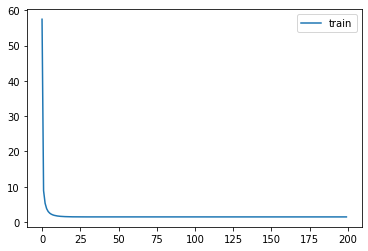

In [0]:
X_tr_numerical = train_standardized_X
X_tr_cat1= train_embID.values
#X_val_numerical = val_X
#X_val_cat1= val_embedd

#history = emb_model_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50, validation_data=([val_standardized_X,X_val_cat1], val_y))
history = emb_model_fc.fit([train_standardized_X,X_tr_cat1], train_y, epochs=200, batch_size=50)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
#Fit the model and Predict

X_tr_numerical = train_standardized_X
X_tr_cat1= train_embID.values
X_val_numerical = val_X
X_val_cat1= val_embedd.values

history = emb_model_fc.fit([train_standardized_X,X_tr_cat1], train_y, epochs=100, batch_size=50, validation_data=([val_standardized_X,X_val_cat1], val_y))
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


NameError: ignored

In [0]:
train_std_df_X.columns = ['T2mensmean', 'T2menssd', 'Gmax3ensmean', 'Gmax3enssd', 'Pcpensmean',
       'Pcpenssd', 'S10mensmean', 'S10menssd', 'Td2mensmean', 'Td2menssd',
       'lat', 'lon', 'elev', 'Mlsm', 'Melev', 'ELEV', 'rough50km',
       'NSABS50km', 'HARP_dem_new_20km', 'NSABS2.5km', 'rough20km',
       'rough15km', 'rough1km', 'WEABS50km', 'HARP_dem_new_500m', 'NSABS20km',
       'WEABS7.5km', 'WEABS12km', 'WEABS15km', 'NSABS7.5km',
       'HARP_dem_new_100km', 'rough2.5km', 'rough500m', 'HARP_dem_new_30km',
       'HARP_dem_new_10km', 'rough10km', 'HARP_dem_new_12km', 'NSABS30km',
       'WEABS20km', 'rough100km', 'rough30km', 'rough5km', 'WEABS5km',
       'WEABS2.5km', 'WEABS100km', 'HARP_dem_new_50km', 'NSABS5km',
       'NSABS100km', 'rough12km', 'HARP_dem_new', 'NSABS1km', 'NSABS12km',
       'HARP_dem_new_1km', 'HARP_dem_new_7.5km', 'WEABS1km',
       'HARP_dem_new_2.5km', 'HARP_dem_new_5km', 'NSABS15km', 'WEABS30km',
       'WEABS500m', 'NSABS10km', 'WEABS10km', 'NSABS500m', 'HARP_dem_new_15km',
       'rough7.5km', 'ZABS500m', 'ZABS1km', 'ZABS2.5km', 'ZABS5km',
       'ZABS7.5km', 'ZABS10km', 'ZABS12km', 'ZABS20km', 'ZABS30km', 'ZABS50km',
       'ZABS100km']


NameError: ignored

In [0]:
test_std_df_X.columns = ['T2mensmean', 'T2menssd', 'Gmax3ensmean', 'Gmax3enssd', 'Pcpensmean',
       'Pcpenssd', 'S10mensmean', 'S10menssd', 'Td2mensmean', 'Td2menssd',
       'lat', 'lon', 'elev', 'Mlsm', 'Melev', 'ELEV', 'rough50km',
       'NSABS50km', 'HARP_dem_new_20km', 'NSABS2.5km', 'rough20km',
       'rough15km', 'rough1km', 'WEABS50km', 'HARP_dem_new_500m', 'NSABS20km',
       'WEABS7.5km', 'WEABS12km', 'WEABS15km', 'NSABS7.5km',
       'HARP_dem_new_100km', 'rough2.5km', 'rough500m', 'HARP_dem_new_30km',
       'HARP_dem_new_10km', 'rough10km', 'HARP_dem_new_12km', 'NSABS30km',
       'WEABS20km', 'rough100km', 'rough30km', 'rough5km', 'WEABS5km',
       'WEABS2.5km', 'WEABS100km', 'HARP_dem_new_50km', 'NSABS5km',
       'NSABS100km', 'rough12km', 'HARP_dem_new', 'NSABS1km', 'NSABS12km',
       'HARP_dem_new_1km', 'HARP_dem_new_7.5km', 'WEABS1km',
       'HARP_dem_new_2.5km', 'HARP_dem_new_5km', 'NSABS15km', 'WEABS30km',
       'WEABS500m', 'NSABS10km', 'WEABS10km', 'NSABS500m', 'HARP_dem_new_15km',
       'rough7.5km', 'ZABS500m', 'ZABS1km', 'ZABS2.5km', 'ZABS5km',
       'ZABS7.5km', 'ZABS10km', 'ZABS12km', 'ZABS20km', 'ZABS30km', 'ZABS50km',
       'ZABS100km']
test_std_df_X.head(2)

In [0]:
train_std_df_X.head(2)

In [0]:
X_te_numerical = test_standardized_X
X_te_cat1= test_embedd.reshape(-1,1)


In [0]:
pred_nn = emb_model_fc.predict([X_te_numerical, X_te_cat1])
pred_nn[:,1]= np.abs(preds[:,1])

In [0]:
#plot history
pyplot.plot(pred_nn['cal_mean'], label='cal_mean')
pyplot.plot(test_ens['T2mensmean'], label='T2mensmean')
pyplot.legend()
pyplot.show()

In [0]:
#plot history
pyplot.plot(abs(pred_df['cal_sd']), label='cal_sd')
pyplot.plot(test_ens['T2menssd'], label='T2menssd')
pyplot.legend()
pyplot.show()

In [0]:
(np.mean(test_ens['T2menssd']),np.mean(pred_df['cal_sd']))

In [0]:
# Returns the loss value & metrics values for the model in test mode.
(emb_model_fc.evaluate([X_tr_numerical,X_tr_cat1], train_y, batch_size = 50, verbose=0),
emb_model_fc.evaluate([X_te_numerical,X_te_cat1], test_y, batch_size = 50, verbose=0))

## Embedd the fc model with reduced variable


In [0]:
from keras.regularizers import l1,l2
emb_model_fc = build_emb_model(len(train_X.columns), 2,[], emb_size, max_id, compile=True,
                            lr=0.01,reg=l2(0.01))
emb_model_fc.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 2)         5362        input_11[0][0]                   
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 36)           0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2)            0           embedding_1[0][0]                
___________________________________________________________________________________________

In [0]:
# scaling the train and test
from sklearn.preprocessing import StandardScaler
# create scaler
scaler = StandardScaler()
# fit scaler on train data
scaler.fit(train_X)
# apply transform
train_standardized_X  = scaler.transform(train_X)
# fit scaler on test data
scaler.fit(test_X)
# apply transform
test_standardized_X  = scaler.transform(test_X)
# fit scaler on val data
#scaler.fit(val_X)
# apply transform
#val_standardized_X  = scaler.transform(val_X)
(train_standardized_X.shape, test_standardized_X.shape)


((277403, 36), (92468, 36))

Epoch 1/100
277403/277403 [==============================] - 9s 32us/step - loss: 83.1690
Epoch 2/100
277403/277403 [==============================] - 8s 29us/step - loss: 12.8194
Epoch 3/100
277403/277403 [==============================] - 8s 29us/step - loss: 7.9681
Epoch 4/100
277403/277403 [==============================] - 8s 29us/step - loss: 5.6770
Epoch 5/100
277403/277403 [==============================] - 8s 29us/step - loss: 4.4003
Epoch 6/100
277403/277403 [==============================] - 8s 30us/step - loss: 3.6205
Epoch 7/100
277403/277403 [==============================] - 8s 29us/step - loss: 3.0993
Epoch 8/100
277403/277403 [==============================] - 8s 30us/step - loss: 2.7312
Epoch 9/100
277403/277403 [==============================] - 8s 30us/step - loss: 2.4612
Epoch 10/100
277403/277403 [==============================] - 8s 30us/step - loss: 2.2620
Epoch 11/100
277403/277403 [==============================] - 8s 30us/step - loss: 2.1103
Epoch 12/100
2774

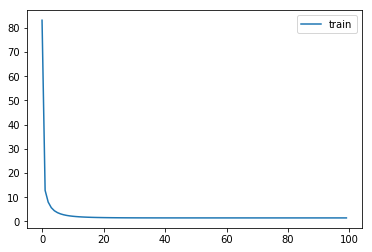

In [0]:
X_tr_numerical = train_standardized_X
X_tr_cat1= train_embedd.values
#X_val_numerical = val_X
#X_val_cat1= val_embedd

#history = emb_model_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50, validation_data=([val_standardized_X,X_val_cat1], val_y))
history = emb_model_fc.fit([train_standardized_X,X_tr_cat1], train_y, epochs=100, batch_size=50)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
(emb_model_fc.evaluate([X_tr_numerical,X_tr_cat1], train_y, batch_size = 50, verbose=0),
emb_model_fc.evaluate([X_te_numerical,X_te_cat1], test_y, batch_size = 50, verbose=0))

(1.4288140884362464, 1.4413078544090048)

## Embedded NN model

In [0]:
from keras.regularizers import l1,l2
emb_model_nn = build_emb_model(len(train_standardized_X[0]), 2,[100], emb_size, max_id, compile=True,
                            lr=0.01,reg=l2(0.01))
emb_model_nn.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 2)         5382        input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 76)           0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 2)            0           embedding_2[0][0]                
____________________________________________________________________________________________

In [0]:
train_standardized_X

array([[ 0.80958387, -1.14953093, -0.75266698, ..., -0.63763898,
        -0.59713335, -0.54885444],
       [ 0.39749295,  1.2223578 , -0.30790927, ..., -0.58549293,
        -0.45239034,  0.81000083],
       [ 0.31366081,  0.10897908, -1.38187225, ..., -0.36276778,
        -0.34083632,  0.25134032],
       ...,
       [ 0.65986887, -0.67963567, -0.15848281, ..., -0.54212231,
        -0.2346391 , -0.73150879],
       [-0.67150027, -0.63233607,  0.59678482, ..., -0.77535936,
        -0.82703847, -0.90281308],
       [ 0.27937714,  0.55932887, -0.73225105, ...,  0.68041308,
         0.33391336,  1.75353728]])

Epoch 1/500
418991/418991 [==============================] - 14s 33us/step - loss: 5.2232
Epoch 2/500
418991/418991 [==============================] - 14s 32us/step - loss: 1.9773
Epoch 3/500
418991/418991 [==============================] - 14s 32us/step - loss: 1.8117
Epoch 4/500
418991/418991 [==============================] - 14s 32us/step - loss: 1.7120
Epoch 5/500
418991/418991 [==============================] - 14s 32us/step - loss: 1.6701
Epoch 6/500
418991/418991 [==============================] - 14s 33us/step - loss: 1.6050
Epoch 7/500
418991/418991 [==============================] - 14s 33us/step - loss: 1.5721
Epoch 8/500
418991/418991 [==============================] - 14s 32us/step - loss: 1.5402
Epoch 9/500
418991/418991 [==============================] - 14s 33us/step - loss: 1.5102
Epoch 10/500
418991/418991 [==============================] - 14s 33us/step - loss: 1.5039
Epoch 11/500
418991/418991 [==============================] - 14s 34us/step - loss: 1.4736
Epoch 12

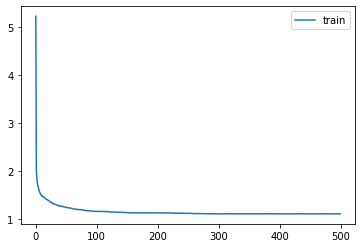

In [0]:

X_tr_numerical = train_standardized_X
X_tr_cat1= train_embID.values
#X_val_numerical = val_X
#X_val_cat1= val_embedd

#history = emb_model_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50, validation_data=([val_standardized_X,X_val_cat1], val_y))
history = emb_model_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [0]:
X_tr_numerical = train_standardized_X
X_te_cat1= train_embID.values
X_te_numerical = test_standardized_X
X_te_cat1= test_embID.values


In [0]:
(emb_model_fc.evaluate([X_tr_numerical,X_tr_cat1], train_y, batch_size = 50, verbose=0),
emb_model_fc.evaluate([X_te_numerical,X_te_cat1], test_y, batch_size = 50, verbose=0))

NameError: ignored

In [0]:
(emb_model_fc.evaluate([X_tr_numerical,X_tr_cat1], train_y, batch_size = 50, verbose=0),
emb_model_fc.evaluate([X_te_numerical,X_te_cat1], test_y, batch_size = 50, verbose=0))

(1.3719378424908237, 1.3870656340941783)

In [0]:
(emb_model_nn.evaluate([X_tr_numerical,X_tr_cat1], train_y, batch_size = 50, verbose=0),
emb_model_nn.evaluate([X_te_numerical,X_te_cat1], test_y, batch_size = 50, verbose=0))

In [0]:
(emb_model_fc.evaluate([X_tr_numerical,X_tr_cat1], train_y, batch_size = 50, verbose=0),
emb_model_fc.evaluate([X_te_numerical,X_te_cat1], test_y, batch_size = 50, verbose=0))

(1.442290477035753, 1.4615477591272137)

In [0]:
(emb_model_nn.evaluate([X_tr_numerical,X_tr_cat1], train_y, batch_size = 50, verbose=0),
emb_model_nn.evaluate([X_te_numerical,X_te_cat1], test_y, batch_size = 50, verbose=0))

(1.0787895775602865, 1.0894327691791728)

## #NN embedd with embsize 3

## NN with reduced variables

In [0]:
from keras.regularizers import l1,l2
emb_model_nn = build_emb_model(len(train_standardized_X[0]), 2,[50], emb_size, max_id, compile=True,
                            lr=0.01,reg=l2(0.01))
emb_model_nn.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 2)         5362        input_15[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 36)           0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 2)            0           embedding_3[0][0]                
___________________________________________________________________________________________

Epoch 1/200
277403/277403 [==============================] - 9s 32us/step - loss: 7.9639
Epoch 2/200
277403/277403 [==============================] - 8s 30us/step - loss: 1.8924
Epoch 3/200
277403/277403 [==============================] - 9s 31us/step - loss: 1.6822
Epoch 4/200
277403/277403 [==============================] - 8s 30us/step - loss: 1.5739
Epoch 5/200
277403/277403 [==============================] - 8s 30us/step - loss: 1.5210
Epoch 6/200
277403/277403 [==============================] - 8s 30us/step - loss: 1.4644
Epoch 7/200
277403/277403 [==============================] - 8s 30us/step - loss: 1.4370
Epoch 8/200
277403/277403 [==============================] - 8s 30us/step - loss: 1.4158
Epoch 9/200
277403/277403 [==============================] - 8s 30us/step - loss: 1.3973
Epoch 10/200
277403/277403 [==============================] - 8s 30us/step - loss: 1.3829
Epoch 11/200
277403/277403 [==============================] - 9s 31us/step - loss: 1.3718
Epoch 12/200
277403

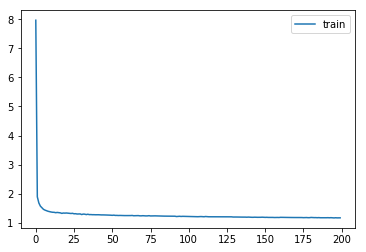

In [0]:

X_tr_numerical = train_standardized_X
X_tr_cat1= train_embedd.values
#X_val_numerical = val_X
#X_val_cat1= val_embedd

#history = emb_model_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50, validation_data=([val_standardized_X,X_val_cat1], val_y))
history = emb_model_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=200, batch_size=50)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [0]:
(emb_model_nn.evaluate([X_tr_numerical,X_tr_cat1], train_y, batch_size = 50, verbose=0),
emb_model_nn.evaluate([X_te_numerical,X_te_cat1], test_y, batch_size = 50, verbose=0))

(1.302200587890432, 1.3197595085330698)

## Feature importance for emb fc and em nn model

In [0]:
train_std_df_X = pd.DataFrame(train_standardized_X)
test_std_df_X = pd.DataFrame(test_standardized_X)
train_std_df_X.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75
0,-0.931842,-0.368911,0.068673,0.678396,-0.469135,-0.553661,1.067085,0.909976,-0.679329,-0.064214,0.357229,-0.527757,-0.659937,-0.852799,-0.807379,-0.225839,-0.969367,-0.042030,-0.710788,0.032030,-0.859533,0.0,-0.588320,-0.022429,-0.683575,-0.023085,-0.013775,-0.047924,0.0,-0.022743,-0.749129,-0.624300,-0.543989,-0.705326,-0.708444,-0.772138,-0.692759,-0.043839,-0.020447,-0.990319,-0.878175,-0.623150,-0.046958,-0.004993,-0.003422,-0.757010,-0.025501,-0.104506,-0.762258,-0.681036,0.070768,0.009277,-0.681821,-0.693857,-0.002764,-0.685613,-0.703461,0.0,-0.011666,0.044849,-0.037570,-0.019748,0.004749,0.0,-0.683619,-0.506831,-0.534612,-0.563123,-0.617118,-0.660503,-0.682525,-0.675678,-0.766321,-0.763306,-0.819629,-0.850809
1,-0.691920,-0.136816,1.142287,0.857668,1.000820,1.420698,0.361052,0.145952,1.069245,-0.273288,0.703928,-1.709216,1.812046,0.417134,-0.010996,-3.058335,0.250026,0.368286,0.803827,0.958953,-0.012301,0.0,2.926459,1.642421,1.884026,0.732684,0.650038,2.418698,0.0,1.273744,0.727268,2.707483,3.316163,-0.443383,1.129527,1.188270,-0.254804,0.406790,-0.237239,-0.034058,0.411770,1.300904,1.277606,1.296035,0.509212,-0.229399,0.376751,-0.591160,0.709495,1.838863,-1.148406,2.121385,1.708836,0.563970,6.242041,1.909268,1.067041,0.0,0.237619,3.666421,-0.012115,0.471200,1.206923,0.0,0.483481,1.960891,3.868510,0.686644,0.420762,0.605001,-0.338031,2.082532,0.012414,-0.270189,0.537069,-0.197732


In [0]:
test_std_df_X.columns = ['T2mensmean', 'T2menssd', 'Gmax3ensmean', 'Gmax3enssd', 'Pcpensmean',
       'Pcpenssd', 'S10mensmean', 'S10menssd', 'Td2mensmean', 'Td2menssd',
       'lat', 'lon', 'elev', 'Mlsm', 'Melev', 'ELEV', 'rough50km',
       'NSABS50km', 'HARP_dem_new_20km', 'NSABS2.5km', 'rough20km',
       'rough15km', 'rough1km', 'WEABS50km', 'HARP_dem_new_500m', 'NSABS20km',
       'WEABS7.5km', 'WEABS12km', 'WEABS15km', 'NSABS7.5km',
       'HARP_dem_new_100km', 'rough2.5km', 'rough500m', 'HARP_dem_new_30km',
       'HARP_dem_new_10km', 'rough10km', 'HARP_dem_new_12km', 'NSABS30km',
       'WEABS20km', 'rough100km', 'rough30km', 'rough5km', 'WEABS5km',
       'WEABS2.5km', 'WEABS100km', 'HARP_dem_new_50km', 'NSABS5km',
       'NSABS100km', 'rough12km', 'HARP_dem_new', 'NSABS1km', 'NSABS12km',
       'HARP_dem_new_1km', 'HARP_dem_new_7.5km', 'WEABS1km',
       'HARP_dem_new_2.5km', 'HARP_dem_new_5km', 'NSABS15km', 'WEABS30km',
       'WEABS500m', 'NSABS10km', 'WEABS10km', 'NSABS500m', 'HARP_dem_new_15km',
       'rough7.5km', 'ZABS500m', 'ZABS1km', 'ZABS2.5km', 'ZABS5km',
       'ZABS7.5km', 'ZABS10km', 'ZABS12km', 'ZABS20km', 'ZABS30km', 'ZABS50km',
       'ZABS100km']
test_std_df_X.head(2)



,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,lat,lon,elev,Mlsm,Melev,ELEV,rough50km,NSABS50km,HARP_dem_new_20km,NSABS2.5km,rough20km,rough15km,rough1km,WEABS50km,HARP_dem_new_500m,NSABS20km,WEABS7.5km,WEABS12km,WEABS15km,NSABS7.5km,HARP_dem_new_100km,rough2.5km,rough500m,HARP_dem_new_30km,HARP_dem_new_10km,rough10km,HARP_dem_new_12km,NSABS30km,WEABS20km,rough100km,rough30km,rough5km,WEABS5km,WEABS2.5km,WEABS100km,HARP_dem_new_50km,NSABS5km,NSABS100km,rough12km,HARP_dem_new,NSABS1km,NSABS12km,HARP_dem_new_1km,HARP_dem_new_7.5km,WEABS1km,HARP_dem_new_2.5km,HARP_dem_new_5km,NSABS15km,WEABS30km,WEABS500m,NSABS10km,WEABS10km,NSABS500m,HARP_dem_new_15km,rough7.5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,ZABS7.5km,ZABS10km,ZABS12km,ZABS20km,ZABS30km,ZABS50km,ZABS100km
0,-0.412886,-1.259195,-0.128885,0.004157,-0.599784,-0.758869,0.934712,0.231286,-0.365071,0.122215,1.001615,0.795615,-0.629300,-2.154535,-0.793095,-0.244204,-0.909001,0.026506,-0.709659,0.038815,-0.823198,0.0,-0.377212,0.108990,-0.621955,-0.006701,-0.016092,0.034223,0.0,-0.009056,-0.697945,-0.512620,-0.191235,-0.712313,-0.654942,-0.734959,-0.678545,0.044500,-0.014804,-0.949035,-0.801179,-0.641495,-0.028260,0.240004,0.084624,-0.756458,-0.015958,-0.103908,-0.768594,-0.619930,0.285841,0.019031,-0.613346,-0.693607,0.497993,-0.686266,-0.699735,0.0,0.083092,0.775815,-0.030320,0.003986,0.656634,0.0,-0.690455,0.169266,-0.155979,-0.389804,-0.630257,-0.672736,-0.700822,-0.654854,-0.761207,-0.656484,-0.708391,-0.779253
1,1.547000,-0.771664,-0.271234,-0.414616,-0.583270,-0.707556,-0.364421,-0.264103,1.188924,0.167929,-1.064051,-0.194239,-0.453726,0.573833,-0.468798,-0.005788,2.160757,-1.187919,-0.415761,0.245602,0.791911,0.0,-0.399213,4.663447,-0.463807,0.060531,0.931511,0.138862,0.0,0.309590,-0.458627,-0.334097,-0.431357,-0.609328,-0.363090,0.290266,-0.593103,0.080244,2.605497,1.243029,0.903349,-0.135898,0.351825,0.159203,1.423824,-0.328946,0.390622,-0.311396,-0.018028,-0.463378,0.171853,0.208214,-0.447800,-0.427164,0.210299,-0.426945,-0.455872,0.0,1.159724,0.099650,0.525096,1.837341,0.315282,0.0,-0.093512,-0.318891,-0.378203,-0.345740,-0.162165,0.141508,0.793521,-0.465130,1.277541,0.122219,2.982223,0.385326


In [0]:
test_embedd.head(2)

,ID
112602,811
231546,1666


In [0]:
ref_score = emb_model_fc.evaluate([X_te_numerical,X_te_cat1], test_y, batch_size = 50, verbose=0)
ref_score

1.3870656340941783

In [0]:
len(test_std_df_X.columns)

76

In [0]:
test_std_df_X.columns

Index(['T2mensmean', 'T2menssd', 'Gmax3ensmean', 'Gmax3enssd', 'Pcpensmean',
       'Pcpenssd', 'S10mensmean', 'S10menssd', 'Td2mensmean', 'Td2menssd',
       'lat', 'lon', 'elev', 'Mlsm', 'Melev', 'ELEV', 'rough50km', 'NSABS50km',
       'HARP_dem_new_20km', 'NSABS2.5km', 'rough20km', 'rough15km', 'rough1km',
       'WEABS50km', 'HARP_dem_new_500m', 'NSABS20km', 'WEABS7.5km',
       'WEABS12km', 'WEABS15km', 'NSABS7.5km', 'HARP_dem_new_100km',
       'rough2.5km', 'rough500m', 'HARP_dem_new_30km', 'HARP_dem_new_10km',
       'rough10km', 'HARP_dem_new_12km', 'NSABS30km', 'WEABS20km',
       'rough100km', 'rough30km', 'rough5km', 'WEABS5km', 'WEABS2.5km',
       'WEABS100km', 'HARP_dem_new_50km', 'NSABS5km', 'NSABS100km',
       'rough12km', 'HARP_dem_new', 'NSABS1km', 'NSABS12km',
       'HARP_dem_new_1km', 'HARP_dem_new_7.5km', 'WEABS1km',
       'HARP_dem_new_2.5km', 'HARP_dem_new_5km', 'NSABS15km', 'WEABS30km',
       'WEABS500m', 'NSABS10km', 'WEABS10km', 'NSABS500m', 'HARP_dem_ne

In [0]:
emb_model_fc

In [0]:
#Feature importance for standardized scaled
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
def eval_shuf(m, idx, emb=False):
    x_shuf = test_std_df_X.copy()
    x_shuf.iloc[:, idx] = np.random.permutation(x_shuf.iloc[:, idx])
    x = [x_shuf, test_embedd] if emb else x_shuf
    return m.evaluate(x, test_y, 50, 0)

  
def perm_imp_emb(m, ref):
    scores = [eval_shuf(m, i, True) for i in range(len(test_std_df_X.columns))]
    ids_shuf = np.random.permutation(test_embedd)
    scores += [m.evaluate([test_std_df_X, ids_shuf], test_y, 50, 0)]
    fimp = np.array(scores) - ref
    df = pd.DataFrame(columns=['Feature', 'Importance'])
    df['Feature'] = test_std_df_X.columns.to_list()+ ['Embedding']; df['Importance'] = fimp
    return df
fimp_fc_emb = perm_imp_emb(emb_model_fc, ref_score)

In [0]:
def perm_imp_emb(m, ref):
    scores = [eval_shuf(m, i, True) for i in range(len(test_std_df_X.columns))]
    ids_shuf = np.random.permutation(test_embedd)
    scores += [m.evaluate([test_std_df_X, ids_shuf], test_y, 50, 0)]
    fimp = np.array(scores) - ref
    df = pd.DataFrame(columns=['Feature', 'Importance'])
    df['Feature'] = test_std_df_X.columns.to_list()+ ['Embedding']; df['Importance'] = fimp
    return df

In [0]:
ref_score = emb_model_fc.evaluate([X_te_numerical,X_te_cat1], test_y, batch_size = 50, verbose=0)

fimp_fc_emb = perm_imp_emb(emb_model_fc, ref_score)

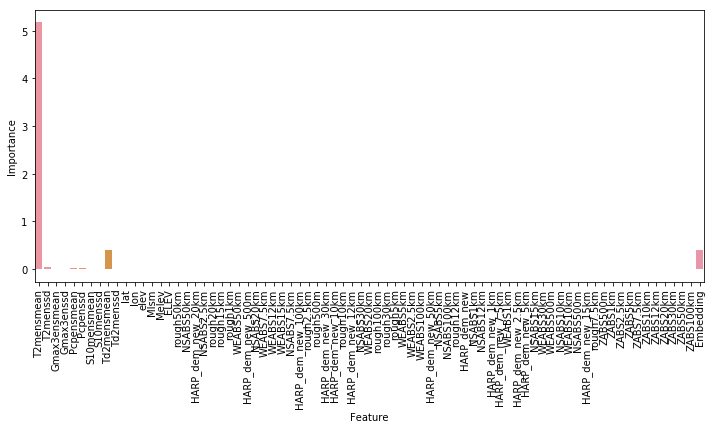

In [0]:
#Feature importance for standardized scaled
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_fc_emb, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

## NN embedd feature importance

In [0]:
ref_score = emb_model_nn.evaluate([X_te_numerical,X_te_cat1], test_y, batch_size = 50, verbose=0)
ref_score

1.0894327691791728

In [0]:
fimp_nn_emb = perm_imp_emb(emb_model_nn, ref_score)

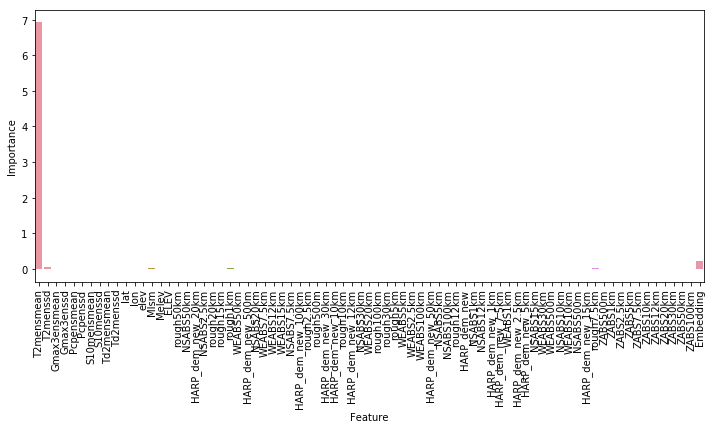

In [0]:
#Feature importance for standardized scaled
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=fimp_nn_emb, y='Importance', x='Feature', ax=ax)
plt.xticks(rotation=90);

In [0]:
df.head(2)

,SID,validdate,fcdate,leadtime,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,obs,lat,lon,elev,name,Mlsm,Melev,ELEV,FID,NSPRC5km,WEPRC20km,rough50km,NSABS50km,HARP_dem_new_20km,NSABS2.5km,rough20km,ZABS20km,rough15km,ZABS500m,WEPRC10km,WEPRC15km,rough1km,ZPRC15km,ZDEG1km,WEABS50km,HARP_dem_new_500m,...,HARP_dem_new,NSABS1km,NSPRC12km,NSABS12km,WEPRC2.5km,NSPRC30km,NSPRC500m,NSPRC15km,WEPRC50km,ZDEG15km,ZABS15km,ZDEG7.5km,HARP_dem_new_1km,HARP_dem_new_7.5km,WEABS1km,HARP_dem_new_2.5km,WEPRC500m,ZDEG30km,HARP_dem_new_5km,NSABS15km,WEABS30km,ZABS1km,NSPRC20km,WEABS500m,NSABS10km,WEABS10km,ZDEG12km,ZPRC20km,NSABS500m,HARP_dem_new_15km,ZPRC5km,ZPRC7.5km,ZPRC500m,rough7.5km,WEPRC100km,ZPRC1km,NSPRC1km,ZPRC30km,NSPRC7.5km,ZPRC2.5km
0,1001,2019-06-01 12:00:00,1559217600,48,275.075926,0.523031,12.458377,1.083646,0.001536,0.000334,5.918310,0.676188,273.975046,0.518389,274.5,70.9331,-8.6667,9.4,JAN MAYEN,0.386374,39.696462,30.296462,0.0,-0.0,-0.001809,0.0,0.0,312.0,-115.0,312.0,11.0,0.0,0.0,0.002643,0.0,16.0,0.0,0.309394,0.0,0.0,...,0.0,-5.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.206264,0.0,0.0,0.0,0.0,0.0,1.626205,36.0,0.0,-260.0,5.0,-0.0,0.0,0.0,8.0,0.031518,0.180923,0.0,0.0,17.309439,0.36,0.0,120.0,0.0,0.54,0.0054,2.839025,0.0036,4.968
1,1001,2019-06-06 12:00:00,1559649600,48,275.222588,0.484312,11.243656,0.968945,0.000321,0.000241,5.610132,0.579129,271.904696,0.832797,277.2,70.9331,-8.6667,9.4,JAN MAYEN,0.386374,39.696462,30.296462,1.0,-0.0,-0.001809,0.0,0.0,312.0,-115.0,312.0,11.0,0.0,0.0,0.002643,0.0,16.0,0.0,0.309394,0.0,0.0,...,0.0,-5.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.206264,0.0,0.0,0.0,0.0,0.0,1.626205,36.0,0.0,-260.0,5.0,-0.0,0.0,0.0,8.0,0.031518,0.180923,0.0,0.0,17.309439,0.36,0.0,120.0,0.0,0.54,0.0054,2.839025,0.0036,4.968


In [0]:
fc_nn_emb_df.shape

(369871, 79)

In [0]:
data_gc_sid = fc_nn_emb_df
fc_nn_emb_df.shape

(436793, 80)

In [0]:
# THIS CELL IS USED
data_gc_sid["TerrainType"] = data_gc_sid["HARP_globcover_new"]
map_dict = {}
for token, value in enumerate(data_gc_sid['HARP_globcover_new'].unique()): 
  #print(token,value)
  map_dict[value] = token
data_gc_sid["TerrainType"] = data_gc_sid["HARP_globcover_new"].apply(lambda x: map_dict.get(x))
data_gc_sid.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SID,HARP_globcover_new,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,obs,lat,lon,elev,Mlsm,Melev,ELEV,rough50km,NSABS50km,HARP_dem_new_20km,NSABS2.5km,rough20km,rough15km,rough1km,WEABS50km,HARP_dem_new_500m,NSABS20km,WEABS7.5km,WEABS12km,WEABS15km,NSABS7.5km,HARP_dem_new_100km,rough2.5km,rough500m,HARP_dem_new_30km,HARP_dem_new_10km,rough10km,HARP_dem_new_12km,...,WEABS20km,rough100km,rough30km,rough5km,WEABS5km,WEABS2.5km,WEABS100km,HARP_dem_new_50km,NSABS5km,NSABS100km,rough12km,HARP_dem_new,NSABS1km,NSABS12km,HARP_dem_new_1km,HARP_dem_new_7.5km,WEABS1km,HARP_dem_new_2.5km,HARP_dem_new_5km,NSABS15km,WEABS30km,WEABS500m,NSABS10km,WEABS10km,NSABS500m,HARP_dem_new_15km,rough7.5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,ZABS7.5km,ZABS10km,ZABS12km,ZABS20km,ZABS30km,ZABS50km,ZABS100km,ID,TerrainType
0,1001,240.0,275.915616,0.499708,3.953777,1.573851,0.000393,0.000265,1.733092,0.991434,274.338943,0.497539,275.5,70.9331,-8.6667,9.4,0.386374,39.696462,30.296462,0.0,0.0,312.0,-115.0,312.0,0.0,16.0,0.0,0.0,0.0,0.0,-2.0,0.0,-25.0,0.0,358.0,6.0,0.0,0.0,16.0,116.0,...,-11.0,0.0,520.0,524.0,-262.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,-5.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,-260.0,0.0,0.0,8.0,0.0,0.0,120.0,0.0,5.0,115.0,262.0,25.0,8.0,2.0,11.0,260.0,0.0,0.0,0,0
1,1001,240.0,275.870323,0.830502,4.589418,0.576509,0.000085,0.000058,2.073726,0.541732,274.483775,0.776578,277.5,70.9331,-8.6667,9.4,0.386374,39.696462,30.296462,0.0,0.0,312.0,-115.0,312.0,0.0,16.0,0.0,0.0,0.0,0.0,-2.0,0.0,-25.0,0.0,358.0,6.0,0.0,0.0,16.0,116.0,...,-11.0,0.0,520.0,524.0,-262.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,-5.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,-260.0,0.0,0.0,8.0,0.0,0.0,120.0,0.0,5.0,115.0,262.0,25.0,8.0,2.0,11.0,260.0,0.0,0.0,0,0


In [0]:
# THIS CELL IS USED
data_gc_sid["ID"] = data_gc_sid["SID"]
map_dict = {}
for token, value in enumerate(data_gc_sid['SID'].unique()): 
  #print(token,value)
  map_dict[value] = token
data_gc_sid["ID"] = data_gc_sid["SID"].apply(lambda x: map_dict.get(x))
data_gc_sid.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,SID,HARP_globcover_new,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,obs,lat,lon,elev,Mlsm,Melev,ELEV,rough50km,NSABS50km,HARP_dem_new_20km,NSABS2.5km,rough20km,rough15km,rough1km,WEABS50km,HARP_dem_new_500m,NSABS20km,WEABS7.5km,WEABS12km,WEABS15km,NSABS7.5km,HARP_dem_new_100km,rough2.5km,rough500m,HARP_dem_new_30km,HARP_dem_new_10km,rough10km,HARP_dem_new_12km,...,WEABS20km,rough100km,rough30km,rough5km,WEABS5km,WEABS2.5km,WEABS100km,HARP_dem_new_50km,NSABS5km,NSABS100km,rough12km,HARP_dem_new,NSABS1km,NSABS12km,HARP_dem_new_1km,HARP_dem_new_7.5km,WEABS1km,HARP_dem_new_2.5km,HARP_dem_new_5km,NSABS15km,WEABS30km,WEABS500m,NSABS10km,WEABS10km,NSABS500m,HARP_dem_new_15km,rough7.5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,ZABS7.5km,ZABS10km,ZABS12km,ZABS20km,ZABS30km,ZABS50km,ZABS100km,TerrainType,ID
0,1001,240.0,275.075926,0.523031,12.458377,1.083646,0.001536,0.000334,5.918310,0.676188,273.975046,0.518389,274.5,70.9331,-8.6667,9.4,0.386374,39.696462,30.296462,0.0,0.0,312.0,-115.0,312.0,0.0,16.0,0.0,0.0,0.0,0.0,-2.0,0.0,-25.0,0.0,358.0,6.0,0.0,0.0,16.0,116.0,...,-11.0,0.0,520.0,524.0,-262.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,-5.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,-260.0,0.0,0.0,8.0,0.0,0.0,120.0,0.0,5.0,115.0,262.0,25.0,8.0,2.0,11.0,260.0,0.0,0.0,0,0
1,1001,240.0,275.222588,0.484312,11.243656,0.968945,0.000321,0.000241,5.610132,0.579129,271.904696,0.832797,277.2,70.9331,-8.6667,9.4,0.386374,39.696462,30.296462,0.0,0.0,312.0,-115.0,312.0,0.0,16.0,0.0,0.0,0.0,0.0,-2.0,0.0,-25.0,0.0,358.0,6.0,0.0,0.0,16.0,116.0,...,-11.0,0.0,520.0,524.0,-262.0,0.0,0.0,0.0,0.0,0.0,116.0,0.0,-5.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,-260.0,0.0,0.0,8.0,0.0,0.0,120.0,0.0,5.0,115.0,262.0,25.0,8.0,2.0,11.0,260.0,0.0,0.0,0,0


In [0]:
tt_emb_sid_df = data_gc_sid

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(tt_emb_sid_df, test_size=0.25)
print(train.shape, test.shape)


(327594, 81) (109199, 81)


In [0]:
drop_cols = ['SID','obs', 'HARP_globcover_new','ID','TerrainType']
train_X = train.drop(drop_cols,1)
train_y = train[['obs']]
train_emb = train[['TerrainType']]

train_X.head(2)
train_X.shape


(327594, 76)

In [0]:
drop_cols = ['SID','ID','obs', 'HARP_globcover_new','TerrainType']
test_X = test.drop(drop_cols,1)
test_y = test[['obs']]
test_emb = test[['TerrainType']]
test_X.head(2)


,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,lat,lon,elev,Mlsm,Melev,ELEV,rough50km,NSABS50km,HARP_dem_new_20km,NSABS2.5km,rough20km,rough15km,rough1km,WEABS50km,HARP_dem_new_500m,NSABS20km,WEABS7.5km,WEABS12km,WEABS15km,NSABS7.5km,HARP_dem_new_100km,rough2.5km,rough500m,HARP_dem_new_30km,HARP_dem_new_10km,rough10km,HARP_dem_new_12km,NSABS30km,WEABS20km,rough100km,rough30km,rough5km,WEABS5km,WEABS2.5km,WEABS100km,HARP_dem_new_50km,NSABS5km,NSABS100km,rough12km,HARP_dem_new,NSABS1km,NSABS12km,HARP_dem_new_1km,HARP_dem_new_7.5km,WEABS1km,HARP_dem_new_2.5km,HARP_dem_new_5km,NSABS15km,WEABS30km,WEABS500m,NSABS10km,WEABS10km,NSABS500m,HARP_dem_new_15km,rough7.5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,ZABS7.5km,ZABS10km,ZABS12km,ZABS20km,ZABS30km,ZABS50km,ZABS100km
283700,298.009695,0.701792,5.406285,0.635686,0.001491,0.000612,1.257144,0.419386,279.995962,0.854678,43.0167,22.7500,450.00,0.999991,881.880057,431.880057,1530.0,323.0,788.0,-9.5,360.0,0.0,281.0,-13.5,522.0,-180.0,142.0,137.0,0.0,-106.5,934.0,312.0,216.0,760.0,758.0,584.0,633.0,68.5,161.0,893.0,1338.0,402.0,71.5,33.0,-19.5,1150.0,-85.5,376.0,775.0,463.0,-140.5,-257.0,592.0,580.0,105.5,452.0,563.0,0.0,519.5,50.5,-224.5,173.5,-70.0,0.0,462.0,86.314827,175.700027,34.340210,111.456268,177.500000,283.729614,291.235291,241.497406,523.996643,323.281982,376.505310
135770,300.896185,1.406089,13.202556,1.167351,0.000130,0.000177,5.076970,0.738924,283.894816,1.011556,47.0006,6.9542,485.48,0.796011,735.652752,250.172752,925.0,326.5,1259.0,-356.5,837.0,0.0,319.0,-250.5,453.0,-281.0,-146.5,-450.0,0.0,-244.0,696.0,713.0,154.0,1032.0,885.0,1111.0,741.0,-96.0,-198.5,3032.0,907.0,716.0,-86.0,-177.5,12.5,422.0,-149.5,467.0,907.0,463.0,-124.0,-389.5,499.0,1052.0,-82.5,669.0,1138.0,0.0,105.5,-32.0,-345.0,-224.5,-33.5,0.0,848.0,46.327637,148.937073,398.244263,172.471008,284.601929,411.612976,595.155640,344.039612,142.640289,411.524597,467.167267


In [0]:
# scaling the train and test
from sklearn.preprocessing import StandardScaler
# create scaler
scaler = StandardScaler()
# fit scaler on train data
scaler.fit(train_X)
# apply transform
train_standardized_X  = scaler.transform(train_X)
# fit scaler on test data
scaler.fit(test_X)
# apply transform
test_standardized_X  = scaler.transform(test_X)
# fit scaler on val data
#scaler.fit(val_X)
# apply transform
#val_standardized_X  = scaler.transform(val_X)
(train_standardized_X.shape, test_standardized_X.shape)


((327594, 76), (109199, 76))

In [0]:
emb_size = 3
max_id = tt_emb_sid_df['TerrainType'].nunique()
max_id


In [0]:
def build_emb_model(n_features, n_outputs, hidden_nodes, emb_size, max_id,
                    compile=False, optimizer='adam', lr=0.01,
                    loss=crps_cost_function,
                    activation='relu', reg=None):
    """

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        emb_size: Embedding size
        max_id: Max embedding ID
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
        activation: Activation function for hidden layer

    Returns:
        model: Keras model
    """
    if type(hidden_nodes) is not list:
        hidden_nodes = [hidden_nodes]

    features_in = Input(shape=(n_features,))
    id_in = Input(shape=(1,))
    emb = Embedding(max_id + 1, emb_size)(id_in)
    emb = Flatten()(emb)
    x = Concatenate()([features_in, emb])
    for h in hidden_nodes:
        x = Dense(h, activation=activation, kernel_regularizer=reg)(x)
    x = Dense(n_outputs, activation='linear', kernel_regularizer=reg)(x)
    model = Model(inputs=[features_in, id_in], outputs=x)

    if compile:
        opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer=opt, loss=loss)
    return model



In [0]:
from keras.regularizers import l1,l2
emb_model_fc = build_emb_model(len(train_X.columns), 2,[], emb_size, max_id, compile=True,
                            lr=0.01,reg=l2(0.01))
emb_model_fc.summary()

In [0]:
X_tr_numerical = train_standardized_X
X_tr_cat1= train_emb.values
#X_val_numerical = val_X
#X_val_cat1= val_embedd

#history = emb_model_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50, validation_data=([val_standardized_X,X_val_cat1], val_y))
history = emb_model_fc.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/500
 77000/327594 [======>.......................] - ETA: 6s - loss: 1.4986

KeyboardInterrupt: ignored

In [0]:
train_embedd.head(10)

,TerrainType
15793,4
240028,13
91045,14
6669,1
2211,1
370058,12
38379,2
335011,7
91822,12
308294,1


## NN Embedding model with terrace type

In [0]:
from keras.regularizers import l1,l2
emb_model_tt_nn = build_emb_model(len(train_X.columns), 2,[100], emb_size, max_id, compile=True,
                            lr=0.01,reg=l2(0.01))
emb_model_tt_nn.summary()





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 2)         5382        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 76)           0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 2)            0           embedding_1[0][0]                
________________________________________________________________________________________

In [0]:
max_id

2690

Epoch 1/1000
418991/418991 [==============================] - 14s 33us/step - loss: 1.1980
Epoch 2/1000
418991/418991 [==============================] - 14s 33us/step - loss: 1.1967
Epoch 3/1000
418991/418991 [==============================] - 14s 32us/step - loss: 1.1982
Epoch 4/1000
418991/418991 [==============================] - 13s 32us/step - loss: 1.1966
Epoch 5/1000
418991/418991 [==============================] - 14s 32us/step - loss: 1.1962
Epoch 6/1000
418991/418991 [==============================] - 14s 33us/step - loss: 1.1952
Epoch 7/1000
418991/418991 [==============================] - 14s 32us/step - loss: 1.1939
Epoch 8/1000
418991/418991 [==============================] - 13s 32us/step - loss: 1.1945
Epoch 9/1000
418991/418991 [==============================] - 13s 32us/step - loss: 1.1933
Epoch 10/1000
418991/418991 [==============================] - 13s 32us/step - loss: 1.1916
Epoch 11/1000
418991/418991 [==============================] - 13s 31us/step - loss: 1.19

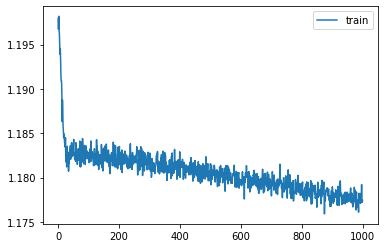

In [0]:
X_tr_numerical = train_standardized_X
X_tr_cat1= train_embTT.values
#X_val_numerical = val_X
#X_val_cat1= val_embedd

#history = emb_model_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50, validation_data=([val_standardized_X,X_val_cat1], val_y))
history = emb_model_tt_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=1000, batch_size=50)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
X_te_numerical = test_standardized_X
X_te_cat1= test_embTT.values

In [0]:
(emb_model_tt_nn.evaluate([X_tr_numerical,X_tr_cat1], train_y, batch_size = 50, verbose=0),
emb_model_tt_nn.evaluate([X_te_numerical,X_te_cat1], test_y, batch_size = 50, verbose=0))

(1.1943538625005015, 1.1938756875124485)

In [0]:
ref_score = emb_model_nn.evaluate([X_te_numerical,X_te_cat1], test_y, batch_size = 50, verbose=0)
ref_score

X_tr_numerical = train_standardized_X
X_tr_cat1= train_emb.values
#X_val_numerical = val_X
#X_val_cat1= val_embedd

#history = emb_model_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50, validation_data=([val_standardized_X,X_val_cat1], val_y))
history = emb_model_fc.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## emb_size 1

In [0]:
from keras.regularizers import l1,l2
emb_model_tt_nn = build_emb_model(len(train_X.columns), 1,[80], emb_size, max_id, compile=True,
                            lr=0.01,reg=l2(0.01))
emb_model_tt_nn.summary()

In [0]:
X_tr_numerical = train_standardized_X
X_tr_cat1= train_embedd.values
#X_val_numerical = val_X
#X_val_cat1= val_embedd

#history = emb_model_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50, validation_data=([val_standardized_X,X_val_cat1], val_y))
history = emb_model_tt_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=100, batch_size=50)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

##embsize 3 with TT embedd

In [0]:
emb_size = 3

In [0]:
max_id = 19

In [0]:
from keras.regularizers import l1,l2
emb_model_tt_nn = build_emb_model(len(train_X.columns), 3,[80], emb_size, max_id, compile=True,
                            lr=0.01,reg=l2(0.01))
emb_model_tt_nn.summary()





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 3)         60          input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 76)           0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3)            0           embedding_1[0][0]                
________________________________________________________________________________________

In [0]:
max_id

19

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/300
327594/327594 [==============================] - 13s 39us/step - loss: 5.6500
Epoch 2/300
327594/327594 [==============================] - 12s 37us/step - loss: 2.2704
Epoch 3/300
327594/327594 [==============================] - 12s 37us/step - loss: 2.0143
Epoch 4/300
327594/327594 [==============================] - 12s 37us/step - loss: 1.8486
Epoch 5/300
327594/327594 [==============================] - 12s 37us/step - loss: 1.7683
Epoch 6/300
327594/327594 [==============================] - 12s 37us/step - loss: 1.7249
Epoch 7/300
327594/327594 [==============================] - 12s 38us/step - loss: 1.6702
Epoch 8/300
327594/327594 [==============================] - 13s 40us/step - loss: 1.6493
Epoch 9/300
327594/327594 [==============================] - 13s 39us/step - loss: 1.6055
Epoch 10/300
327594/327594 [==============================] - 13s 38us/step - loss: 1.5976
Epo

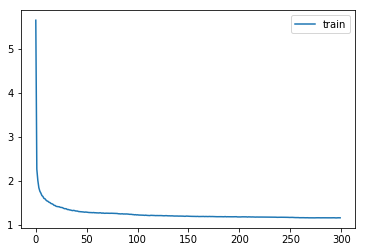

In [0]:
X_tr_numerical = train_standardized_X
X_tr_cat1= train_embTT.values
#X_val_numerical = val_X
#X_val_cat1= val_embedd

#history = emb_model_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50, validation_data=([val_standardized_X,X_val_cat1], val_y))
history = emb_model_tt_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=300, batch_size=50)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# TT embsize 1

In [0]:
max_id

19

In [0]:
emb_size = 1
emb_size

1

In [0]:
from keras.regularizers import l1,l2
emb_model_tt_nn = build_emb_model(len(train_X.columns), 3,[80], emb_size, max_id, compile=True,
                            lr=0.01,reg=l2(0.01))
emb_model_tt_nn.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 1)         20          input_8[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 76)           0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 1)            0           embedding_4[0][0]                
____________________________________________________________________________________________

Epoch 1/1000
327594/327594 [==============================] - 11s 34us/step - loss: 1.3184
Epoch 2/1000
327594/327594 [==============================] - 11s 33us/step - loss: 1.3193
Epoch 3/1000
327594/327594 [==============================] - 10s 32us/step - loss: 1.3161
Epoch 4/1000
327594/327594 [==============================] - 10s 31us/step - loss: 1.3085
Epoch 5/1000
327594/327594 [==============================] - 11s 33us/step - loss: 1.3154
Epoch 6/1000
327594/327594 [==============================] - 11s 34us/step - loss: 1.3038
Epoch 7/1000
327594/327594 [==============================] - 11s 34us/step - loss: 1.3076
Epoch 8/1000
327594/327594 [==============================] - 11s 32us/step - loss: 1.3101
Epoch 9/1000
327594/327594 [==============================] - 11s 32us/step - loss: 1.3021
Epoch 10/1000
327594/327594 [==============================] - 11s 33us/step - loss: 1.3022
Epoch 11/1000
327594/327594 [==============================] - 11s 35us/step - loss: 1.30

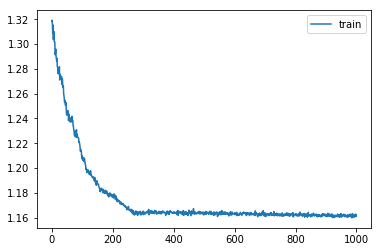

In [0]:
X_tr_numerical = train_standardized_X
X_tr_cat1= train_embTT.values
#X_val_numerical = val_X
#X_val_cat1= val_embedd

#history = emb_model_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50, validation_data=([val_standardized_X,X_val_cat1], val_y))
history = emb_model_tt_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=1000, batch_size=50)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## Feature importance of Terrain type


In [0]:
ref_score = emb_model_nn.evaluate([X_te_numerical,X_te_cat1], test_y, batch_size = 50, verbose=0)
ref_score

X_tr_numerical = train_standardized_X
X_tr_cat1= train_embTT.values
#X_val_numerical = val_X
#X_val_cat1= val_embedd

#history = emb_model_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50, validation_data=([val_standardized_X,X_val_cat1], val_y))
history = emb_model_fc.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: ignored

## Terrain type and Station ID (SID) embedding
We have two embedding layers one is the station id and the other is terrain type. 

In [0]:
drop_cols = ['SID','obs', 'HARP_globcover_new','ID','TerrainType']
train_X = train.drop(drop_cols,1)
train_y = train[['obs']]
train_emb1 = train[['ID']]
train_emb2 = train[['TerrainType']]

KeyError: ignored

In [0]:
drop_cols = ['SID','ID','obs', 'HARP_globcover_new','TerrainType']
test_X = test.drop(drop_cols,1)
test_y = test[['obs']]
test_emb1= test[['ID']]
test_emb2 = test[['TerrainType']]
test_X.head(2)


,T2mensmean,T2menssd,Gmax3ensmean,Gmax3enssd,Pcpensmean,Pcpenssd,S10mensmean,S10menssd,Td2mensmean,Td2menssd,lat,lon,elev,Mlsm,Melev,ELEV,rough50km,NSABS50km,HARP_dem_new_20km,NSABS2.5km,rough20km,rough15km,rough1km,WEABS50km,HARP_dem_new_500m,NSABS20km,WEABS7.5km,WEABS12km,WEABS15km,NSABS7.5km,HARP_dem_new_100km,rough2.5km,rough500m,HARP_dem_new_30km,HARP_dem_new_10km,rough10km,HARP_dem_new_12km,NSABS30km,WEABS20km,rough100km,rough30km,rough5km,WEABS5km,WEABS2.5km,WEABS100km,HARP_dem_new_50km,NSABS5km,NSABS100km,rough12km,HARP_dem_new,NSABS1km,NSABS12km,HARP_dem_new_1km,HARP_dem_new_7.5km,WEABS1km,HARP_dem_new_2.5km,HARP_dem_new_5km,NSABS15km,WEABS30km,WEABS500m,NSABS10km,WEABS10km,NSABS500m,HARP_dem_new_15km,rough7.5km,ZABS500m,ZABS1km,ZABS2.5km,ZABS5km,ZABS7.5km,ZABS10km,ZABS12km,ZABS20km,ZABS30km,ZABS50km,ZABS100km
610,281.402563,1.228218,9.927385,2.069441,0.016902,0.005536,3.113122,0.882127,274.207679,1.374939,69.6767,18.9131,8.8,0.881003,273.415418,264.615418,562.0,176.0,284.0,0.5,620.0,0.0,12.0,32.0,6.0,-236.5,0.0,234.5,0.0,-68.5,0.0,93.0,11.0,0.0,276.0,507.0,33.0,220.5,-299.5,384.0,602.0,500.0,29.0,7.5,0.0,562.0,-60.0,0.0,469.0,5.0,-0.5,-67.5,8.0,1.0,4.5,1.0,0.0,0.0,72.5,3.0,-78.0,-253.5,-4.0,0.0,576.0,5.000000,4.527693,7.516648,66.640831,68.500000,265.228668,244.021515,381.618256,232.113113,178.885437,0.000000
299529,302.869111,0.384681,7.681364,1.525975,0.000000,0.000000,4.215816,1.297344,294.195659,0.473613,36.4000,28.0833,11.0,0.121847,71.613579,60.613579,190.0,-3.0,0.0,14.5,367.0,0.0,145.0,0.0,63.0,183.5,13.0,80.5,0.0,177.5,0.0,65.0,190.0,62.0,53.0,336.0,108.0,-151.0,0.0,1239.0,390.0,142.0,49.0,3.5,207.5,0.0,43.5,-515.0,393.0,22.0,19.0,196.5,101.0,7.0,50.5,0.0,10.0,0.0,0.0,23.0,168.0,31.0,92.0,0.0,355.0,94.831429,53.956001,14.916434,65.522896,177.975418,170.836182,212.349945,183.500000,151.000000,3.000000,555.230835


In [0]:
max_id1 = train['ID'].nunique()
max_id2 = train_emb2.nunique()
(max_id1,max_id2)

(2680, TerrainType    19
 dtype: int64)

In [0]:
def build_emb_model(n_features, n_outputs, hidden_nodes, emb_size, max_id,
                    compile=False, optimizer='adam', lr=0.01,
                    loss=crps_cost_function,
                    activation='relu', reg=None):
    """

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        emb_size: Embedding size
        max_id: Max embedding ID
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
        activation: Activation function for hidden layer

    Returns:
        model: Keras model
    """
    if type(hidden_nodes) is not list:
        hidden_nodes = [hidden_nodes]

    features_in = Input(shape=(n_features,))
    id_in = Input(shape=(1,))
    emb = Embedding(max_id + 1, emb_size)(id_in)
    emb = Flatten()(emb)
    x = Concatenate()([features_in, emb])
    for h in hidden_nodes:
        x = Dense(h, activation=activation, kernel_regularizer=reg)(x)
    x = Dense(n_outputs, activation='linear', kernel_regularizer=reg)(x)
    model = Model(inputs=[features_in, id_in], outputs=x)

    if compile:
        opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer=opt, loss=loss)
    return model


In [0]:
def build_emb_model(n_features, n_outputs, hidden_nodes, emb_size1, max_id1,emb_size2, max_id2,
                    compile=False, optimizer='adam', lr=0.01,
                    loss=crps_cost_function,
                    activation='relu', reg=None):
    """

    Args:
        n_features: Number of features
        n_outputs: Number of outputs
        hidden_nodes: int or list of hidden nodes
        emb_size: Embedding size
        max_id: Max embedding ID
        compile: If true, compile model
        optimizer: Name of optimizer
        lr: learning rate
        loss: loss function
        activation: Activation function for hidden layer

    Returns:
        model: Keras model
    """
    if type(hidden_nodes) is not list:
        hidden_nodes = [hidden_nodes]

    features_in = Input(shape=(n_features,))
    id_in = Input(shape=(1,))
    emb1 = Embedding(max_id1 + 1, emb_size1)(id_in)
    emb1 = Flatten()(emb1)
    emb2 = Embedding(max_id2 + 1, emb_size2)(emb1)
    emb2 = Flatten()(emb2)
    
    
    x = Concatenate()([features_in, emb1,emb2])
    for h in hidden_nodes:
        x = Dense(h, activation=activation, kernel_regularizer=reg)(x)
    x = Dense(n_outputs, activation='linear', kernel_regularizer=reg)(x)
    model = Model(inputs=[features_in, id_in], outputs=x)

    if compile:
        opt = keras.optimizers.__dict__[optimizer](lr=lr)
        model.compile(optimizer=opt, loss=loss)
    return model



In [0]:
emb_size1 = 2
emb_size2 = 2


In [0]:
max_id1

2680

In [0]:
max_id2=20

In [0]:
from keras.regularizers import l1,l2
emb_model_id_tt_nn = build_emb_model(len(train_X.columns), 2,[50], emb_size1, max_id1,emb_size2,max_id2, compile=True,
                                     lr=0.01,reg=l2(0.01))
emb_model_tt_nn.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 2)         40          input_17[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 76)           0                                            
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 2)            0           embedding_8[0][0]                
____________________________________________________________________________________________

In [0]:
X_tr_numerical = train_standardized_X
X_tr_cat1= train_embedd.values
#X_val_numerical = val_X
#X_val_cat1= val_embedd

#history = emb_model_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=500, batch_size=50, validation_data=([val_standardized_X,X_val_cat1], val_y))
history = emb_model_tt_nn.fit([train_standardized_X,X_tr_cat1], train_y, epochs=100, batch_size=50)
# plot history
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/100
277403/277403 [==============================] - 12s 44us/step - loss: 1.2941
Epoch 2/100
277403/277403 [==============================] - 12s 43us/step - loss: 1.2992
Epoch 3/100
138800/277403 [==============>...............] - ETA: 5s - loss: 1.2963